In [1]:
# # RamanFormer for Creatinine Quantification in PBS
# 
# This notebook walks through loading preprocessed Raman spectra at different creatinine
# concentrations, building a modular RamanFormer PyTorch model, training, and evaluating it.

## 1. Setup and Imports

import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Paths to your .npy files (update as needed)
data_dir = 'data_preprocessed'
files = {
    0:  '0.0uM/augmented_300.npy',
    30: '30.0uM/augmented_300.npy',
    50: '50.0uM/augmented_300.npy',
    70: '70.0uM/augmented_300.npy',
    100:'100.0uM/augmented_300.npy',
    200:'200.0uM/augmented_300.npy',
    300:'300.0uM/augmented_300.npy'
}

# Load all spectra and labels
X_list, y_list = [], []
for conc, fname in files.items():
    arr = np.load(os.path.join(data_dir, fname))  # (N_samples, L)
    X_list.append(arr)
    y_list.append(np.full(arr.shape[0], conc, dtype=np.float32))

X = np.vstack(X_list).astype(np.float32)
y = np.concatenate(y_list).astype(np.float32)

print('Total samples:', X.shape[0])
print('Spectrum length:', X.shape[1])

Total samples: 2100
Spectrum length: 1024


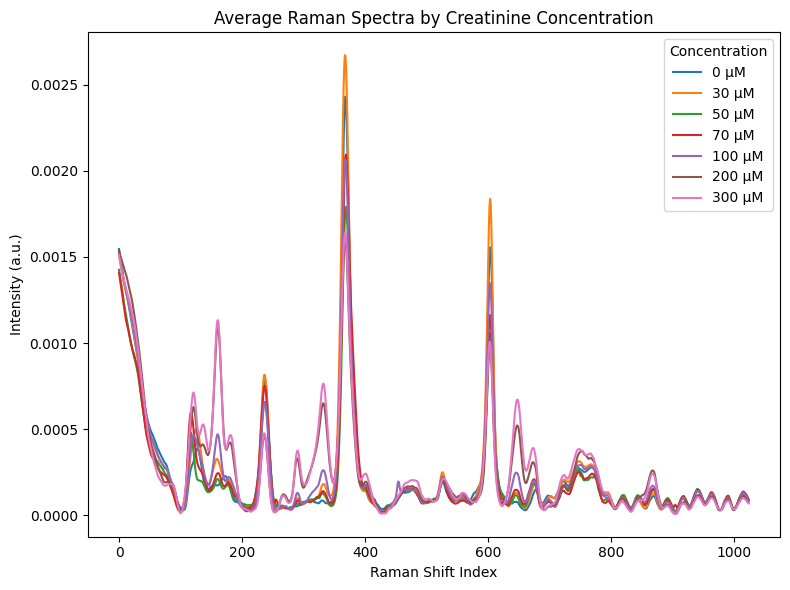

In [4]:
## 2.1 Plotting Average Spectra by Concentration

# Compute and plot the mean spectrum for each concentration
avg_spectra = {}
for conc, fname in files.items():
    spectra = np.load(os.path.join(data_dir, fname))
    avg_spectra[conc] = spectra.mean(axis=0)

plt.figure(figsize=(8, 6))
for conc in sorted(avg_spectra):
    plt.plot(avg_spectra[conc], label=f'{conc} µM')
plt.xlabel('Raman Shift Index')
plt.ylabel('Intensity (a.u.)')
plt.title('Average Raman Spectra by Creatinine Concentration')
plt.legend(title='Concentration')
plt.tight_layout()
plt.show()

In [5]:
## 3. Train/Validation Split

# Shuffle and split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('Train samples:', X_train.shape[0])
print('Val samples:  ', X_val.shape[0])

Train samples: 1680
Val samples:   420


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


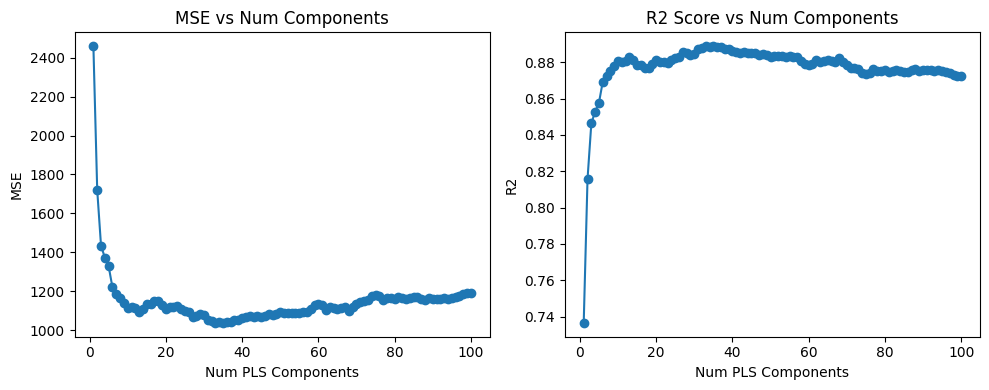

In [20]:
# Prova da 1 a 100 componenti
mse_list = []
r2_list = []

for n_comp in range(1, 101):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X_train_scaled, y_train)
    y_pred = pls.predict(X_val_scaled).ravel()

    mse = mean_squared_error(y_val, y_pred)
    r2  = r2_score(y_val, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

# Plot performance
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,101), mse_list, marker='o')
plt.title('MSE vs Num Components')
plt.xlabel('Num PLS Components')
plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(range(1,101), r2_list, marker='o')
plt.title('R2 Score vs Num Components')
plt.xlabel('Num PLS Components')
plt.ylabel('R2')

plt.tight_layout()
plt.show()


In [21]:
best_n = np.argmin(mse_list) + 1
print(f"Miglior numero di componenti: {best_n}")

pls_best = PLSRegression(n_components=best_n)
pls_best.fit(X_train_scaled, y_train)
y_pred = pls_best.predict(X_val_scaled).ravel()

print("MSE:", mean_squared_error(y_val, y_pred))
print("R²: ", r2_score(y_val, y_pred))


Miglior numero di componenti: 35
MSE: 1037.4027032152092
R²:  0.8888638251500232


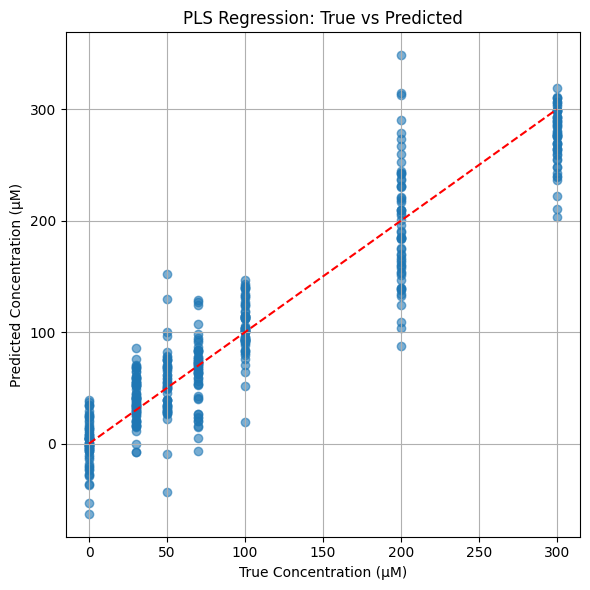

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Concentration (µM)")
plt.ylabel("Predicted Concentration (µM)")
plt.title("PLS Regression: True vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
class RamanDataset(Dataset):
    def __init__(self, spectra, targets):
        self.spectra = spectra
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return torch.from_numpy(self.spectra[idx]), torch.tensor(self.targets[idx])

train_ds = RamanDataset(X_train, y_train)
val_ds   = RamanDataset(X_val,   y_val)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, seq_len, patch_size, emb_dim):
        super().__init__()
        assert seq_len % patch_size == 0
        self.num_patches = seq_len // patch_size
        self.proj = nn.Linear(patch_size, emb_dim)

    def forward(self, x):
        B, L = x.shape
        x = x.view(B, self.num_patches, -1)
        return self.proj(x)

class RamanFormer(nn.Module):
    def __init__(self, seq_len, patch_size=128, emb_dim=256,
                 n_layers=3, n_heads=8, ffn_dim=1024, mlp_dim=256):
        super().__init__()
        self.patch_embed = PatchEmbedding(seq_len, patch_size, emb_dim)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads,
            dim_feedforward=ffn_dim, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.conv1 = nn.Conv1d(emb_dim, emb_dim*2, kernel_size=9, stride=2, padding=4)
        self.bn1   = nn.BatchNorm1d(emb_dim*2)
        self.conv2 = nn.Conv1d(emb_dim*2, emb_dim*2, kernel_size=9, stride=2, padding=4)
        self.bn2   = nn.BatchNorm1d(emb_dim*2)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc1   = nn.Linear(emb_dim*2, mlp_dim)
        self.fc2   = nn.Linear(mlp_dim, 1)
        self.act   = nn.GELU()

    def forward(self, x):
        x = self.patch_embed(x)             # (B, P, emb)
        x = self.transformer(x)             # (B, P, emb)
        x = x.permute(0, 2, 1)              # (B, emb, P)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)        # (B, emb*2)
        x = self.act(self.fc1(x))
        return self.fc2(x).squeeze(-1)

# Instantiate model
seq_len = X.shape[1]
model = RamanFormer(seq_len=seq_len).to(device)
print(model)

RamanFormer(
  (patch_embed): PatchEmbedding(
    (proj): Linear(in_features=128, out_features=256, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (conv1): Conv1d(256, 512, kernel_size=(9,), stride=(2,), padding=(4,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): 

In [8]:
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler: CosineAnnealing decrescente fino a eta_min
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-6)


def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for specs, targets in loader:
        specs, targets = specs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model(specs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * specs.size(0)
    return total_loss / len(loader.dataset)


def validate(model, loader):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for specs, targets in loader:
            specs, targets = specs.to(device), targets.to(device)
            preds = model(specs)
            all_preds.append(preds.cpu().numpy())
            all_trues.append(targets.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_trues)

In [9]:
num_epochs = 1000
best_mae = float('inf')

for epoch in tqdm(range(1, num_epochs+1)):
    tr_loss = train_epoch(model, train_loader)
    preds_val, trues_val = validate(model, val_loader)
    val_mae = mean_absolute_error(trues_val, preds_val)
    val_mse = mean_squared_error(trues_val, preds_val)
    val_r2  = r2_score(trues_val, preds_val)

    scheduler.step()  # aggiorna il learning rate

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), 'best_ramanformer.pth')

    # Stampa con learning rate attuale
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch:03}: Train L1={tr_loss:.4f} | Val MAE={val_mae:.4f} | MSE={val_mse:.4f} | R2={val_r2:.4f} | LR={current_lr:.2e}")


  0%|          | 1/1000 [00:01<17:06,  1.03s/it]

Epoch 001: Train L1=106.5661 | Val MAE=98.6584 | MSE=18701.9258 | R2=-1.0035 | LR=1.00e-04


  0%|          | 2/1000 [00:01<12:50,  1.29it/s]

Epoch 002: Train L1=101.2180 | Val MAE=92.5991 | MSE=17089.4746 | R2=-0.8308 | LR=1.00e-04


  0%|          | 3/1000 [00:02<11:27,  1.45it/s]

Epoch 003: Train L1=93.1979 | Val MAE=91.3769 | MSE=16778.2812 | R2=-0.7974 | LR=1.00e-04


  0%|          | 4/1000 [00:02<10:48,  1.54it/s]

Epoch 004: Train L1=84.8582 | Val MAE=84.1132 | MSE=15062.8164 | R2=-0.6137 | LR=1.00e-04


  0%|          | 5/1000 [00:03<10:27,  1.59it/s]

Epoch 005: Train L1=79.3904 | Val MAE=73.5395 | MSE=11111.7285 | R2=-0.1904 | LR=1.00e-04


  1%|          | 6/1000 [00:03<09:49,  1.69it/s]

Epoch 006: Train L1=76.3709 | Val MAE=89.3051 | MSE=16143.3711 | R2=-0.7294 | LR=1.00e-04


  1%|          | 7/1000 [00:04<09:27,  1.75it/s]

Epoch 007: Train L1=67.6554 | Val MAE=549.4073 | MSE=307126.5625 | R2=-31.9022 | LR=1.00e-04


  1%|          | 8/1000 [00:05<09:29,  1.74it/s]

Epoch 008: Train L1=57.9629 | Val MAE=58.4997 | MSE=6585.8916 | R2=0.2945 | LR=1.00e-04


  1%|          | 9/1000 [00:05<09:09,  1.80it/s]

Epoch 009: Train L1=50.8743 | Val MAE=280.7826 | MSE=83396.7266 | R2=-7.9342 | LR=1.00e-04


  1%|          | 10/1000 [00:06<08:55,  1.85it/s]

Epoch 010: Train L1=47.1056 | Val MAE=66.1267 | MSE=7870.5513 | R2=0.1568 | LR=1.00e-04


  1%|          | 11/1000 [00:06<08:45,  1.88it/s]

Epoch 011: Train L1=45.7019 | Val MAE=97.9299 | MSE=12374.6426 | R2=-0.3257 | LR=1.00e-04


  1%|          | 12/1000 [00:07<08:38,  1.90it/s]

Epoch 012: Train L1=43.3379 | Val MAE=158.2548 | MSE=30027.3359 | R2=-2.2168 | LR=1.00e-04


  1%|▏         | 13/1000 [00:07<08:35,  1.92it/s]

Epoch 013: Train L1=42.4478 | Val MAE=85.9156 | MSE=14126.6504 | R2=-0.5134 | LR=1.00e-04


  1%|▏         | 14/1000 [00:08<08:52,  1.85it/s]

Epoch 014: Train L1=41.9137 | Val MAE=38.9792 | MSE=2802.7471 | R2=0.6997 | LR=1.00e-04


  2%|▏         | 15/1000 [00:08<08:45,  1.87it/s]

Epoch 015: Train L1=40.9584 | Val MAE=126.8908 | MSE=20017.0215 | R2=-1.1444 | LR=9.99e-05


  2%|▏         | 16/1000 [00:09<08:38,  1.90it/s]

Epoch 016: Train L1=42.6218 | Val MAE=50.0519 | MSE=4529.8682 | R2=0.5147 | LR=9.99e-05


  2%|▏         | 17/1000 [00:09<08:33,  1.92it/s]

Epoch 017: Train L1=40.0189 | Val MAE=177.9558 | MSE=38632.4375 | R2=-3.1387 | LR=9.99e-05


  2%|▏         | 18/1000 [00:10<08:30,  1.92it/s]

Epoch 018: Train L1=40.4872 | Val MAE=135.5201 | MSE=22294.3477 | R2=-1.3884 | LR=9.99e-05


  2%|▏         | 19/1000 [00:10<08:27,  1.93it/s]

Epoch 019: Train L1=39.7591 | Val MAE=84.8522 | MSE=12550.8516 | R2=-0.3446 | LR=9.99e-05


  2%|▏         | 20/1000 [00:11<08:25,  1.94it/s]

Epoch 020: Train L1=39.7038 | Val MAE=50.4636 | MSE=4505.3545 | R2=0.5173 | LR=9.99e-05


  2%|▏         | 21/1000 [00:11<08:22,  1.95it/s]

Epoch 021: Train L1=37.7047 | Val MAE=81.3272 | MSE=11529.1299 | R2=-0.2351 | LR=9.99e-05


  2%|▏         | 22/1000 [00:12<08:44,  1.86it/s]

Epoch 022: Train L1=38.1292 | Val MAE=35.8363 | MSE=2390.3989 | R2=0.7439 | LR=9.99e-05


  2%|▏         | 23/1000 [00:12<08:37,  1.89it/s]

Epoch 023: Train L1=37.0652 | Val MAE=141.2905 | MSE=23275.2266 | R2=-1.4935 | LR=9.99e-05


  2%|▏         | 24/1000 [00:13<08:31,  1.91it/s]

Epoch 024: Train L1=37.0113 | Val MAE=51.9502 | MSE=4195.8281 | R2=0.5505 | LR=9.99e-05


  2%|▎         | 25/1000 [00:13<08:27,  1.92it/s]

Epoch 025: Train L1=37.5882 | Val MAE=38.6135 | MSE=2816.5779 | R2=0.6983 | LR=9.98e-05


  3%|▎         | 26/1000 [00:14<08:25,  1.93it/s]

Epoch 026: Train L1=37.1735 | Val MAE=41.1281 | MSE=3295.2375 | R2=0.6470 | LR=9.98e-05


  3%|▎         | 27/1000 [00:14<08:22,  1.94it/s]

Epoch 027: Train L1=35.7778 | Val MAE=38.7449 | MSE=2968.1436 | R2=0.6820 | LR=9.98e-05


  3%|▎         | 28/1000 [00:15<08:41,  1.86it/s]

Epoch 028: Train L1=35.3150 | Val MAE=35.3125 | MSE=2453.2070 | R2=0.7372 | LR=9.98e-05


  3%|▎         | 29/1000 [00:16<08:34,  1.89it/s]

Epoch 029: Train L1=36.4488 | Val MAE=85.6600 | MSE=12850.5234 | R2=-0.3767 | LR=9.98e-05


  3%|▎         | 30/1000 [00:16<08:28,  1.91it/s]

Epoch 030: Train L1=35.6818 | Val MAE=35.8995 | MSE=2538.9143 | R2=0.7280 | LR=9.98e-05


  3%|▎         | 31/1000 [00:17<08:24,  1.92it/s]

Epoch 031: Train L1=35.8187 | Val MAE=67.2908 | MSE=6416.9565 | R2=0.3126 | LR=9.98e-05


  3%|▎         | 32/1000 [00:17<08:20,  1.93it/s]

Epoch 032: Train L1=35.2644 | Val MAE=44.2596 | MSE=3086.8887 | R2=0.6693 | LR=9.98e-05


  3%|▎         | 33/1000 [00:18<08:39,  1.86it/s]

Epoch 033: Train L1=34.5901 | Val MAE=34.1546 | MSE=2402.1394 | R2=0.7427 | LR=9.97e-05


  3%|▎         | 34/1000 [00:18<08:31,  1.89it/s]

Epoch 034: Train L1=34.6805 | Val MAE=38.2599 | MSE=2776.3560 | R2=0.7026 | LR=9.97e-05


  4%|▎         | 35/1000 [00:19<08:25,  1.91it/s]

Epoch 035: Train L1=34.8508 | Val MAE=94.7808 | MSE=11296.6025 | R2=-0.2102 | LR=9.97e-05


  4%|▎         | 36/1000 [00:19<08:21,  1.92it/s]

Epoch 036: Train L1=33.6580 | Val MAE=69.4526 | MSE=6201.3169 | R2=0.3357 | LR=9.97e-05


  4%|▎         | 37/1000 [00:20<08:18,  1.93it/s]

Epoch 037: Train L1=34.4428 | Val MAE=37.4014 | MSE=2541.7080 | R2=0.7277 | LR=9.97e-05


  4%|▍         | 38/1000 [00:20<08:15,  1.94it/s]

Epoch 038: Train L1=34.6596 | Val MAE=42.7998 | MSE=2915.2852 | R2=0.6877 | LR=9.96e-05


  4%|▍         | 39/1000 [00:21<08:14,  1.94it/s]

Epoch 039: Train L1=33.5066 | Val MAE=55.3296 | MSE=4572.8643 | R2=0.5101 | LR=9.96e-05


  4%|▍         | 40/1000 [00:21<08:12,  1.95it/s]

Epoch 040: Train L1=33.6178 | Val MAE=44.2873 | MSE=3585.8787 | R2=0.6158 | LR=9.96e-05


  4%|▍         | 41/1000 [00:22<08:11,  1.95it/s]

Epoch 041: Train L1=32.9848 | Val MAE=64.1209 | MSE=5342.5132 | R2=0.4277 | LR=9.96e-05


  4%|▍         | 42/1000 [00:22<08:10,  1.95it/s]

Epoch 042: Train L1=33.3704 | Val MAE=35.9790 | MSE=2715.2041 | R2=0.7091 | LR=9.96e-05


  4%|▍         | 43/1000 [00:23<08:09,  1.95it/s]

Epoch 043: Train L1=33.1741 | Val MAE=40.5687 | MSE=3107.2979 | R2=0.6671 | LR=9.95e-05


  4%|▍         | 44/1000 [00:23<08:08,  1.96it/s]

Epoch 044: Train L1=32.3992 | Val MAE=67.1103 | MSE=7382.6772 | R2=0.2091 | LR=9.95e-05


  4%|▍         | 45/1000 [00:24<08:08,  1.95it/s]

Epoch 045: Train L1=31.5059 | Val MAE=34.4971 | MSE=2202.5425 | R2=0.7640 | LR=9.95e-05


  5%|▍         | 46/1000 [00:24<08:29,  1.87it/s]

Epoch 046: Train L1=32.6209 | Val MAE=33.0853 | MSE=2261.9150 | R2=0.7577 | LR=9.95e-05


  5%|▍         | 47/1000 [00:25<08:22,  1.90it/s]

Epoch 047: Train L1=31.6901 | Val MAE=40.3752 | MSE=2643.5352 | R2=0.7168 | LR=9.95e-05


  5%|▍         | 48/1000 [00:25<08:17,  1.91it/s]

Epoch 048: Train L1=31.9917 | Val MAE=36.5009 | MSE=2190.4819 | R2=0.7653 | LR=9.94e-05


  5%|▍         | 49/1000 [00:26<08:13,  1.93it/s]

Epoch 049: Train L1=31.3857 | Val MAE=36.4913 | MSE=2154.2026 | R2=0.7692 | LR=9.94e-05


  5%|▌         | 50/1000 [00:26<08:30,  1.86it/s]

Epoch 050: Train L1=30.7521 | Val MAE=32.2809 | MSE=1916.4574 | R2=0.7947 | LR=9.94e-05


  5%|▌         | 51/1000 [00:27<08:23,  1.89it/s]

Epoch 051: Train L1=30.6951 | Val MAE=49.3653 | MSE=4510.6113 | R2=0.5168 | LR=9.94e-05


  5%|▌         | 52/1000 [00:27<08:17,  1.90it/s]

Epoch 052: Train L1=30.3459 | Val MAE=68.6092 | MSE=6485.1895 | R2=0.3052 | LR=9.93e-05


  5%|▌         | 53/1000 [00:28<08:12,  1.92it/s]

Epoch 053: Train L1=31.4746 | Val MAE=52.9479 | MSE=4759.8374 | R2=0.4901 | LR=9.93e-05


  5%|▌         | 54/1000 [00:29<08:09,  1.93it/s]

Epoch 054: Train L1=30.3760 | Val MAE=32.7039 | MSE=2263.6123 | R2=0.7575 | LR=9.93e-05


  6%|▌         | 55/1000 [00:29<08:07,  1.94it/s]

Epoch 055: Train L1=30.0506 | Val MAE=32.6138 | MSE=2214.6096 | R2=0.7628 | LR=9.93e-05


  6%|▌         | 56/1000 [00:30<08:05,  1.94it/s]

Epoch 056: Train L1=30.6449 | Val MAE=50.1064 | MSE=4333.6372 | R2=0.5357 | LR=9.92e-05


  6%|▌         | 57/1000 [00:30<08:04,  1.95it/s]

Epoch 057: Train L1=30.6633 | Val MAE=38.6905 | MSE=2955.2483 | R2=0.6834 | LR=9.92e-05


  6%|▌         | 58/1000 [00:31<08:23,  1.87it/s]

Epoch 058: Train L1=30.6002 | Val MAE=28.1239 | MSE=1798.6802 | R2=0.8073 | LR=9.92e-05


  6%|▌         | 59/1000 [00:31<08:16,  1.89it/s]

Epoch 059: Train L1=30.3085 | Val MAE=31.0958 | MSE=2148.8018 | R2=0.7698 | LR=9.92e-05


  6%|▌         | 60/1000 [00:32<08:11,  1.91it/s]

Epoch 060: Train L1=30.0921 | Val MAE=32.3005 | MSE=1807.0188 | R2=0.8064 | LR=9.91e-05


  6%|▌         | 61/1000 [00:32<08:07,  1.93it/s]

Epoch 061: Train L1=29.1936 | Val MAE=60.6288 | MSE=5924.0225 | R2=0.3654 | LR=9.91e-05


  6%|▌         | 62/1000 [00:33<08:04,  1.94it/s]

Epoch 062: Train L1=30.2664 | Val MAE=89.1297 | MSE=9816.8965 | R2=-0.0517 | LR=9.91e-05


  6%|▋         | 63/1000 [00:33<08:02,  1.94it/s]

Epoch 063: Train L1=29.8707 | Val MAE=146.4528 | MSE=26005.7598 | R2=-1.7860 | LR=9.90e-05


  6%|▋         | 64/1000 [00:34<08:01,  1.94it/s]

Epoch 064: Train L1=30.2452 | Val MAE=36.2630 | MSE=2093.9189 | R2=0.7757 | LR=9.90e-05


  6%|▋         | 65/1000 [00:34<07:59,  1.95it/s]

Epoch 065: Train L1=29.7482 | Val MAE=51.9792 | MSE=3542.6360 | R2=0.6205 | LR=9.90e-05


  7%|▋         | 66/1000 [00:35<07:58,  1.95it/s]

Epoch 066: Train L1=29.4107 | Val MAE=52.9394 | MSE=3851.4402 | R2=0.5874 | LR=9.89e-05


  7%|▋         | 67/1000 [00:35<07:57,  1.95it/s]

Epoch 067: Train L1=29.5961 | Val MAE=49.4006 | MSE=4136.7524 | R2=0.5568 | LR=9.89e-05


  7%|▋         | 68/1000 [00:36<07:57,  1.95it/s]

Epoch 068: Train L1=29.8151 | Val MAE=33.1115 | MSE=2011.8748 | R2=0.7845 | LR=9.89e-05


  7%|▋         | 69/1000 [00:36<07:56,  1.95it/s]

Epoch 069: Train L1=29.4616 | Val MAE=78.4850 | MSE=8011.8740 | R2=0.1417 | LR=9.88e-05


  7%|▋         | 70/1000 [00:37<08:15,  1.88it/s]

Epoch 070: Train L1=29.2707 | Val MAE=27.8750 | MSE=1594.9749 | R2=0.8291 | LR=9.88e-05


  7%|▋         | 71/1000 [00:37<08:28,  1.83it/s]

Epoch 071: Train L1=28.8354 | Val MAE=26.6173 | MSE=1604.8702 | R2=0.8281 | LR=9.88e-05


  7%|▋         | 72/1000 [00:38<08:17,  1.86it/s]

Epoch 072: Train L1=28.7267 | Val MAE=30.4824 | MSE=1867.2190 | R2=0.8000 | LR=9.87e-05


  7%|▋         | 73/1000 [00:38<08:10,  1.89it/s]

Epoch 073: Train L1=27.9602 | Val MAE=37.2200 | MSE=2714.1208 | R2=0.7092 | LR=9.87e-05


  7%|▋         | 74/1000 [00:39<08:04,  1.91it/s]

Epoch 074: Train L1=28.1005 | Val MAE=64.1502 | MSE=5634.5264 | R2=0.3964 | LR=9.87e-05


  8%|▊         | 75/1000 [00:39<08:00,  1.92it/s]

Epoch 075: Train L1=28.7815 | Val MAE=27.2157 | MSE=1440.6853 | R2=0.8457 | LR=9.86e-05


  8%|▊         | 76/1000 [00:40<07:58,  1.93it/s]

Epoch 076: Train L1=28.3434 | Val MAE=31.1515 | MSE=1817.5032 | R2=0.8053 | LR=9.86e-05


  8%|▊         | 77/1000 [00:40<07:55,  1.94it/s]

Epoch 077: Train L1=28.5736 | Val MAE=28.4544 | MSE=1815.9307 | R2=0.8055 | LR=9.86e-05


  8%|▊         | 78/1000 [00:41<07:54,  1.94it/s]

Epoch 078: Train L1=27.6189 | Val MAE=32.1357 | MSE=1662.3431 | R2=0.8219 | LR=9.85e-05


  8%|▊         | 79/1000 [00:41<07:52,  1.95it/s]

Epoch 079: Train L1=28.4406 | Val MAE=31.0475 | MSE=2090.8398 | R2=0.7760 | LR=9.85e-05


  8%|▊         | 80/1000 [00:42<07:51,  1.95it/s]

Epoch 080: Train L1=28.1897 | Val MAE=61.8426 | MSE=6102.8281 | R2=0.3462 | LR=9.84e-05


  8%|▊         | 81/1000 [00:43<07:50,  1.95it/s]

Epoch 081: Train L1=28.3755 | Val MAE=43.3015 | MSE=2627.7346 | R2=0.7185 | LR=9.84e-05


  8%|▊         | 82/1000 [00:43<07:49,  1.95it/s]

Epoch 082: Train L1=27.6740 | Val MAE=43.2182 | MSE=3309.8691 | R2=0.6454 | LR=9.84e-05


  8%|▊         | 83/1000 [00:44<07:48,  1.96it/s]

Epoch 083: Train L1=27.6117 | Val MAE=28.5110 | MSE=1462.9613 | R2=0.8433 | LR=9.83e-05


  8%|▊         | 84/1000 [00:44<08:07,  1.88it/s]

Epoch 084: Train L1=28.3600 | Val MAE=25.9074 | MSE=1347.8354 | R2=0.8556 | LR=9.83e-05


  8%|▊         | 85/1000 [00:45<08:01,  1.90it/s]

Epoch 085: Train L1=27.0138 | Val MAE=28.9210 | MSE=1649.8750 | R2=0.8233 | LR=9.82e-05


  9%|▊         | 86/1000 [00:45<07:57,  1.92it/s]

Epoch 086: Train L1=28.2901 | Val MAE=49.7298 | MSE=3300.1670 | R2=0.6465 | LR=9.82e-05


  9%|▊         | 87/1000 [00:46<07:53,  1.93it/s]

Epoch 087: Train L1=28.0775 | Val MAE=26.1376 | MSE=1467.0679 | R2=0.8428 | LR=9.82e-05


  9%|▉         | 88/1000 [00:46<07:51,  1.94it/s]

Epoch 088: Train L1=26.8529 | Val MAE=30.9422 | MSE=1716.6851 | R2=0.8161 | LR=9.81e-05


  9%|▉         | 89/1000 [00:47<07:49,  1.94it/s]

Epoch 089: Train L1=27.7510 | Val MAE=43.0149 | MSE=3309.7727 | R2=0.6454 | LR=9.81e-05


  9%|▉         | 90/1000 [00:47<07:47,  1.95it/s]

Epoch 090: Train L1=27.6201 | Val MAE=26.2340 | MSE=1375.5815 | R2=0.8526 | LR=9.80e-05


  9%|▉         | 91/1000 [00:48<07:46,  1.95it/s]

Epoch 091: Train L1=28.3713 | Val MAE=35.1303 | MSE=2430.6414 | R2=0.7396 | LR=9.80e-05


  9%|▉         | 92/1000 [00:48<07:45,  1.95it/s]

Epoch 092: Train L1=27.2999 | Val MAE=32.8959 | MSE=1641.3811 | R2=0.8242 | LR=9.79e-05


  9%|▉         | 93/1000 [00:49<07:44,  1.95it/s]

Epoch 093: Train L1=27.0500 | Val MAE=59.0253 | MSE=4798.2368 | R2=0.4860 | LR=9.79e-05


  9%|▉         | 94/1000 [00:49<07:43,  1.95it/s]

Epoch 094: Train L1=26.9280 | Val MAE=55.2486 | MSE=4990.2871 | R2=0.4654 | LR=9.79e-05


 10%|▉         | 95/1000 [00:50<07:42,  1.96it/s]

Epoch 095: Train L1=26.7880 | Val MAE=32.7291 | MSE=1727.9586 | R2=0.8149 | LR=9.78e-05


 10%|▉         | 96/1000 [00:50<07:42,  1.96it/s]

Epoch 096: Train L1=26.4055 | Val MAE=36.6251 | MSE=2097.1824 | R2=0.7753 | LR=9.78e-05


 10%|▉         | 97/1000 [00:51<07:41,  1.96it/s]

Epoch 097: Train L1=26.9485 | Val MAE=40.1250 | MSE=3005.2205 | R2=0.6781 | LR=9.77e-05


 10%|▉         | 98/1000 [00:51<07:40,  1.96it/s]

Epoch 098: Train L1=26.0933 | Val MAE=28.0200 | MSE=1472.7638 | R2=0.8422 | LR=9.77e-05


 10%|▉         | 99/1000 [00:52<07:40,  1.96it/s]

Epoch 099: Train L1=26.7299 | Val MAE=32.2123 | MSE=1672.0226 | R2=0.8209 | LR=9.76e-05


 10%|█         | 100/1000 [00:52<07:58,  1.88it/s]

Epoch 100: Train L1=26.3313 | Val MAE=25.2911 | MSE=1536.2307 | R2=0.8354 | LR=9.76e-05


 10%|█         | 101/1000 [00:53<07:52,  1.90it/s]

Epoch 101: Train L1=26.8046 | Val MAE=52.1259 | MSE=3754.8972 | R2=0.5977 | LR=9.75e-05


 10%|█         | 102/1000 [00:53<07:48,  1.92it/s]

Epoch 102: Train L1=26.7432 | Val MAE=29.9644 | MSE=1584.9598 | R2=0.8302 | LR=9.75e-05


 10%|█         | 103/1000 [00:54<07:44,  1.93it/s]

Epoch 103: Train L1=25.7633 | Val MAE=26.7253 | MSE=1526.2400 | R2=0.8365 | LR=9.74e-05


 10%|█         | 104/1000 [00:54<07:41,  1.94it/s]

Epoch 104: Train L1=25.8562 | Val MAE=32.0852 | MSE=1640.0415 | R2=0.8243 | LR=9.74e-05


 10%|█         | 105/1000 [00:55<07:40,  1.95it/s]

Epoch 105: Train L1=25.3583 | Val MAE=28.1672 | MSE=1681.5128 | R2=0.8199 | LR=9.73e-05


 11%|█         | 106/1000 [00:55<07:39,  1.95it/s]

Epoch 106: Train L1=26.1512 | Val MAE=30.6153 | MSE=1842.6819 | R2=0.8026 | LR=9.73e-05


 11%|█         | 107/1000 [00:56<07:38,  1.95it/s]

Epoch 107: Train L1=26.2809 | Val MAE=36.3474 | MSE=2422.4580 | R2=0.7405 | LR=9.72e-05


 11%|█         | 108/1000 [00:56<07:37,  1.95it/s]

Epoch 108: Train L1=26.0198 | Val MAE=25.5949 | MSE=1498.9191 | R2=0.8394 | LR=9.72e-05


 11%|█         | 109/1000 [00:57<07:36,  1.95it/s]

Epoch 109: Train L1=25.8165 | Val MAE=27.6164 | MSE=1729.4403 | R2=0.8147 | LR=9.71e-05


 11%|█         | 110/1000 [00:57<07:35,  1.95it/s]

Epoch 110: Train L1=26.5865 | Val MAE=41.9232 | MSE=2572.6672 | R2=0.7244 | LR=9.71e-05


 11%|█         | 111/1000 [00:58<07:34,  1.95it/s]

Epoch 111: Train L1=26.1221 | Val MAE=31.3783 | MSE=2108.0286 | R2=0.7742 | LR=9.70e-05


 11%|█         | 112/1000 [00:59<07:34,  1.95it/s]

Epoch 112: Train L1=25.6404 | Val MAE=34.2762 | MSE=1724.7777 | R2=0.8152 | LR=9.70e-05


 11%|█▏        | 113/1000 [00:59<07:51,  1.88it/s]

Epoch 113: Train L1=25.4667 | Val MAE=24.9159 | MSE=1440.0056 | R2=0.8457 | LR=9.69e-05


 11%|█▏        | 114/1000 [01:00<07:45,  1.90it/s]

Epoch 114: Train L1=25.5033 | Val MAE=39.1066 | MSE=2249.0220 | R2=0.7591 | LR=9.69e-05


 12%|█▏        | 115/1000 [01:00<07:41,  1.92it/s]

Epoch 115: Train L1=24.8527 | Val MAE=31.4935 | MSE=1669.9050 | R2=0.8211 | LR=9.68e-05


 12%|█▏        | 116/1000 [01:01<07:38,  1.93it/s]

Epoch 116: Train L1=25.3970 | Val MAE=27.4076 | MSE=1423.3501 | R2=0.8475 | LR=9.67e-05


 12%|█▏        | 117/1000 [01:01<07:54,  1.86it/s]

Epoch 117: Train L1=25.1326 | Val MAE=23.7427 | MSE=1312.8125 | R2=0.8594 | LR=9.67e-05


 12%|█▏        | 118/1000 [01:02<07:47,  1.89it/s]

Epoch 118: Train L1=24.8726 | Val MAE=24.8820 | MSE=1223.1575 | R2=0.8690 | LR=9.66e-05


 12%|█▏        | 119/1000 [01:02<07:41,  1.91it/s]

Epoch 119: Train L1=24.8507 | Val MAE=23.8987 | MSE=1312.0414 | R2=0.8594 | LR=9.66e-05


 12%|█▏        | 120/1000 [01:03<07:37,  1.92it/s]

Epoch 120: Train L1=25.7007 | Val MAE=30.8688 | MSE=1958.8878 | R2=0.7901 | LR=9.65e-05


 12%|█▏        | 121/1000 [01:03<07:34,  1.93it/s]

Epoch 121: Train L1=24.6903 | Val MAE=27.2325 | MSE=1554.1676 | R2=0.8335 | LR=9.65e-05


 12%|█▏        | 122/1000 [01:04<07:32,  1.94it/s]

Epoch 122: Train L1=25.2446 | Val MAE=24.4381 | MSE=1419.6041 | R2=0.8479 | LR=9.64e-05


 12%|█▏        | 123/1000 [01:04<07:30,  1.94it/s]

Epoch 123: Train L1=24.7640 | Val MAE=40.5757 | MSE=2912.0281 | R2=0.6880 | LR=9.64e-05


 12%|█▏        | 124/1000 [01:05<07:29,  1.95it/s]

Epoch 124: Train L1=24.9164 | Val MAE=26.2423 | MSE=1286.5681 | R2=0.8622 | LR=9.63e-05


 12%|█▎        | 125/1000 [01:05<07:47,  1.87it/s]

Epoch 125: Train L1=24.4916 | Val MAE=23.2240 | MSE=1285.4530 | R2=0.8623 | LR=9.62e-05


 13%|█▎        | 126/1000 [01:06<07:41,  1.89it/s]

Epoch 126: Train L1=24.6243 | Val MAE=33.5947 | MSE=1906.0286 | R2=0.7958 | LR=9.62e-05


 13%|█▎        | 127/1000 [01:06<07:37,  1.91it/s]

Epoch 127: Train L1=24.6923 | Val MAE=25.0088 | MSE=1439.6482 | R2=0.8458 | LR=9.61e-05


 13%|█▎        | 128/1000 [01:07<07:33,  1.92it/s]

Epoch 128: Train L1=24.4824 | Val MAE=27.4663 | MSE=1347.7487 | R2=0.8556 | LR=9.61e-05


 13%|█▎        | 129/1000 [01:07<07:30,  1.93it/s]

Epoch 129: Train L1=24.3844 | Val MAE=31.0876 | MSE=1933.2810 | R2=0.7929 | LR=9.60e-05


 13%|█▎        | 130/1000 [01:08<07:45,  1.87it/s]

Epoch 130: Train L1=24.3041 | Val MAE=22.6287 | MSE=1178.4182 | R2=0.8738 | LR=9.59e-05


 13%|█▎        | 131/1000 [01:09<07:40,  1.89it/s]

Epoch 131: Train L1=23.6736 | Val MAE=36.9020 | MSE=2474.6423 | R2=0.7349 | LR=9.59e-05


 13%|█▎        | 132/1000 [01:09<07:35,  1.91it/s]

Epoch 132: Train L1=23.7209 | Val MAE=35.1466 | MSE=2009.7131 | R2=0.7847 | LR=9.58e-05


 13%|█▎        | 133/1000 [01:10<07:31,  1.92it/s]

Epoch 133: Train L1=24.2120 | Val MAE=30.3263 | MSE=1822.2976 | R2=0.8048 | LR=9.57e-05


 13%|█▎        | 134/1000 [01:10<07:29,  1.93it/s]

Epoch 134: Train L1=23.9301 | Val MAE=34.1256 | MSE=1891.5483 | R2=0.7974 | LR=9.57e-05


 14%|█▎        | 135/1000 [01:11<07:27,  1.93it/s]

Epoch 135: Train L1=23.7266 | Val MAE=32.3509 | MSE=2044.3099 | R2=0.7810 | LR=9.56e-05


 14%|█▎        | 136/1000 [01:11<07:25,  1.94it/s]

Epoch 136: Train L1=23.1913 | Val MAE=36.0131 | MSE=2023.4261 | R2=0.7832 | LR=9.56e-05


 14%|█▎        | 137/1000 [01:12<07:24,  1.94it/s]

Epoch 137: Train L1=23.0924 | Val MAE=22.8762 | MSE=1187.9761 | R2=0.8727 | LR=9.55e-05


 14%|█▍        | 138/1000 [01:12<07:23,  1.94it/s]

Epoch 138: Train L1=23.3120 | Val MAE=39.0750 | MSE=2243.8262 | R2=0.7596 | LR=9.54e-05


 14%|█▍        | 139/1000 [01:13<07:21,  1.95it/s]

Epoch 139: Train L1=24.2710 | Val MAE=23.3406 | MSE=1147.3671 | R2=0.8771 | LR=9.54e-05


 14%|█▍        | 140/1000 [01:13<07:20,  1.95it/s]

Epoch 140: Train L1=22.9815 | Val MAE=24.8641 | MSE=1436.6973 | R2=0.8461 | LR=9.53e-05


 14%|█▍        | 141/1000 [01:14<07:19,  1.95it/s]

Epoch 141: Train L1=23.0164 | Val MAE=25.7395 | MSE=1564.7756 | R2=0.8324 | LR=9.52e-05


 14%|█▍        | 142/1000 [01:14<07:18,  1.96it/s]

Epoch 142: Train L1=23.3343 | Val MAE=31.8434 | MSE=2040.2799 | R2=0.7814 | LR=9.52e-05


 14%|█▍        | 143/1000 [01:15<07:18,  1.96it/s]

Epoch 143: Train L1=23.2907 | Val MAE=23.3014 | MSE=1190.6562 | R2=0.8724 | LR=9.51e-05


 14%|█▍        | 144/1000 [01:15<07:17,  1.96it/s]

Epoch 144: Train L1=22.9657 | Val MAE=36.6209 | MSE=2366.6655 | R2=0.7465 | LR=9.50e-05


 14%|█▍        | 145/1000 [01:16<07:34,  1.88it/s]

Epoch 145: Train L1=23.2696 | Val MAE=22.3072 | MSE=1234.1118 | R2=0.8678 | LR=9.50e-05


 15%|█▍        | 146/1000 [01:16<07:29,  1.90it/s]

Epoch 146: Train L1=22.8073 | Val MAE=35.3448 | MSE=2255.0649 | R2=0.7584 | LR=9.49e-05


 15%|█▍        | 147/1000 [01:17<07:24,  1.92it/s]

Epoch 147: Train L1=22.4874 | Val MAE=38.9623 | MSE=2798.7400 | R2=0.7002 | LR=9.48e-05


 15%|█▍        | 148/1000 [01:17<07:21,  1.93it/s]

Epoch 148: Train L1=22.9448 | Val MAE=29.5534 | MSE=1722.3647 | R2=0.8155 | LR=9.47e-05


 15%|█▍        | 149/1000 [01:18<07:19,  1.94it/s]

Epoch 149: Train L1=22.5017 | Val MAE=26.2412 | MSE=1589.8322 | R2=0.8297 | LR=9.47e-05


 15%|█▌        | 150/1000 [01:18<07:17,  1.94it/s]

Epoch 150: Train L1=22.7691 | Val MAE=40.3702 | MSE=2480.0408 | R2=0.7343 | LR=9.46e-05


 15%|█▌        | 151/1000 [01:19<07:15,  1.95it/s]

Epoch 151: Train L1=22.5657 | Val MAE=26.9889 | MSE=1374.5765 | R2=0.8527 | LR=9.45e-05


 15%|█▌        | 152/1000 [01:19<07:32,  1.87it/s]

Epoch 152: Train L1=22.5861 | Val MAE=21.1939 | MSE=1094.4008 | R2=0.8828 | LR=9.45e-05


 15%|█▌        | 153/1000 [01:20<07:26,  1.90it/s]

Epoch 153: Train L1=22.6878 | Val MAE=39.9923 | MSE=2347.8337 | R2=0.7485 | LR=9.44e-05


 15%|█▌        | 154/1000 [01:20<07:21,  1.91it/s]

Epoch 154: Train L1=21.9783 | Val MAE=28.1896 | MSE=1656.7562 | R2=0.8225 | LR=9.43e-05


 16%|█▌        | 155/1000 [01:21<07:18,  1.93it/s]

Epoch 155: Train L1=22.4802 | Val MAE=21.9337 | MSE=1035.9026 | R2=0.8890 | LR=9.42e-05


 16%|█▌        | 156/1000 [01:21<07:16,  1.93it/s]

Epoch 156: Train L1=22.3987 | Val MAE=21.4719 | MSE=1026.6685 | R2=0.8900 | LR=9.42e-05


 16%|█▌        | 157/1000 [01:22<07:14,  1.94it/s]

Epoch 157: Train L1=22.2085 | Val MAE=25.0170 | MSE=1324.7034 | R2=0.8581 | LR=9.41e-05


 16%|█▌        | 158/1000 [01:22<07:13,  1.94it/s]

Epoch 158: Train L1=22.0626 | Val MAE=33.2824 | MSE=1824.9791 | R2=0.8045 | LR=9.40e-05


 16%|█▌        | 159/1000 [01:23<07:30,  1.87it/s]

Epoch 159: Train L1=22.4020 | Val MAE=20.8733 | MSE=1030.7617 | R2=0.8896 | LR=9.40e-05


 16%|█▌        | 160/1000 [01:24<07:23,  1.89it/s]

Epoch 160: Train L1=22.8267 | Val MAE=23.7513 | MSE=1359.7256 | R2=0.8543 | LR=9.39e-05


 16%|█▌        | 161/1000 [01:24<07:19,  1.91it/s]

Epoch 161: Train L1=21.9751 | Val MAE=27.7282 | MSE=1695.9601 | R2=0.8183 | LR=9.38e-05


 16%|█▌        | 162/1000 [01:25<07:15,  1.92it/s]

Epoch 162: Train L1=21.4859 | Val MAE=23.2446 | MSE=1307.6956 | R2=0.8599 | LR=9.37e-05


 16%|█▋        | 163/1000 [01:25<07:12,  1.93it/s]

Epoch 163: Train L1=21.1423 | Val MAE=25.6047 | MSE=1441.2513 | R2=0.8456 | LR=9.37e-05


 16%|█▋        | 164/1000 [01:26<07:10,  1.94it/s]

Epoch 164: Train L1=23.2425 | Val MAE=31.0902 | MSE=1672.5593 | R2=0.8208 | LR=9.36e-05


 16%|█▋        | 165/1000 [01:26<07:09,  1.95it/s]

Epoch 165: Train L1=21.8872 | Val MAE=25.1253 | MSE=1457.8138 | R2=0.8438 | LR=9.35e-05


 17%|█▋        | 166/1000 [01:27<07:07,  1.95it/s]

Epoch 166: Train L1=22.1739 | Val MAE=26.2212 | MSE=1610.7018 | R2=0.8274 | LR=9.34e-05


 17%|█▋        | 167/1000 [01:27<07:24,  1.87it/s]

Epoch 167: Train L1=21.2363 | Val MAE=20.3687 | MSE=973.8259 | R2=0.8957 | LR=9.33e-05


 17%|█▋        | 168/1000 [01:28<07:18,  1.90it/s]

Epoch 168: Train L1=20.9071 | Val MAE=31.9220 | MSE=1959.2736 | R2=0.7901 | LR=9.33e-05


 17%|█▋        | 169/1000 [01:28<07:13,  1.91it/s]

Epoch 169: Train L1=21.4697 | Val MAE=22.1509 | MSE=1098.2195 | R2=0.8823 | LR=9.32e-05


 17%|█▋        | 170/1000 [01:29<07:10,  1.93it/s]

Epoch 170: Train L1=20.3874 | Val MAE=22.6916 | MSE=1250.0519 | R2=0.8661 | LR=9.31e-05


 17%|█▋        | 171/1000 [01:29<07:08,  1.94it/s]

Epoch 171: Train L1=22.0312 | Val MAE=21.0147 | MSE=1102.5034 | R2=0.8819 | LR=9.30e-05


 17%|█▋        | 172/1000 [01:30<07:06,  1.94it/s]

Epoch 172: Train L1=20.8686 | Val MAE=20.4024 | MSE=1033.3475 | R2=0.8893 | LR=9.29e-05


 17%|█▋        | 173/1000 [01:30<07:04,  1.95it/s]

Epoch 173: Train L1=20.7652 | Val MAE=28.1624 | MSE=1363.7915 | R2=0.8539 | LR=9.29e-05


 17%|█▋        | 174/1000 [01:31<07:03,  1.95it/s]

Epoch 174: Train L1=21.3810 | Val MAE=22.4251 | MSE=1198.3973 | R2=0.8716 | LR=9.28e-05


 18%|█▊        | 175/1000 [01:31<07:02,  1.95it/s]

Epoch 175: Train L1=20.7311 | Val MAE=24.1576 | MSE=1367.0671 | R2=0.8535 | LR=9.27e-05


 18%|█▊        | 176/1000 [01:32<07:01,  1.96it/s]

Epoch 176: Train L1=20.8049 | Val MAE=23.5317 | MSE=1320.9031 | R2=0.8585 | LR=9.26e-05


 18%|█▊        | 177/1000 [01:32<07:01,  1.95it/s]

Epoch 177: Train L1=20.4216 | Val MAE=33.2488 | MSE=1861.2410 | R2=0.8006 | LR=9.25e-05


 18%|█▊        | 178/1000 [01:33<07:01,  1.95it/s]

Epoch 178: Train L1=20.4034 | Val MAE=20.9381 | MSE=999.8263 | R2=0.8929 | LR=9.25e-05


 18%|█▊        | 179/1000 [01:33<07:00,  1.95it/s]

Epoch 179: Train L1=20.7404 | Val MAE=20.6542 | MSE=1097.6658 | R2=0.8824 | LR=9.24e-05


 18%|█▊        | 180/1000 [01:34<07:16,  1.88it/s]

Epoch 180: Train L1=20.3279 | Val MAE=20.3551 | MSE=995.1932 | R2=0.8934 | LR=9.23e-05


 18%|█▊        | 181/1000 [01:34<07:11,  1.90it/s]

Epoch 181: Train L1=20.0186 | Val MAE=29.4139 | MSE=1818.7968 | R2=0.8052 | LR=9.22e-05


 18%|█▊        | 182/1000 [01:35<07:06,  1.92it/s]

Epoch 182: Train L1=20.1813 | Val MAE=20.6201 | MSE=958.6835 | R2=0.8973 | LR=9.21e-05


 18%|█▊        | 183/1000 [01:35<07:03,  1.93it/s]

Epoch 183: Train L1=19.7737 | Val MAE=21.5648 | MSE=1089.5737 | R2=0.8833 | LR=9.20e-05


 18%|█▊        | 184/1000 [01:36<07:01,  1.94it/s]

Epoch 184: Train L1=20.1358 | Val MAE=32.1544 | MSE=2005.7368 | R2=0.7851 | LR=9.20e-05


 18%|█▊        | 185/1000 [01:36<06:59,  1.94it/s]

Epoch 185: Train L1=20.4527 | Val MAE=20.7772 | MSE=1034.9506 | R2=0.8891 | LR=9.19e-05


 19%|█▊        | 186/1000 [01:37<06:57,  1.95it/s]

Epoch 186: Train L1=20.3465 | Val MAE=29.3564 | MSE=1805.1221 | R2=0.8066 | LR=9.18e-05


 19%|█▊        | 187/1000 [01:37<06:56,  1.95it/s]

Epoch 187: Train L1=20.1632 | Val MAE=26.5780 | MSE=1576.7380 | R2=0.8311 | LR=9.17e-05


 19%|█▉        | 188/1000 [01:38<06:57,  1.94it/s]

Epoch 188: Train L1=19.7801 | Val MAE=24.6423 | MSE=1138.1854 | R2=0.8781 | LR=9.16e-05


 19%|█▉        | 189/1000 [01:39<06:57,  1.94it/s]

Epoch 189: Train L1=19.4704 | Val MAE=25.7730 | MSE=1481.7217 | R2=0.8413 | LR=9.15e-05


 19%|█▉        | 190/1000 [01:39<06:58,  1.94it/s]

Epoch 190: Train L1=19.6607 | Val MAE=20.9487 | MSE=984.3657 | R2=0.8945 | LR=9.14e-05


 19%|█▉        | 191/1000 [01:40<06:58,  1.93it/s]

Epoch 191: Train L1=19.3788 | Val MAE=24.0910 | MSE=1263.6703 | R2=0.8646 | LR=9.14e-05


 19%|█▉        | 192/1000 [01:40<06:57,  1.93it/s]

Epoch 192: Train L1=19.8257 | Val MAE=24.0721 | MSE=1259.9204 | R2=0.8650 | LR=9.13e-05


 19%|█▉        | 193/1000 [01:41<06:57,  1.93it/s]

Epoch 193: Train L1=19.0411 | Val MAE=29.1694 | MSE=1425.9720 | R2=0.8472 | LR=9.12e-05


 19%|█▉        | 194/1000 [01:41<06:57,  1.93it/s]

Epoch 194: Train L1=18.9795 | Val MAE=24.6140 | MSE=1377.8822 | R2=0.8524 | LR=9.11e-05


 20%|█▉        | 195/1000 [01:42<06:56,  1.93it/s]

Epoch 195: Train L1=19.1073 | Val MAE=20.8235 | MSE=1083.9670 | R2=0.8839 | LR=9.10e-05


 20%|█▉        | 196/1000 [01:42<07:13,  1.86it/s]

Epoch 196: Train L1=19.2727 | Val MAE=19.3976 | MSE=969.7158 | R2=0.8961 | LR=9.09e-05


 20%|█▉        | 197/1000 [01:43<07:08,  1.87it/s]

Epoch 197: Train L1=19.0320 | Val MAE=24.3132 | MSE=1314.2355 | R2=0.8592 | LR=9.08e-05


 20%|█▉        | 198/1000 [01:43<07:02,  1.90it/s]

Epoch 198: Train L1=19.3567 | Val MAE=25.7270 | MSE=1438.0062 | R2=0.8459 | LR=9.07e-05


 20%|█▉        | 199/1000 [01:44<07:13,  1.85it/s]

Epoch 199: Train L1=18.9852 | Val MAE=19.2005 | MSE=923.7201 | R2=0.9010 | LR=9.06e-05


 20%|██        | 200/1000 [01:44<07:06,  1.88it/s]

Epoch 200: Train L1=19.5193 | Val MAE=19.9325 | MSE=972.1176 | R2=0.8959 | LR=9.05e-05


 20%|██        | 201/1000 [01:45<06:59,  1.90it/s]

Epoch 201: Train L1=18.8005 | Val MAE=27.4604 | MSE=1634.5436 | R2=0.8249 | LR=9.05e-05


 20%|██        | 202/1000 [01:46<08:01,  1.66it/s]

Epoch 202: Train L1=19.2395 | Val MAE=18.7351 | MSE=922.9506 | R2=0.9011 | LR=9.04e-05


 20%|██        | 203/1000 [01:46<07:38,  1.74it/s]

Epoch 203: Train L1=18.6802 | Val MAE=27.6919 | MSE=1597.5366 | R2=0.8289 | LR=9.03e-05


 20%|██        | 204/1000 [01:47<07:22,  1.80it/s]

Epoch 204: Train L1=19.3941 | Val MAE=31.0958 | MSE=1999.4941 | R2=0.7858 | LR=9.02e-05


 20%|██        | 205/1000 [01:47<07:10,  1.85it/s]

Epoch 205: Train L1=20.6500 | Val MAE=20.0144 | MSE=1028.3138 | R2=0.8898 | LR=9.01e-05


 21%|██        | 206/1000 [01:48<07:02,  1.88it/s]

Epoch 206: Train L1=18.3356 | Val MAE=24.8998 | MSE=1159.2070 | R2=0.8758 | LR=9.00e-05


 21%|██        | 207/1000 [01:48<06:56,  1.90it/s]

Epoch 207: Train L1=18.5461 | Val MAE=20.3786 | MSE=1005.6935 | R2=0.8923 | LR=8.99e-05


 21%|██        | 208/1000 [01:49<06:52,  1.92it/s]

Epoch 208: Train L1=18.0937 | Val MAE=20.1303 | MSE=892.9364 | R2=0.9043 | LR=8.98e-05


 21%|██        | 209/1000 [01:49<06:49,  1.93it/s]

Epoch 209: Train L1=18.4336 | Val MAE=20.2732 | MSE=1018.7338 | R2=0.8909 | LR=8.97e-05


 21%|██        | 210/1000 [01:50<06:46,  1.94it/s]

Epoch 210: Train L1=18.8903 | Val MAE=23.8766 | MSE=1345.7227 | R2=0.8558 | LR=8.96e-05


 21%|██        | 211/1000 [01:50<06:45,  1.95it/s]

Epoch 211: Train L1=18.6264 | Val MAE=19.3229 | MSE=882.4498 | R2=0.9055 | LR=8.95e-05


 21%|██        | 212/1000 [01:51<06:44,  1.95it/s]

Epoch 212: Train L1=18.7898 | Val MAE=19.2935 | MSE=994.4885 | R2=0.8935 | LR=8.94e-05


 21%|██▏       | 213/1000 [01:51<06:43,  1.95it/s]

Epoch 213: Train L1=18.9730 | Val MAE=23.5058 | MSE=1257.5298 | R2=0.8653 | LR=8.93e-05


 21%|██▏       | 214/1000 [01:52<06:42,  1.95it/s]

Epoch 214: Train L1=18.2822 | Val MAE=19.9994 | MSE=951.0602 | R2=0.8981 | LR=8.92e-05


 22%|██▏       | 215/1000 [01:52<06:41,  1.95it/s]

Epoch 215: Train L1=17.6213 | Val MAE=27.5233 | MSE=1362.6530 | R2=0.8540 | LR=8.91e-05


 22%|██▏       | 216/1000 [01:53<06:40,  1.96it/s]

Epoch 216: Train L1=18.0645 | Val MAE=26.5549 | MSE=1554.0956 | R2=0.8335 | LR=8.90e-05


 22%|██▏       | 217/1000 [01:53<06:39,  1.96it/s]

Epoch 217: Train L1=18.0911 | Val MAE=20.3535 | MSE=1066.9904 | R2=0.8857 | LR=8.89e-05


 22%|██▏       | 218/1000 [01:54<06:57,  1.87it/s]

Epoch 218: Train L1=17.6720 | Val MAE=18.0604 | MSE=901.3304 | R2=0.9034 | LR=8.88e-05


 22%|██▏       | 219/1000 [01:54<06:51,  1.90it/s]

Epoch 219: Train L1=17.1605 | Val MAE=18.5670 | MSE=920.5290 | R2=0.9014 | LR=8.87e-05


 22%|██▏       | 220/1000 [01:55<06:47,  1.92it/s]

Epoch 220: Train L1=17.9779 | Val MAE=30.0731 | MSE=1518.0461 | R2=0.8374 | LR=8.86e-05


 22%|██▏       | 221/1000 [01:55<06:43,  1.93it/s]

Epoch 221: Train L1=17.2978 | Val MAE=23.8440 | MSE=1292.7355 | R2=0.8615 | LR=8.85e-05


 22%|██▏       | 222/1000 [01:56<06:41,  1.94it/s]

Epoch 222: Train L1=18.0324 | Val MAE=20.5961 | MSE=1021.9649 | R2=0.8905 | LR=8.84e-05


 22%|██▏       | 223/1000 [01:56<06:39,  1.94it/s]

Epoch 223: Train L1=17.0549 | Val MAE=18.5395 | MSE=827.8469 | R2=0.9113 | LR=8.83e-05


 22%|██▏       | 224/1000 [01:57<06:37,  1.95it/s]

Epoch 224: Train L1=17.4431 | Val MAE=20.7048 | MSE=1066.9336 | R2=0.8857 | LR=8.82e-05


 22%|██▎       | 225/1000 [01:57<06:36,  1.95it/s]

Epoch 225: Train L1=18.0668 | Val MAE=19.7356 | MSE=903.6728 | R2=0.9032 | LR=8.81e-05


 23%|██▎       | 226/1000 [01:58<06:35,  1.96it/s]

Epoch 226: Train L1=17.6969 | Val MAE=20.6487 | MSE=1127.2289 | R2=0.8792 | LR=8.80e-05


 23%|██▎       | 227/1000 [01:58<06:34,  1.96it/s]

Epoch 227: Train L1=17.5206 | Val MAE=24.6802 | MSE=1390.2649 | R2=0.8511 | LR=8.79e-05


 23%|██▎       | 228/1000 [01:59<06:34,  1.96it/s]

Epoch 228: Train L1=17.6634 | Val MAE=21.5148 | MSE=1077.7463 | R2=0.8845 | LR=8.78e-05


 23%|██▎       | 229/1000 [01:59<06:33,  1.96it/s]

Epoch 229: Train L1=16.6561 | Val MAE=18.6581 | MSE=916.7714 | R2=0.9018 | LR=8.77e-05


 23%|██▎       | 230/1000 [02:00<06:32,  1.96it/s]

Epoch 230: Train L1=17.4342 | Val MAE=19.5609 | MSE=967.5035 | R2=0.8964 | LR=8.76e-05


 23%|██▎       | 231/1000 [02:01<06:32,  1.96it/s]

Epoch 231: Train L1=16.9745 | Val MAE=18.8792 | MSE=891.6966 | R2=0.9045 | LR=8.75e-05


 23%|██▎       | 232/1000 [02:01<06:31,  1.96it/s]

Epoch 232: Train L1=17.3106 | Val MAE=21.9738 | MSE=1161.0416 | R2=0.8756 | LR=8.74e-05


 23%|██▎       | 233/1000 [02:02<06:31,  1.96it/s]

Epoch 233: Train L1=17.3209 | Val MAE=24.0082 | MSE=1161.8853 | R2=0.8755 | LR=8.73e-05


 23%|██▎       | 234/1000 [02:02<06:31,  1.96it/s]

Epoch 234: Train L1=16.5786 | Val MAE=19.5602 | MSE=979.6005 | R2=0.8951 | LR=8.72e-05


 24%|██▎       | 235/1000 [02:03<06:30,  1.96it/s]

Epoch 235: Train L1=17.1154 | Val MAE=20.6702 | MSE=1098.5898 | R2=0.8823 | LR=8.71e-05


 24%|██▎       | 236/1000 [02:03<06:30,  1.96it/s]

Epoch 236: Train L1=16.5606 | Val MAE=20.9362 | MSE=929.2546 | R2=0.9004 | LR=8.70e-05


 24%|██▎       | 237/1000 [02:04<06:29,  1.96it/s]

Epoch 237: Train L1=16.9932 | Val MAE=21.3320 | MSE=1091.9142 | R2=0.8830 | LR=8.69e-05


 24%|██▍       | 238/1000 [02:04<06:44,  1.88it/s]

Epoch 238: Train L1=15.9207 | Val MAE=16.7894 | MSE=777.2676 | R2=0.9167 | LR=8.68e-05


 24%|██▍       | 239/1000 [02:05<06:39,  1.90it/s]

Epoch 239: Train L1=16.3592 | Val MAE=22.5901 | MSE=1181.8926 | R2=0.8734 | LR=8.67e-05


 24%|██▍       | 240/1000 [02:05<06:35,  1.92it/s]

Epoch 240: Train L1=16.9412 | Val MAE=25.2293 | MSE=1451.0215 | R2=0.8446 | LR=8.66e-05


 24%|██▍       | 241/1000 [02:06<06:48,  1.86it/s]

Epoch 241: Train L1=16.3239 | Val MAE=16.1933 | MSE=749.6442 | R2=0.9197 | LR=8.65e-05


 24%|██▍       | 242/1000 [02:06<06:42,  1.88it/s]

Epoch 242: Train L1=16.1766 | Val MAE=20.8974 | MSE=943.6932 | R2=0.8989 | LR=8.64e-05


 24%|██▍       | 243/1000 [02:07<06:37,  1.91it/s]

Epoch 243: Train L1=16.3984 | Val MAE=23.3346 | MSE=1009.4294 | R2=0.8919 | LR=8.63e-05


 24%|██▍       | 244/1000 [02:07<06:33,  1.92it/s]

Epoch 244: Train L1=16.1002 | Val MAE=24.8622 | MSE=1137.2827 | R2=0.8782 | LR=8.62e-05


 24%|██▍       | 245/1000 [02:08<06:30,  1.93it/s]

Epoch 245: Train L1=16.0663 | Val MAE=16.7139 | MSE=780.0058 | R2=0.9164 | LR=8.60e-05


 25%|██▍       | 246/1000 [02:08<06:28,  1.94it/s]

Epoch 246: Train L1=16.1260 | Val MAE=17.3608 | MSE=839.1180 | R2=0.9101 | LR=8.59e-05


 25%|██▍       | 247/1000 [02:09<06:26,  1.95it/s]

Epoch 247: Train L1=16.4495 | Val MAE=16.6680 | MSE=829.9360 | R2=0.9111 | LR=8.58e-05


 25%|██▍       | 248/1000 [02:09<06:25,  1.95it/s]

Epoch 248: Train L1=16.2750 | Val MAE=18.3522 | MSE=861.9255 | R2=0.9077 | LR=8.57e-05


 25%|██▍       | 249/1000 [02:10<06:24,  1.95it/s]

Epoch 249: Train L1=15.9781 | Val MAE=17.0935 | MSE=741.7425 | R2=0.9205 | LR=8.56e-05


 25%|██▌       | 250/1000 [02:10<06:23,  1.96it/s]

Epoch 250: Train L1=15.8119 | Val MAE=17.4595 | MSE=795.0026 | R2=0.9148 | LR=8.55e-05


 25%|██▌       | 251/1000 [02:11<06:22,  1.96it/s]

Epoch 251: Train L1=15.7446 | Val MAE=19.0764 | MSE=854.4216 | R2=0.9085 | LR=8.54e-05


 25%|██▌       | 252/1000 [02:11<06:21,  1.96it/s]

Epoch 252: Train L1=15.4326 | Val MAE=19.5625 | MSE=894.2986 | R2=0.9042 | LR=8.53e-05


 25%|██▌       | 253/1000 [02:12<06:21,  1.96it/s]

Epoch 253: Train L1=15.5793 | Val MAE=23.6912 | MSE=1265.4250 | R2=0.8644 | LR=8.52e-05


 25%|██▌       | 254/1000 [02:12<06:20,  1.96it/s]

Epoch 254: Train L1=16.4337 | Val MAE=19.7843 | MSE=819.5691 | R2=0.9122 | LR=8.51e-05


 26%|██▌       | 255/1000 [02:13<06:20,  1.96it/s]

Epoch 255: Train L1=16.9202 | Val MAE=18.4813 | MSE=862.7051 | R2=0.9076 | LR=8.49e-05


 26%|██▌       | 256/1000 [02:13<06:19,  1.96it/s]

Epoch 256: Train L1=15.6019 | Val MAE=17.8694 | MSE=829.9755 | R2=0.9111 | LR=8.48e-05


 26%|██▌       | 257/1000 [02:14<06:34,  1.88it/s]

Epoch 257: Train L1=15.5227 | Val MAE=16.1564 | MSE=691.1409 | R2=0.9260 | LR=8.47e-05


 26%|██▌       | 258/1000 [02:15<06:45,  1.83it/s]

Epoch 258: Train L1=15.6485 | Val MAE=15.4339 | MSE=701.7973 | R2=0.9248 | LR=8.46e-05


 26%|██▌       | 259/1000 [02:15<06:37,  1.87it/s]

Epoch 259: Train L1=15.3794 | Val MAE=19.8287 | MSE=884.8223 | R2=0.9052 | LR=8.45e-05


 26%|██▌       | 260/1000 [02:16<06:31,  1.89it/s]

Epoch 260: Train L1=15.9699 | Val MAE=17.2285 | MSE=765.7638 | R2=0.9180 | LR=8.44e-05


 26%|██▌       | 261/1000 [02:16<06:26,  1.91it/s]

Epoch 261: Train L1=14.9893 | Val MAE=18.0183 | MSE=853.7474 | R2=0.9085 | LR=8.43e-05


 26%|██▌       | 262/1000 [02:17<06:23,  1.92it/s]

Epoch 262: Train L1=15.7043 | Val MAE=17.3522 | MSE=799.7601 | R2=0.9143 | LR=8.42e-05


 26%|██▋       | 263/1000 [02:17<06:20,  1.93it/s]

Epoch 263: Train L1=15.7615 | Val MAE=18.9095 | MSE=925.7065 | R2=0.9008 | LR=8.40e-05


 26%|██▋       | 264/1000 [02:18<06:18,  1.94it/s]

Epoch 264: Train L1=15.5838 | Val MAE=20.5223 | MSE=844.8622 | R2=0.9095 | LR=8.39e-05


 26%|██▋       | 265/1000 [02:18<06:17,  1.95it/s]

Epoch 265: Train L1=15.3632 | Val MAE=18.5668 | MSE=844.0971 | R2=0.9096 | LR=8.38e-05


 27%|██▋       | 266/1000 [02:19<06:31,  1.87it/s]

Epoch 266: Train L1=15.1335 | Val MAE=15.2146 | MSE=706.2783 | R2=0.9243 | LR=8.37e-05


 27%|██▋       | 267/1000 [02:19<06:26,  1.90it/s]

Epoch 267: Train L1=14.8020 | Val MAE=18.3466 | MSE=860.9227 | R2=0.9078 | LR=8.36e-05


 27%|██▋       | 268/1000 [02:20<06:22,  1.91it/s]

Epoch 268: Train L1=15.2930 | Val MAE=17.7890 | MSE=825.5470 | R2=0.9116 | LR=8.35e-05


 27%|██▋       | 269/1000 [02:20<06:19,  1.93it/s]

Epoch 269: Train L1=14.8547 | Val MAE=16.1470 | MSE=648.0432 | R2=0.9306 | LR=8.34e-05


 27%|██▋       | 270/1000 [02:21<06:16,  1.94it/s]

Epoch 270: Train L1=14.2653 | Val MAE=18.5269 | MSE=965.5241 | R2=0.8966 | LR=8.32e-05


 27%|██▋       | 271/1000 [02:21<06:15,  1.94it/s]

Epoch 271: Train L1=14.3932 | Val MAE=20.8622 | MSE=949.3919 | R2=0.8983 | LR=8.31e-05


 27%|██▋       | 272/1000 [02:22<06:14,  1.95it/s]

Epoch 272: Train L1=14.3299 | Val MAE=17.7563 | MSE=822.5162 | R2=0.9119 | LR=8.30e-05


 27%|██▋       | 273/1000 [02:22<06:12,  1.95it/s]

Epoch 273: Train L1=15.3942 | Val MAE=23.2981 | MSE=1214.2065 | R2=0.8699 | LR=8.29e-05


 27%|██▋       | 274/1000 [02:23<06:12,  1.95it/s]

Epoch 274: Train L1=14.5829 | Val MAE=16.1535 | MSE=723.5775 | R2=0.9225 | LR=8.28e-05


 28%|██▊       | 275/1000 [02:23<06:11,  1.95it/s]

Epoch 275: Train L1=14.3841 | Val MAE=28.5056 | MSE=1763.7936 | R2=0.8110 | LR=8.26e-05


 28%|██▊       | 276/1000 [02:24<06:10,  1.95it/s]

Epoch 276: Train L1=14.7470 | Val MAE=21.4745 | MSE=1187.3267 | R2=0.8728 | LR=8.25e-05


 28%|██▊       | 277/1000 [02:24<06:09,  1.96it/s]

Epoch 277: Train L1=14.3948 | Val MAE=16.8052 | MSE=812.5533 | R2=0.9130 | LR=8.24e-05


 28%|██▊       | 278/1000 [02:25<06:09,  1.96it/s]

Epoch 278: Train L1=14.5403 | Val MAE=16.7902 | MSE=743.7331 | R2=0.9203 | LR=8.23e-05


 28%|██▊       | 279/1000 [02:25<06:08,  1.96it/s]

Epoch 279: Train L1=14.9320 | Val MAE=16.7521 | MSE=757.8940 | R2=0.9188 | LR=8.22e-05


 28%|██▊       | 280/1000 [02:26<06:08,  1.96it/s]

Epoch 280: Train L1=14.8873 | Val MAE=18.0787 | MSE=838.8927 | R2=0.9101 | LR=8.21e-05


 28%|██▊       | 281/1000 [02:26<06:07,  1.96it/s]

Epoch 281: Train L1=14.1956 | Val MAE=16.7008 | MSE=696.8831 | R2=0.9253 | LR=8.19e-05


 28%|██▊       | 282/1000 [02:27<06:07,  1.96it/s]

Epoch 282: Train L1=14.2953 | Val MAE=15.4268 | MSE=702.8386 | R2=0.9247 | LR=8.18e-05


 28%|██▊       | 283/1000 [02:27<06:06,  1.96it/s]

Epoch 283: Train L1=13.9294 | Val MAE=16.6790 | MSE=683.3536 | R2=0.9268 | LR=8.17e-05


 28%|██▊       | 284/1000 [02:28<06:21,  1.88it/s]

Epoch 284: Train L1=14.3261 | Val MAE=14.7303 | MSE=605.2404 | R2=0.9352 | LR=8.16e-05


 28%|██▊       | 285/1000 [02:29<06:16,  1.90it/s]

Epoch 285: Train L1=14.5705 | Val MAE=20.7255 | MSE=1136.7728 | R2=0.8782 | LR=8.14e-05


 29%|██▊       | 286/1000 [02:29<06:12,  1.92it/s]

Epoch 286: Train L1=14.5068 | Val MAE=15.8731 | MSE=718.4824 | R2=0.9230 | LR=8.13e-05


 29%|██▊       | 287/1000 [02:30<06:09,  1.93it/s]

Epoch 287: Train L1=15.0645 | Val MAE=18.5912 | MSE=878.9884 | R2=0.9058 | LR=8.12e-05


 29%|██▉       | 288/1000 [02:30<06:22,  1.86it/s]

Epoch 288: Train L1=13.7339 | Val MAE=14.3963 | MSE=620.6252 | R2=0.9335 | LR=8.11e-05


 29%|██▉       | 289/1000 [02:31<06:16,  1.89it/s]

Epoch 289: Train L1=14.0213 | Val MAE=17.5487 | MSE=710.8622 | R2=0.9238 | LR=8.10e-05


 29%|██▉       | 290/1000 [02:31<06:11,  1.91it/s]

Epoch 290: Train L1=14.1657 | Val MAE=18.4928 | MSE=950.1508 | R2=0.8982 | LR=8.08e-05


 29%|██▉       | 291/1000 [02:32<06:08,  1.92it/s]

Epoch 291: Train L1=13.4614 | Val MAE=14.7420 | MSE=611.7015 | R2=0.9345 | LR=8.07e-05


 29%|██▉       | 292/1000 [02:32<06:05,  1.94it/s]

Epoch 292: Train L1=13.8433 | Val MAE=15.7944 | MSE=702.4821 | R2=0.9247 | LR=8.06e-05


 29%|██▉       | 293/1000 [02:33<06:03,  1.94it/s]

Epoch 293: Train L1=13.7402 | Val MAE=21.9800 | MSE=887.6432 | R2=0.9049 | LR=8.05e-05


 29%|██▉       | 294/1000 [02:33<06:02,  1.95it/s]

Epoch 294: Train L1=14.0166 | Val MAE=17.5921 | MSE=810.6378 | R2=0.9132 | LR=8.03e-05


 30%|██▉       | 295/1000 [02:34<06:01,  1.95it/s]

Epoch 295: Train L1=13.6689 | Val MAE=15.1432 | MSE=628.6208 | R2=0.9327 | LR=8.02e-05


 30%|██▉       | 296/1000 [02:34<06:00,  1.95it/s]

Epoch 296: Train L1=13.9473 | Val MAE=17.9071 | MSE=779.6628 | R2=0.9165 | LR=8.01e-05


 30%|██▉       | 297/1000 [02:35<06:00,  1.95it/s]

Epoch 297: Train L1=13.5786 | Val MAE=19.7939 | MSE=734.9131 | R2=0.9213 | LR=8.00e-05


 30%|██▉       | 298/1000 [02:35<06:00,  1.95it/s]

Epoch 298: Train L1=13.9743 | Val MAE=16.1701 | MSE=751.9339 | R2=0.9194 | LR=7.98e-05


 30%|██▉       | 299/1000 [02:36<05:59,  1.95it/s]

Epoch 299: Train L1=13.7653 | Val MAE=17.4819 | MSE=840.7272 | R2=0.9099 | LR=7.97e-05


 30%|███       | 300/1000 [02:36<05:58,  1.95it/s]

Epoch 300: Train L1=13.7380 | Val MAE=18.8713 | MSE=728.2275 | R2=0.9220 | LR=7.96e-05


 30%|███       | 301/1000 [02:37<05:57,  1.95it/s]

Epoch 301: Train L1=13.2628 | Val MAE=16.5036 | MSE=771.1617 | R2=0.9174 | LR=7.95e-05


 30%|███       | 302/1000 [02:37<05:56,  1.96it/s]

Epoch 302: Train L1=12.9278 | Val MAE=14.6339 | MSE=593.4331 | R2=0.9364 | LR=7.93e-05


 30%|███       | 303/1000 [02:38<05:56,  1.96it/s]

Epoch 303: Train L1=13.7230 | Val MAE=14.4851 | MSE=627.1977 | R2=0.9328 | LR=7.92e-05


 30%|███       | 304/1000 [02:38<05:55,  1.96it/s]

Epoch 304: Train L1=12.8949 | Val MAE=15.2581 | MSE=638.4816 | R2=0.9316 | LR=7.91e-05


 30%|███       | 305/1000 [02:39<06:09,  1.88it/s]

Epoch 305: Train L1=14.0491 | Val MAE=14.1513 | MSE=613.9246 | R2=0.9342 | LR=7.90e-05


 31%|███       | 306/1000 [02:39<06:04,  1.90it/s]

Epoch 306: Train L1=13.3700 | Val MAE=15.3649 | MSE=686.8566 | R2=0.9264 | LR=7.88e-05


 31%|███       | 307/1000 [02:40<06:01,  1.92it/s]

Epoch 307: Train L1=12.9761 | Val MAE=16.7489 | MSE=765.8873 | R2=0.9180 | LR=7.87e-05


 31%|███       | 308/1000 [02:40<05:58,  1.93it/s]

Epoch 308: Train L1=13.3106 | Val MAE=14.7700 | MSE=566.9792 | R2=0.9393 | LR=7.86e-05


 31%|███       | 309/1000 [02:41<05:56,  1.94it/s]

Epoch 309: Train L1=13.0984 | Val MAE=18.8132 | MSE=764.7598 | R2=0.9181 | LR=7.85e-05


 31%|███       | 310/1000 [02:41<05:54,  1.94it/s]

Epoch 310: Train L1=13.1493 | Val MAE=16.1609 | MSE=641.5721 | R2=0.9313 | LR=7.83e-05


 31%|███       | 311/1000 [02:42<05:53,  1.95it/s]

Epoch 311: Train L1=12.5677 | Val MAE=14.6491 | MSE=669.2540 | R2=0.9283 | LR=7.82e-05


 31%|███       | 312/1000 [02:42<05:52,  1.95it/s]

Epoch 312: Train L1=13.4404 | Val MAE=15.5504 | MSE=724.0884 | R2=0.9224 | LR=7.81e-05


 31%|███▏      | 313/1000 [02:43<05:51,  1.95it/s]

Epoch 313: Train L1=13.1607 | Val MAE=16.0438 | MSE=669.9952 | R2=0.9282 | LR=7.79e-05


 31%|███▏      | 314/1000 [02:44<06:05,  1.88it/s]

Epoch 314: Train L1=12.8176 | Val MAE=13.8912 | MSE=540.2996 | R2=0.9421 | LR=7.78e-05


 32%|███▏      | 315/1000 [02:44<06:00,  1.90it/s]

Epoch 315: Train L1=12.6471 | Val MAE=16.3457 | MSE=696.7409 | R2=0.9254 | LR=7.77e-05


 32%|███▏      | 316/1000 [02:45<05:56,  1.92it/s]

Epoch 316: Train L1=13.1033 | Val MAE=15.8495 | MSE=636.8478 | R2=0.9318 | LR=7.75e-05


 32%|███▏      | 317/1000 [02:45<05:54,  1.93it/s]

Epoch 317: Train L1=13.1833 | Val MAE=19.2701 | MSE=756.3783 | R2=0.9190 | LR=7.74e-05


 32%|███▏      | 318/1000 [02:46<05:52,  1.94it/s]

Epoch 318: Train L1=12.8340 | Val MAE=16.6623 | MSE=730.7994 | R2=0.9217 | LR=7.73e-05


 32%|███▏      | 319/1000 [02:46<06:04,  1.87it/s]

Epoch 319: Train L1=12.3205 | Val MAE=13.7941 | MSE=555.9658 | R2=0.9404 | LR=7.72e-05


 32%|███▏      | 320/1000 [02:47<05:59,  1.89it/s]

Epoch 320: Train L1=12.3651 | Val MAE=14.9579 | MSE=627.2112 | R2=0.9328 | LR=7.70e-05


 32%|███▏      | 321/1000 [02:47<05:55,  1.91it/s]

Epoch 321: Train L1=12.4253 | Val MAE=14.8026 | MSE=545.1614 | R2=0.9416 | LR=7.69e-05


 32%|███▏      | 322/1000 [02:48<06:07,  1.85it/s]

Epoch 322: Train L1=12.8671 | Val MAE=13.1447 | MSE=540.9868 | R2=0.9420 | LR=7.68e-05


 32%|███▏      | 323/1000 [02:48<06:02,  1.87it/s]

Epoch 323: Train L1=12.2379 | Val MAE=16.2657 | MSE=628.0979 | R2=0.9327 | LR=7.66e-05


 32%|███▏      | 324/1000 [02:49<05:58,  1.89it/s]

Epoch 324: Train L1=11.9832 | Val MAE=13.6668 | MSE=545.6266 | R2=0.9415 | LR=7.65e-05


 32%|███▎      | 325/1000 [02:49<05:55,  1.90it/s]

Epoch 325: Train L1=12.1901 | Val MAE=15.8969 | MSE=710.0538 | R2=0.9239 | LR=7.64e-05


 33%|███▎      | 326/1000 [02:50<05:53,  1.91it/s]

Epoch 326: Train L1=12.1489 | Val MAE=13.4016 | MSE=530.8427 | R2=0.9431 | LR=7.62e-05


 33%|███▎      | 327/1000 [02:50<05:51,  1.91it/s]

Epoch 327: Train L1=12.0887 | Val MAE=14.8476 | MSE=624.9385 | R2=0.9331 | LR=7.61e-05


 33%|███▎      | 328/1000 [02:51<05:50,  1.92it/s]

Epoch 328: Train L1=12.3650 | Val MAE=19.4427 | MSE=977.2853 | R2=0.8953 | LR=7.60e-05


 33%|███▎      | 329/1000 [02:51<05:49,  1.92it/s]

Epoch 329: Train L1=12.3162 | Val MAE=14.4246 | MSE=632.9191 | R2=0.9322 | LR=7.58e-05


 33%|███▎      | 330/1000 [02:52<05:48,  1.92it/s]

Epoch 330: Train L1=12.1256 | Val MAE=17.8826 | MSE=859.8779 | R2=0.9079 | LR=7.57e-05


 33%|███▎      | 331/1000 [02:53<06:01,  1.85it/s]

Epoch 331: Train L1=11.7318 | Val MAE=12.4691 | MSE=466.4846 | R2=0.9500 | LR=7.56e-05


 33%|███▎      | 332/1000 [02:53<05:57,  1.87it/s]

Epoch 332: Train L1=12.1504 | Val MAE=14.2860 | MSE=584.0084 | R2=0.9374 | LR=7.54e-05


 33%|███▎      | 333/1000 [02:54<05:53,  1.89it/s]

Epoch 333: Train L1=11.5106 | Val MAE=15.0005 | MSE=617.2981 | R2=0.9339 | LR=7.53e-05


 33%|███▎      | 334/1000 [02:54<05:50,  1.90it/s]

Epoch 334: Train L1=12.6598 | Val MAE=15.2823 | MSE=591.6172 | R2=0.9366 | LR=7.52e-05


 34%|███▎      | 335/1000 [02:55<05:48,  1.91it/s]

Epoch 335: Train L1=11.7076 | Val MAE=12.7777 | MSE=524.2906 | R2=0.9438 | LR=7.50e-05


 34%|███▎      | 336/1000 [02:55<05:46,  1.91it/s]

Epoch 336: Train L1=11.6527 | Val MAE=15.8433 | MSE=589.4891 | R2=0.9368 | LR=7.49e-05


 34%|███▎      | 337/1000 [02:56<05:45,  1.92it/s]

Epoch 337: Train L1=12.4100 | Val MAE=13.0824 | MSE=499.0801 | R2=0.9465 | LR=7.48e-05


 34%|███▍      | 338/1000 [02:56<05:44,  1.92it/s]

Epoch 338: Train L1=12.3348 | Val MAE=22.5638 | MSE=890.0448 | R2=0.9047 | LR=7.46e-05


 34%|███▍      | 339/1000 [02:57<05:57,  1.85it/s]

Epoch 339: Train L1=11.7679 | Val MAE=12.1488 | MSE=481.4485 | R2=0.9484 | LR=7.45e-05


 34%|███▍      | 340/1000 [02:57<05:52,  1.87it/s]

Epoch 340: Train L1=11.9673 | Val MAE=14.3618 | MSE=577.7966 | R2=0.9381 | LR=7.43e-05


 34%|███▍      | 341/1000 [02:58<05:49,  1.89it/s]

Epoch 341: Train L1=11.4387 | Val MAE=12.6293 | MSE=460.2117 | R2=0.9507 | LR=7.42e-05


 34%|███▍      | 342/1000 [02:58<05:46,  1.90it/s]

Epoch 342: Train L1=11.1806 | Val MAE=13.5861 | MSE=511.2996 | R2=0.9452 | LR=7.41e-05


 34%|███▍      | 343/1000 [02:59<05:44,  1.91it/s]

Epoch 343: Train L1=11.6834 | Val MAE=15.0092 | MSE=652.7040 | R2=0.9301 | LR=7.39e-05


 34%|███▍      | 344/1000 [02:59<05:42,  1.91it/s]

Epoch 344: Train L1=11.4208 | Val MAE=13.8795 | MSE=541.3029 | R2=0.9420 | LR=7.38e-05


 34%|███▍      | 345/1000 [03:00<05:40,  1.92it/s]

Epoch 345: Train L1=11.7256 | Val MAE=14.8935 | MSE=560.2075 | R2=0.9400 | LR=7.37e-05


 35%|███▍      | 346/1000 [03:00<05:38,  1.93it/s]

Epoch 346: Train L1=11.7334 | Val MAE=13.6552 | MSE=621.9276 | R2=0.9334 | LR=7.35e-05


 35%|███▍      | 347/1000 [03:01<05:36,  1.94it/s]

Epoch 347: Train L1=11.5772 | Val MAE=12.9178 | MSE=550.4883 | R2=0.9410 | LR=7.34e-05


 35%|███▍      | 348/1000 [03:01<05:35,  1.94it/s]

Epoch 348: Train L1=11.7308 | Val MAE=14.9752 | MSE=610.9276 | R2=0.9346 | LR=7.32e-05


 35%|███▍      | 349/1000 [03:02<05:34,  1.95it/s]

Epoch 349: Train L1=11.4108 | Val MAE=14.3591 | MSE=546.8854 | R2=0.9414 | LR=7.31e-05


 35%|███▌      | 350/1000 [03:02<05:33,  1.95it/s]

Epoch 350: Train L1=11.2363 | Val MAE=15.1057 | MSE=627.4439 | R2=0.9328 | LR=7.30e-05


 35%|███▌      | 351/1000 [03:03<05:32,  1.95it/s]

Epoch 351: Train L1=11.0905 | Val MAE=12.3113 | MSE=415.0099 | R2=0.9555 | LR=7.28e-05


 35%|███▌      | 352/1000 [03:03<05:45,  1.88it/s]

Epoch 352: Train L1=11.1051 | Val MAE=12.0675 | MSE=454.0260 | R2=0.9514 | LR=7.27e-05


 35%|███▌      | 353/1000 [03:04<05:54,  1.83it/s]

Epoch 353: Train L1=11.1423 | Val MAE=11.8668 | MSE=468.0287 | R2=0.9499 | LR=7.26e-05


 35%|███▌      | 354/1000 [03:05<05:47,  1.86it/s]

Epoch 354: Train L1=11.0302 | Val MAE=12.0774 | MSE=447.5119 | R2=0.9521 | LR=7.24e-05


 36%|███▌      | 355/1000 [03:05<05:41,  1.89it/s]

Epoch 355: Train L1=10.7328 | Val MAE=13.1169 | MSE=500.1877 | R2=0.9464 | LR=7.23e-05


 36%|███▌      | 356/1000 [03:06<05:37,  1.91it/s]

Epoch 356: Train L1=11.2617 | Val MAE=12.2447 | MSE=493.2972 | R2=0.9472 | LR=7.21e-05


 36%|███▌      | 357/1000 [03:06<05:34,  1.92it/s]

Epoch 357: Train L1=10.8324 | Val MAE=13.1867 | MSE=495.1297 | R2=0.9470 | LR=7.20e-05


 36%|███▌      | 358/1000 [03:07<05:32,  1.93it/s]

Epoch 358: Train L1=11.1107 | Val MAE=14.7750 | MSE=587.4993 | R2=0.9371 | LR=7.19e-05


 36%|███▌      | 359/1000 [03:07<05:30,  1.94it/s]

Epoch 359: Train L1=10.7735 | Val MAE=14.4983 | MSE=598.8807 | R2=0.9358 | LR=7.17e-05


 36%|███▌      | 360/1000 [03:08<05:29,  1.94it/s]

Epoch 360: Train L1=10.6918 | Val MAE=12.8184 | MSE=496.1375 | R2=0.9468 | LR=7.16e-05


 36%|███▌      | 361/1000 [03:08<05:41,  1.87it/s]

Epoch 361: Train L1=10.4725 | Val MAE=11.7287 | MSE=428.2941 | R2=0.9541 | LR=7.14e-05


 36%|███▌      | 362/1000 [03:09<05:37,  1.89it/s]

Epoch 362: Train L1=10.4488 | Val MAE=16.0687 | MSE=658.5204 | R2=0.9295 | LR=7.13e-05


 36%|███▋      | 363/1000 [03:09<05:33,  1.91it/s]

Epoch 363: Train L1=10.5672 | Val MAE=12.8419 | MSE=474.4310 | R2=0.9492 | LR=7.12e-05


 36%|███▋      | 364/1000 [03:10<05:31,  1.92it/s]

Epoch 364: Train L1=11.1420 | Val MAE=20.4762 | MSE=1057.9174 | R2=0.8867 | LR=7.10e-05


 36%|███▋      | 365/1000 [03:10<05:29,  1.93it/s]

Epoch 365: Train L1=10.5241 | Val MAE=12.8837 | MSE=430.9786 | R2=0.9538 | LR=7.09e-05


 37%|███▋      | 366/1000 [03:11<05:27,  1.93it/s]

Epoch 366: Train L1=10.3600 | Val MAE=13.3714 | MSE=506.1050 | R2=0.9458 | LR=7.07e-05


 37%|███▋      | 367/1000 [03:11<05:26,  1.94it/s]

Epoch 367: Train L1=10.6052 | Val MAE=12.7077 | MSE=475.6215 | R2=0.9490 | LR=7.06e-05


 37%|███▋      | 368/1000 [03:12<05:25,  1.94it/s]

Epoch 368: Train L1=10.8586 | Val MAE=13.0504 | MSE=501.5826 | R2=0.9463 | LR=7.04e-05


 37%|███▋      | 369/1000 [03:12<05:24,  1.94it/s]

Epoch 369: Train L1=10.3092 | Val MAE=12.6511 | MSE=405.1853 | R2=0.9566 | LR=7.03e-05


 37%|███▋      | 370/1000 [03:13<05:23,  1.95it/s]

Epoch 370: Train L1=10.0202 | Val MAE=14.0581 | MSE=568.9264 | R2=0.9391 | LR=7.02e-05


 37%|███▋      | 371/1000 [03:13<05:22,  1.95it/s]

Epoch 371: Train L1=10.8022 | Val MAE=13.3480 | MSE=556.6206 | R2=0.9404 | LR=7.00e-05


 37%|███▋      | 372/1000 [03:14<05:21,  1.95it/s]

Epoch 372: Train L1=10.7632 | Val MAE=13.4119 | MSE=468.3731 | R2=0.9498 | LR=6.99e-05


 37%|███▋      | 373/1000 [03:14<05:20,  1.95it/s]

Epoch 373: Train L1=11.2248 | Val MAE=13.7325 | MSE=532.0635 | R2=0.9430 | LR=6.97e-05


 37%|███▋      | 374/1000 [03:15<05:20,  1.95it/s]

Epoch 374: Train L1=10.0945 | Val MAE=13.9269 | MSE=561.4485 | R2=0.9399 | LR=6.96e-05


 38%|███▊      | 375/1000 [03:15<05:19,  1.96it/s]

Epoch 375: Train L1=10.7446 | Val MAE=11.8755 | MSE=374.3801 | R2=0.9599 | LR=6.94e-05


 38%|███▊      | 376/1000 [03:16<05:19,  1.96it/s]

Epoch 376: Train L1=10.6099 | Val MAE=13.3906 | MSE=554.5709 | R2=0.9406 | LR=6.93e-05


 38%|███▊      | 377/1000 [03:17<05:31,  1.88it/s]

Epoch 377: Train L1=10.3995 | Val MAE=11.0644 | MSE=418.3753 | R2=0.9552 | LR=6.92e-05


 38%|███▊      | 378/1000 [03:17<05:27,  1.90it/s]

Epoch 378: Train L1=9.9878 | Val MAE=15.4285 | MSE=511.9013 | R2=0.9452 | LR=6.90e-05


 38%|███▊      | 379/1000 [03:18<05:23,  1.92it/s]

Epoch 379: Train L1=10.7172 | Val MAE=13.6286 | MSE=513.6164 | R2=0.9450 | LR=6.89e-05


 38%|███▊      | 380/1000 [03:18<05:21,  1.93it/s]

Epoch 380: Train L1=10.9158 | Val MAE=11.1755 | MSE=394.8297 | R2=0.9577 | LR=6.87e-05


 38%|███▊      | 381/1000 [03:19<05:19,  1.94it/s]

Epoch 381: Train L1=9.8216 | Val MAE=15.5132 | MSE=661.2551 | R2=0.9292 | LR=6.86e-05


 38%|███▊      | 382/1000 [03:19<05:17,  1.94it/s]

Epoch 382: Train L1=10.1562 | Val MAE=12.1803 | MSE=422.8405 | R2=0.9547 | LR=6.84e-05


 38%|███▊      | 383/1000 [03:20<05:16,  1.95it/s]

Epoch 383: Train L1=10.2343 | Val MAE=11.8560 | MSE=448.6797 | R2=0.9519 | LR=6.83e-05


 38%|███▊      | 384/1000 [03:20<05:15,  1.95it/s]

Epoch 384: Train L1=10.0406 | Val MAE=12.3155 | MSE=422.5287 | R2=0.9547 | LR=6.81e-05


 38%|███▊      | 385/1000 [03:21<05:14,  1.95it/s]

Epoch 385: Train L1=10.3925 | Val MAE=12.9257 | MSE=450.9604 | R2=0.9517 | LR=6.80e-05


 39%|███▊      | 386/1000 [03:21<05:14,  1.95it/s]

Epoch 386: Train L1=10.4159 | Val MAE=12.5805 | MSE=421.8501 | R2=0.9548 | LR=6.79e-05


 39%|███▊      | 387/1000 [03:22<05:13,  1.95it/s]

Epoch 387: Train L1=9.7570 | Val MAE=15.4671 | MSE=632.2919 | R2=0.9323 | LR=6.77e-05


 39%|███▉      | 388/1000 [03:22<05:12,  1.96it/s]

Epoch 388: Train L1=9.7350 | Val MAE=12.7675 | MSE=404.4579 | R2=0.9567 | LR=6.76e-05


 39%|███▉      | 389/1000 [03:23<05:24,  1.88it/s]

Epoch 389: Train L1=9.8959 | Val MAE=10.5899 | MSE=379.5222 | R2=0.9593 | LR=6.74e-05


 39%|███▉      | 390/1000 [03:23<05:20,  1.90it/s]

Epoch 390: Train L1=10.3964 | Val MAE=14.1479 | MSE=496.6905 | R2=0.9468 | LR=6.73e-05


 39%|███▉      | 391/1000 [03:24<05:17,  1.92it/s]

Epoch 391: Train L1=9.8854 | Val MAE=17.3373 | MSE=672.9025 | R2=0.9279 | LR=6.71e-05


 39%|███▉      | 392/1000 [03:24<05:16,  1.92it/s]

Epoch 392: Train L1=9.6312 | Val MAE=12.5261 | MSE=453.0877 | R2=0.9515 | LR=6.70e-05


 39%|███▉      | 393/1000 [03:25<05:14,  1.93it/s]

Epoch 393: Train L1=10.0420 | Val MAE=13.1456 | MSE=453.2119 | R2=0.9514 | LR=6.68e-05


 39%|███▉      | 394/1000 [03:25<05:12,  1.94it/s]

Epoch 394: Train L1=9.8167 | Val MAE=10.8800 | MSE=363.8496 | R2=0.9610 | LR=6.67e-05


 40%|███▉      | 395/1000 [03:26<05:10,  1.95it/s]

Epoch 395: Train L1=9.6803 | Val MAE=11.3471 | MSE=422.6003 | R2=0.9547 | LR=6.65e-05


 40%|███▉      | 396/1000 [03:26<05:22,  1.87it/s]

Epoch 396: Train L1=9.5241 | Val MAE=10.0509 | MSE=352.7112 | R2=0.9622 | LR=6.64e-05


 40%|███▉      | 397/1000 [03:27<05:17,  1.90it/s]

Epoch 397: Train L1=9.5386 | Val MAE=13.3712 | MSE=448.2101 | R2=0.9520 | LR=6.62e-05


 40%|███▉      | 398/1000 [03:27<05:14,  1.91it/s]

Epoch 398: Train L1=9.7908 | Val MAE=13.0244 | MSE=490.3868 | R2=0.9475 | LR=6.61e-05


 40%|███▉      | 399/1000 [03:28<05:11,  1.93it/s]

Epoch 399: Train L1=9.7226 | Val MAE=11.4130 | MSE=343.2689 | R2=0.9632 | LR=6.59e-05


 40%|████      | 400/1000 [03:28<05:09,  1.94it/s]

Epoch 400: Train L1=9.9482 | Val MAE=12.2320 | MSE=407.2015 | R2=0.9564 | LR=6.58e-05


 40%|████      | 401/1000 [03:29<05:08,  1.94it/s]

Epoch 401: Train L1=9.2358 | Val MAE=13.4220 | MSE=461.8798 | R2=0.9505 | LR=6.56e-05


 40%|████      | 402/1000 [03:29<05:07,  1.95it/s]

Epoch 402: Train L1=9.8041 | Val MAE=10.0787 | MSE=334.2681 | R2=0.9642 | LR=6.55e-05


 40%|████      | 403/1000 [03:30<05:06,  1.95it/s]

Epoch 403: Train L1=9.3224 | Val MAE=10.3148 | MSE=336.1703 | R2=0.9640 | LR=6.54e-05


 40%|████      | 404/1000 [03:31<05:17,  1.88it/s]

Epoch 404: Train L1=9.1779 | Val MAE=9.9040 | MSE=318.7361 | R2=0.9659 | LR=6.52e-05


 40%|████      | 405/1000 [03:31<05:13,  1.90it/s]

Epoch 405: Train L1=9.7360 | Val MAE=15.1098 | MSE=573.3491 | R2=0.9386 | LR=6.51e-05


 41%|████      | 406/1000 [03:32<05:10,  1.92it/s]

Epoch 406: Train L1=9.3626 | Val MAE=11.9002 | MSE=421.1228 | R2=0.9549 | LR=6.49e-05


 41%|████      | 407/1000 [03:32<05:07,  1.93it/s]

Epoch 407: Train L1=9.5487 | Val MAE=10.8347 | MSE=385.9035 | R2=0.9587 | LR=6.48e-05


 41%|████      | 408/1000 [03:33<05:05,  1.94it/s]

Epoch 408: Train L1=9.2908 | Val MAE=10.9851 | MSE=399.7465 | R2=0.9572 | LR=6.46e-05


 41%|████      | 409/1000 [03:33<05:20,  1.84it/s]

Epoch 409: Train L1=8.9957 | Val MAE=9.8328 | MSE=322.5535 | R2=0.9654 | LR=6.45e-05


 41%|████      | 410/1000 [03:34<05:14,  1.88it/s]

Epoch 410: Train L1=9.1153 | Val MAE=9.9717 | MSE=304.6890 | R2=0.9674 | LR=6.43e-05


 41%|████      | 411/1000 [03:34<05:10,  1.90it/s]

Epoch 411: Train L1=9.1223 | Val MAE=14.4254 | MSE=552.8555 | R2=0.9408 | LR=6.42e-05


 41%|████      | 412/1000 [03:35<05:06,  1.92it/s]

Epoch 412: Train L1=8.8230 | Val MAE=10.9124 | MSE=368.4126 | R2=0.9605 | LR=6.40e-05


 41%|████▏     | 413/1000 [03:35<05:04,  1.93it/s]

Epoch 413: Train L1=8.8640 | Val MAE=11.5728 | MSE=354.9148 | R2=0.9620 | LR=6.39e-05


 41%|████▏     | 414/1000 [03:36<05:02,  1.94it/s]

Epoch 414: Train L1=9.0174 | Val MAE=10.4940 | MSE=339.4960 | R2=0.9636 | LR=6.37e-05


 42%|████▏     | 415/1000 [03:36<05:00,  1.94it/s]

Epoch 415: Train L1=9.2398 | Val MAE=10.4375 | MSE=340.1746 | R2=0.9636 | LR=6.36e-05


 42%|████▏     | 416/1000 [03:37<04:59,  1.95it/s]

Epoch 416: Train L1=9.1293 | Val MAE=10.0713 | MSE=290.7150 | R2=0.9689 | LR=6.34e-05


 42%|████▏     | 417/1000 [03:37<04:58,  1.95it/s]

Epoch 417: Train L1=8.9959 | Val MAE=12.5204 | MSE=439.4656 | R2=0.9529 | LR=6.33e-05


 42%|████▏     | 418/1000 [03:38<04:58,  1.95it/s]

Epoch 418: Train L1=9.0799 | Val MAE=12.0036 | MSE=437.7906 | R2=0.9531 | LR=6.31e-05


 42%|████▏     | 419/1000 [03:38<05:09,  1.88it/s]

Epoch 419: Train L1=8.9735 | Val MAE=9.5004 | MSE=311.4790 | R2=0.9666 | LR=6.30e-05


 42%|████▏     | 420/1000 [03:39<05:05,  1.90it/s]

Epoch 420: Train L1=9.0341 | Val MAE=11.8188 | MSE=382.4245 | R2=0.9590 | LR=6.28e-05


 42%|████▏     | 421/1000 [03:39<05:02,  1.92it/s]

Epoch 421: Train L1=8.7226 | Val MAE=11.1221 | MSE=382.4004 | R2=0.9590 | LR=6.27e-05


 42%|████▏     | 422/1000 [03:40<04:59,  1.93it/s]

Epoch 422: Train L1=8.7468 | Val MAE=10.2347 | MSE=340.7126 | R2=0.9635 | LR=6.25e-05


 42%|████▏     | 423/1000 [03:40<04:57,  1.94it/s]

Epoch 423: Train L1=8.8739 | Val MAE=9.8487 | MSE=311.7832 | R2=0.9666 | LR=6.24e-05


 42%|████▏     | 424/1000 [03:41<04:56,  1.94it/s]

Epoch 424: Train L1=8.2641 | Val MAE=10.7962 | MSE=370.0327 | R2=0.9604 | LR=6.22e-05


 42%|████▎     | 425/1000 [03:41<04:55,  1.95it/s]

Epoch 425: Train L1=9.4300 | Val MAE=9.7745 | MSE=311.4748 | R2=0.9666 | LR=6.21e-05


 43%|████▎     | 426/1000 [03:42<04:54,  1.95it/s]

Epoch 426: Train L1=8.8283 | Val MAE=11.7780 | MSE=417.5590 | R2=0.9553 | LR=6.19e-05


 43%|████▎     | 427/1000 [03:42<04:53,  1.95it/s]

Epoch 427: Train L1=8.0736 | Val MAE=10.1946 | MSE=347.2665 | R2=0.9628 | LR=6.18e-05


 43%|████▎     | 428/1000 [03:43<04:52,  1.95it/s]

Epoch 428: Train L1=8.2638 | Val MAE=9.6042 | MSE=338.6104 | R2=0.9637 | LR=6.16e-05


 43%|████▎     | 429/1000 [03:43<04:51,  1.96it/s]

Epoch 429: Train L1=9.1369 | Val MAE=10.8656 | MSE=387.2383 | R2=0.9585 | LR=6.14e-05


 43%|████▎     | 430/1000 [03:44<04:51,  1.96it/s]

Epoch 430: Train L1=8.4286 | Val MAE=12.3920 | MSE=422.0372 | R2=0.9548 | LR=6.13e-05


 43%|████▎     | 431/1000 [03:44<04:50,  1.96it/s]

Epoch 431: Train L1=8.5619 | Val MAE=10.5931 | MSE=354.6721 | R2=0.9620 | LR=6.11e-05


 43%|████▎     | 432/1000 [03:45<05:02,  1.88it/s]

Epoch 432: Train L1=8.2385 | Val MAE=9.2375 | MSE=318.7791 | R2=0.9658 | LR=6.10e-05


 43%|████▎     | 433/1000 [03:46<04:58,  1.90it/s]

Epoch 433: Train L1=8.4432 | Val MAE=9.7818 | MSE=329.3359 | R2=0.9647 | LR=6.08e-05


 43%|████▎     | 434/1000 [03:46<04:55,  1.92it/s]

Epoch 434: Train L1=8.3418 | Val MAE=10.5850 | MSE=320.5010 | R2=0.9657 | LR=6.07e-05


 44%|████▎     | 435/1000 [03:47<04:53,  1.93it/s]

Epoch 435: Train L1=8.1992 | Val MAE=9.6377 | MSE=307.4654 | R2=0.9671 | LR=6.05e-05


 44%|████▎     | 436/1000 [03:47<04:51,  1.94it/s]

Epoch 436: Train L1=8.7065 | Val MAE=10.4326 | MSE=355.3246 | R2=0.9619 | LR=6.04e-05


 44%|████▎     | 437/1000 [03:48<04:49,  1.94it/s]

Epoch 437: Train L1=8.5812 | Val MAE=11.0954 | MSE=367.6248 | R2=0.9606 | LR=6.02e-05


 44%|████▍     | 438/1000 [03:48<04:48,  1.95it/s]

Epoch 438: Train L1=8.2109 | Val MAE=12.9068 | MSE=480.6453 | R2=0.9485 | LR=6.01e-05


 44%|████▍     | 439/1000 [03:49<04:47,  1.95it/s]

Epoch 439: Train L1=8.3728 | Val MAE=11.3731 | MSE=362.3831 | R2=0.9612 | LR=5.99e-05


 44%|████▍     | 440/1000 [03:49<04:47,  1.95it/s]

Epoch 440: Train L1=8.2279 | Val MAE=11.6235 | MSE=410.8588 | R2=0.9560 | LR=5.98e-05


 44%|████▍     | 441/1000 [03:50<04:46,  1.95it/s]

Epoch 441: Train L1=7.8666 | Val MAE=10.3289 | MSE=336.2072 | R2=0.9640 | LR=5.96e-05


 44%|████▍     | 442/1000 [03:50<04:46,  1.95it/s]

Epoch 442: Train L1=8.6623 | Val MAE=9.3228 | MSE=293.7691 | R2=0.9685 | LR=5.95e-05


 44%|████▍     | 443/1000 [03:51<04:45,  1.95it/s]

Epoch 443: Train L1=8.6372 | Val MAE=10.1966 | MSE=335.1457 | R2=0.9641 | LR=5.93e-05


 44%|████▍     | 444/1000 [03:51<04:45,  1.95it/s]

Epoch 444: Train L1=8.2958 | Val MAE=13.2986 | MSE=502.3242 | R2=0.9462 | LR=5.92e-05


 44%|████▍     | 445/1000 [03:52<04:45,  1.95it/s]

Epoch 445: Train L1=8.0174 | Val MAE=10.6373 | MSE=349.1317 | R2=0.9626 | LR=5.90e-05


 45%|████▍     | 446/1000 [03:52<04:44,  1.95it/s]

Epoch 446: Train L1=7.4707 | Val MAE=9.3425 | MSE=314.7280 | R2=0.9663 | LR=5.89e-05


 45%|████▍     | 447/1000 [03:53<04:43,  1.95it/s]

Epoch 447: Train L1=8.0403 | Val MAE=12.3940 | MSE=437.9524 | R2=0.9531 | LR=5.87e-05


 45%|████▍     | 448/1000 [03:53<04:42,  1.95it/s]

Epoch 448: Train L1=8.2535 | Val MAE=11.5970 | MSE=405.8930 | R2=0.9565 | LR=5.86e-05


 45%|████▍     | 449/1000 [03:54<04:41,  1.95it/s]

Epoch 449: Train L1=7.9170 | Val MAE=10.2060 | MSE=318.2911 | R2=0.9659 | LR=5.84e-05


 45%|████▌     | 450/1000 [03:54<04:41,  1.95it/s]

Epoch 450: Train L1=7.4789 | Val MAE=11.0360 | MSE=393.2163 | R2=0.9579 | LR=5.82e-05


 45%|████▌     | 451/1000 [03:55<04:40,  1.96it/s]

Epoch 451: Train L1=7.8178 | Val MAE=11.0369 | MSE=338.8389 | R2=0.9637 | LR=5.81e-05


 45%|████▌     | 452/1000 [03:55<04:40,  1.96it/s]

Epoch 452: Train L1=7.7410 | Val MAE=9.8761 | MSE=331.5968 | R2=0.9645 | LR=5.79e-05


 45%|████▌     | 453/1000 [03:56<04:39,  1.96it/s]

Epoch 453: Train L1=7.7709 | Val MAE=9.8947 | MSE=336.6288 | R2=0.9639 | LR=5.78e-05


 45%|████▌     | 454/1000 [03:56<04:38,  1.96it/s]

Epoch 454: Train L1=7.7287 | Val MAE=10.5101 | MSE=302.1831 | R2=0.9676 | LR=5.76e-05


 46%|████▌     | 455/1000 [03:57<04:38,  1.96it/s]

Epoch 455: Train L1=8.1018 | Val MAE=10.3605 | MSE=353.1847 | R2=0.9622 | LR=5.75e-05


 46%|████▌     | 456/1000 [03:57<04:37,  1.96it/s]

Epoch 456: Train L1=7.9531 | Val MAE=10.1756 | MSE=382.7557 | R2=0.9590 | LR=5.73e-05


 46%|████▌     | 457/1000 [03:58<04:37,  1.96it/s]

Epoch 457: Train L1=7.6782 | Val MAE=10.1172 | MSE=336.7548 | R2=0.9639 | LR=5.72e-05


 46%|████▌     | 458/1000 [03:58<04:36,  1.96it/s]

Epoch 458: Train L1=8.1222 | Val MAE=9.6375 | MSE=296.8509 | R2=0.9682 | LR=5.70e-05


 46%|████▌     | 459/1000 [03:59<04:36,  1.96it/s]

Epoch 459: Train L1=7.5664 | Val MAE=9.7729 | MSE=307.1312 | R2=0.9671 | LR=5.69e-05


 46%|████▌     | 460/1000 [03:59<04:35,  1.96it/s]

Epoch 460: Train L1=8.2405 | Val MAE=9.4974 | MSE=294.7190 | R2=0.9684 | LR=5.67e-05


 46%|████▌     | 461/1000 [04:00<04:50,  1.86it/s]

Epoch 461: Train L1=7.7225 | Val MAE=9.1416 | MSE=273.8888 | R2=0.9707 | LR=5.65e-05


 46%|████▌     | 462/1000 [04:01<04:57,  1.81it/s]

Epoch 462: Train L1=7.4341 | Val MAE=8.8076 | MSE=275.1373 | R2=0.9705 | LR=5.64e-05


 46%|████▋     | 463/1000 [04:01<04:50,  1.85it/s]

Epoch 463: Train L1=7.6763 | Val MAE=11.4541 | MSE=389.4639 | R2=0.9583 | LR=5.62e-05


 46%|████▋     | 464/1000 [04:02<05:06,  1.75it/s]

Epoch 464: Train L1=7.4859 | Val MAE=8.1746 | MSE=247.7003 | R2=0.9735 | LR=5.61e-05


 46%|████▋     | 465/1000 [04:02<04:56,  1.80it/s]

Epoch 465: Train L1=7.2984 | Val MAE=8.4527 | MSE=259.8671 | R2=0.9722 | LR=5.59e-05


 47%|████▋     | 466/1000 [04:03<04:49,  1.85it/s]

Epoch 466: Train L1=7.3976 | Val MAE=8.3220 | MSE=272.3751 | R2=0.9708 | LR=5.58e-05


 47%|████▋     | 467/1000 [04:03<04:43,  1.88it/s]

Epoch 467: Train L1=7.3284 | Val MAE=8.2614 | MSE=275.9807 | R2=0.9704 | LR=5.56e-05


 47%|████▋     | 468/1000 [04:04<04:39,  1.90it/s]

Epoch 468: Train L1=7.8511 | Val MAE=9.2733 | MSE=294.7049 | R2=0.9684 | LR=5.55e-05


 47%|████▋     | 469/1000 [04:04<04:37,  1.92it/s]

Epoch 469: Train L1=7.8444 | Val MAE=11.3122 | MSE=344.1154 | R2=0.9631 | LR=5.53e-05


 47%|████▋     | 470/1000 [04:05<04:34,  1.93it/s]

Epoch 470: Train L1=6.9903 | Val MAE=8.5684 | MSE=267.1513 | R2=0.9714 | LR=5.52e-05


 47%|████▋     | 471/1000 [04:05<04:44,  1.86it/s]

Epoch 471: Train L1=7.0859 | Val MAE=8.0929 | MSE=259.4377 | R2=0.9722 | LR=5.50e-05


 47%|████▋     | 472/1000 [04:06<04:40,  1.88it/s]

Epoch 472: Train L1=7.1306 | Val MAE=9.7131 | MSE=298.2539 | R2=0.9680 | LR=5.48e-05


 47%|████▋     | 473/1000 [04:06<04:36,  1.90it/s]

Epoch 473: Train L1=7.6156 | Val MAE=9.1596 | MSE=254.0860 | R2=0.9728 | LR=5.47e-05


 47%|████▋     | 474/1000 [04:07<04:34,  1.92it/s]

Epoch 474: Train L1=7.1919 | Val MAE=9.8934 | MSE=325.1598 | R2=0.9652 | LR=5.45e-05


 48%|████▊     | 475/1000 [04:07<04:32,  1.93it/s]

Epoch 475: Train L1=7.2867 | Val MAE=8.3847 | MSE=281.7425 | R2=0.9698 | LR=5.44e-05


 48%|████▊     | 476/1000 [04:08<04:31,  1.93it/s]

Epoch 476: Train L1=7.1528 | Val MAE=9.3822 | MSE=296.1177 | R2=0.9683 | LR=5.42e-05


 48%|████▊     | 477/1000 [04:08<04:29,  1.94it/s]

Epoch 477: Train L1=7.6438 | Val MAE=8.8774 | MSE=291.6761 | R2=0.9688 | LR=5.41e-05


 48%|████▊     | 478/1000 [04:09<04:39,  1.87it/s]

Epoch 478: Train L1=7.0528 | Val MAE=7.9872 | MSE=261.6934 | R2=0.9720 | LR=5.39e-05


 48%|████▊     | 479/1000 [04:10<04:35,  1.89it/s]

Epoch 479: Train L1=7.3985 | Val MAE=9.8364 | MSE=300.0421 | R2=0.9679 | LR=5.38e-05


 48%|████▊     | 480/1000 [04:10<04:32,  1.91it/s]

Epoch 480: Train L1=7.0551 | Val MAE=8.2790 | MSE=254.0134 | R2=0.9728 | LR=5.36e-05


 48%|████▊     | 481/1000 [04:11<04:29,  1.93it/s]

Epoch 481: Train L1=7.1335 | Val MAE=8.2687 | MSE=248.3085 | R2=0.9734 | LR=5.35e-05


 48%|████▊     | 482/1000 [04:11<04:38,  1.86it/s]

Epoch 482: Train L1=6.7630 | Val MAE=7.9663 | MSE=240.7511 | R2=0.9742 | LR=5.33e-05


 48%|████▊     | 483/1000 [04:12<04:34,  1.89it/s]

Epoch 483: Train L1=6.8260 | Val MAE=13.4947 | MSE=483.7848 | R2=0.9482 | LR=5.31e-05


 48%|████▊     | 484/1000 [04:12<04:30,  1.91it/s]

Epoch 484: Train L1=7.5800 | Val MAE=9.6123 | MSE=304.8355 | R2=0.9673 | LR=5.30e-05


 48%|████▊     | 485/1000 [04:13<04:27,  1.92it/s]

Epoch 485: Train L1=7.2891 | Val MAE=9.7188 | MSE=353.1880 | R2=0.9622 | LR=5.28e-05


 49%|████▊     | 486/1000 [04:13<04:26,  1.93it/s]

Epoch 486: Train L1=7.1975 | Val MAE=8.6624 | MSE=275.9995 | R2=0.9704 | LR=5.27e-05


 49%|████▊     | 487/1000 [04:14<04:24,  1.94it/s]

Epoch 487: Train L1=6.9032 | Val MAE=10.0981 | MSE=328.9003 | R2=0.9648 | LR=5.25e-05


 49%|████▉     | 488/1000 [04:14<04:23,  1.94it/s]

Epoch 488: Train L1=6.5351 | Val MAE=8.3088 | MSE=280.6640 | R2=0.9699 | LR=5.24e-05


 49%|████▉     | 489/1000 [04:15<04:22,  1.95it/s]

Epoch 489: Train L1=6.7773 | Val MAE=8.6248 | MSE=261.1840 | R2=0.9720 | LR=5.22e-05


 49%|████▉     | 490/1000 [04:15<04:21,  1.95it/s]

Epoch 490: Train L1=7.4959 | Val MAE=8.9090 | MSE=281.4052 | R2=0.9699 | LR=5.21e-05


 49%|████▉     | 491/1000 [04:16<04:31,  1.87it/s]

Epoch 491: Train L1=6.5723 | Val MAE=7.9396 | MSE=247.0572 | R2=0.9735 | LR=5.19e-05


 49%|████▉     | 492/1000 [04:16<04:38,  1.82it/s]

Epoch 492: Train L1=7.0059 | Val MAE=7.9358 | MSE=259.6326 | R2=0.9722 | LR=5.17e-05


 49%|████▉     | 493/1000 [04:17<04:33,  1.86it/s]

Epoch 493: Train L1=6.9213 | Val MAE=10.6008 | MSE=351.3891 | R2=0.9624 | LR=5.16e-05


 49%|████▉     | 494/1000 [04:17<04:28,  1.88it/s]

Epoch 494: Train L1=7.2286 | Val MAE=8.7447 | MSE=266.5667 | R2=0.9714 | LR=5.14e-05


 50%|████▉     | 495/1000 [04:18<04:25,  1.90it/s]

Epoch 495: Train L1=6.6389 | Val MAE=9.3712 | MSE=328.8063 | R2=0.9648 | LR=5.13e-05


 50%|████▉     | 496/1000 [04:19<04:33,  1.85it/s]

Epoch 496: Train L1=6.9866 | Val MAE=7.6937 | MSE=242.4480 | R2=0.9740 | LR=5.11e-05


 50%|████▉     | 497/1000 [04:19<04:28,  1.88it/s]

Epoch 497: Train L1=7.1697 | Val MAE=7.9253 | MSE=242.7339 | R2=0.9740 | LR=5.10e-05


 50%|████▉     | 498/1000 [04:20<04:24,  1.90it/s]

Epoch 498: Train L1=6.7960 | Val MAE=8.4065 | MSE=259.3939 | R2=0.9722 | LR=5.08e-05


 50%|████▉     | 499/1000 [04:20<04:21,  1.92it/s]

Epoch 499: Train L1=7.1208 | Val MAE=8.2868 | MSE=252.6902 | R2=0.9729 | LR=5.07e-05


 50%|█████     | 500/1000 [04:21<04:19,  1.93it/s]

Epoch 500: Train L1=6.6894 | Val MAE=8.4778 | MSE=281.3301 | R2=0.9699 | LR=5.05e-05


 50%|█████     | 501/1000 [04:21<04:17,  1.94it/s]

Epoch 501: Train L1=6.9318 | Val MAE=9.4016 | MSE=313.4687 | R2=0.9664 | LR=5.03e-05


 50%|█████     | 502/1000 [04:22<04:16,  1.94it/s]

Epoch 502: Train L1=6.7728 | Val MAE=8.7970 | MSE=284.8580 | R2=0.9695 | LR=5.02e-05


 50%|█████     | 503/1000 [04:22<04:15,  1.95it/s]

Epoch 503: Train L1=6.8051 | Val MAE=7.7994 | MSE=252.1745 | R2=0.9730 | LR=5.00e-05


 50%|█████     | 504/1000 [04:23<04:14,  1.95it/s]

Epoch 504: Train L1=7.0050 | Val MAE=9.0105 | MSE=298.9033 | R2=0.9680 | LR=4.99e-05


 50%|█████     | 505/1000 [04:23<04:13,  1.95it/s]

Epoch 505: Train L1=6.7077 | Val MAE=8.4910 | MSE=258.0316 | R2=0.9724 | LR=4.97e-05


 51%|█████     | 506/1000 [04:24<04:12,  1.95it/s]

Epoch 506: Train L1=6.6039 | Val MAE=10.9764 | MSE=338.3423 | R2=0.9638 | LR=4.96e-05


 51%|█████     | 507/1000 [04:24<04:12,  1.96it/s]

Epoch 507: Train L1=6.6404 | Val MAE=8.0314 | MSE=266.0858 | R2=0.9715 | LR=4.94e-05


 51%|█████     | 508/1000 [04:25<04:11,  1.96it/s]

Epoch 508: Train L1=6.3202 | Val MAE=8.6285 | MSE=249.6277 | R2=0.9733 | LR=4.93e-05


 51%|█████     | 509/1000 [04:25<04:10,  1.96it/s]

Epoch 509: Train L1=6.4604 | Val MAE=8.0744 | MSE=252.3926 | R2=0.9730 | LR=4.91e-05


 51%|█████     | 510/1000 [04:26<04:10,  1.96it/s]

Epoch 510: Train L1=6.4243 | Val MAE=9.0492 | MSE=276.3573 | R2=0.9704 | LR=4.89e-05


 51%|█████     | 511/1000 [04:26<04:09,  1.96it/s]

Epoch 511: Train L1=6.2149 | Val MAE=8.6976 | MSE=277.2583 | R2=0.9703 | LR=4.88e-05


 51%|█████     | 512/1000 [04:27<04:09,  1.96it/s]

Epoch 512: Train L1=6.4716 | Val MAE=10.1320 | MSE=324.3582 | R2=0.9653 | LR=4.86e-05


 51%|█████▏    | 513/1000 [04:27<04:08,  1.96it/s]

Epoch 513: Train L1=6.7478 | Val MAE=9.7622 | MSE=299.9983 | R2=0.9679 | LR=4.85e-05


 51%|█████▏    | 514/1000 [04:28<04:08,  1.96it/s]

Epoch 514: Train L1=6.6434 | Val MAE=9.2672 | MSE=314.8806 | R2=0.9663 | LR=4.83e-05


 52%|█████▏    | 515/1000 [04:28<04:07,  1.96it/s]

Epoch 515: Train L1=6.4012 | Val MAE=9.2231 | MSE=304.8666 | R2=0.9673 | LR=4.82e-05


 52%|█████▏    | 516/1000 [04:29<04:07,  1.96it/s]

Epoch 516: Train L1=6.0260 | Val MAE=8.2737 | MSE=265.2515 | R2=0.9716 | LR=4.80e-05


 52%|█████▏    | 517/1000 [04:29<04:06,  1.96it/s]

Epoch 517: Train L1=6.4869 | Val MAE=11.3169 | MSE=345.7485 | R2=0.9630 | LR=4.79e-05


 52%|█████▏    | 518/1000 [04:30<04:06,  1.96it/s]

Epoch 518: Train L1=6.7563 | Val MAE=7.8680 | MSE=251.3180 | R2=0.9731 | LR=4.77e-05


 52%|█████▏    | 519/1000 [04:30<04:05,  1.96it/s]

Epoch 519: Train L1=6.0321 | Val MAE=8.0602 | MSE=254.9990 | R2=0.9727 | LR=4.75e-05


 52%|█████▏    | 520/1000 [04:31<04:05,  1.96it/s]

Epoch 520: Train L1=6.4608 | Val MAE=8.0186 | MSE=226.8109 | R2=0.9757 | LR=4.74e-05


 52%|█████▏    | 521/1000 [04:31<04:04,  1.96it/s]

Epoch 521: Train L1=6.4793 | Val MAE=7.7390 | MSE=213.4833 | R2=0.9771 | LR=4.72e-05


 52%|█████▏    | 522/1000 [04:32<04:14,  1.88it/s]

Epoch 522: Train L1=6.3872 | Val MAE=7.0634 | MSE=229.1382 | R2=0.9755 | LR=4.71e-05


 52%|█████▏    | 523/1000 [04:32<04:10,  1.90it/s]

Epoch 523: Train L1=6.1676 | Val MAE=8.3746 | MSE=263.3220 | R2=0.9718 | LR=4.69e-05


 52%|█████▏    | 524/1000 [04:33<04:18,  1.84it/s]

Epoch 524: Train L1=6.7222 | Val MAE=7.0300 | MSE=234.0095 | R2=0.9749 | LR=4.68e-05


 52%|█████▎    | 525/1000 [04:33<04:13,  1.88it/s]

Epoch 525: Train L1=6.0823 | Val MAE=8.3933 | MSE=244.5866 | R2=0.9738 | LR=4.66e-05


 53%|█████▎    | 526/1000 [04:34<04:09,  1.90it/s]

Epoch 526: Train L1=5.9879 | Val MAE=7.6044 | MSE=245.1922 | R2=0.9737 | LR=4.65e-05


 53%|█████▎    | 527/1000 [04:35<04:06,  1.92it/s]

Epoch 527: Train L1=5.8742 | Val MAE=7.6742 | MSE=265.6018 | R2=0.9715 | LR=4.63e-05


 53%|█████▎    | 528/1000 [04:35<04:04,  1.93it/s]

Epoch 528: Train L1=6.3813 | Val MAE=8.0533 | MSE=244.1451 | R2=0.9738 | LR=4.62e-05


 53%|█████▎    | 529/1000 [04:36<04:03,  1.93it/s]

Epoch 529: Train L1=6.2862 | Val MAE=7.5870 | MSE=241.0581 | R2=0.9742 | LR=4.60e-05


 53%|█████▎    | 530/1000 [04:36<04:02,  1.94it/s]

Epoch 530: Train L1=6.0346 | Val MAE=11.1192 | MSE=353.6088 | R2=0.9621 | LR=4.58e-05


 53%|█████▎    | 531/1000 [04:37<04:01,  1.94it/s]

Epoch 531: Train L1=6.6561 | Val MAE=8.4438 | MSE=263.2112 | R2=0.9718 | LR=4.57e-05


 53%|█████▎    | 532/1000 [04:37<04:00,  1.95it/s]

Epoch 532: Train L1=6.0394 | Val MAE=7.6399 | MSE=253.7486 | R2=0.9728 | LR=4.55e-05


 53%|█████▎    | 533/1000 [04:38<04:09,  1.87it/s]

Epoch 533: Train L1=6.0846 | Val MAE=6.9127 | MSE=215.5602 | R2=0.9769 | LR=4.54e-05


 53%|█████▎    | 534/1000 [04:38<04:05,  1.90it/s]

Epoch 534: Train L1=5.8643 | Val MAE=8.1028 | MSE=268.7723 | R2=0.9712 | LR=4.52e-05


 54%|█████▎    | 535/1000 [04:39<04:03,  1.91it/s]

Epoch 535: Train L1=6.0663 | Val MAE=11.7254 | MSE=378.0484 | R2=0.9595 | LR=4.51e-05


 54%|█████▎    | 536/1000 [04:39<04:01,  1.92it/s]

Epoch 536: Train L1=6.7202 | Val MAE=8.6260 | MSE=286.1570 | R2=0.9693 | LR=4.49e-05


 54%|█████▎    | 537/1000 [04:40<03:59,  1.93it/s]

Epoch 537: Train L1=6.2107 | Val MAE=8.5357 | MSE=262.6526 | R2=0.9719 | LR=4.48e-05


 54%|█████▍    | 538/1000 [04:40<03:58,  1.94it/s]

Epoch 538: Train L1=6.2297 | Val MAE=7.7046 | MSE=244.3225 | R2=0.9738 | LR=4.46e-05


 54%|█████▍    | 539/1000 [04:41<03:57,  1.94it/s]

Epoch 539: Train L1=6.1450 | Val MAE=7.3429 | MSE=232.0325 | R2=0.9751 | LR=4.45e-05


 54%|█████▍    | 540/1000 [04:41<03:56,  1.94it/s]

Epoch 540: Train L1=5.8884 | Val MAE=7.1326 | MSE=227.0939 | R2=0.9757 | LR=4.43e-05


 54%|█████▍    | 541/1000 [04:42<03:55,  1.95it/s]

Epoch 541: Train L1=5.9619 | Val MAE=8.1328 | MSE=267.6214 | R2=0.9713 | LR=4.41e-05


 54%|█████▍    | 542/1000 [04:42<03:54,  1.95it/s]

Epoch 542: Train L1=5.8529 | Val MAE=7.9827 | MSE=263.0952 | R2=0.9718 | LR=4.40e-05


 54%|█████▍    | 543/1000 [04:43<03:54,  1.95it/s]

Epoch 543: Train L1=5.7130 | Val MAE=7.1434 | MSE=233.2018 | R2=0.9750 | LR=4.38e-05


 54%|█████▍    | 544/1000 [04:43<03:53,  1.95it/s]

Epoch 544: Train L1=5.7485 | Val MAE=8.5707 | MSE=271.9676 | R2=0.9709 | LR=4.37e-05


 55%|█████▍    | 545/1000 [04:44<03:52,  1.96it/s]

Epoch 545: Train L1=5.9502 | Val MAE=7.6423 | MSE=243.9299 | R2=0.9739 | LR=4.35e-05


 55%|█████▍    | 546/1000 [04:44<03:52,  1.96it/s]

Epoch 546: Train L1=5.8450 | Val MAE=7.4012 | MSE=249.6625 | R2=0.9733 | LR=4.34e-05


 55%|█████▍    | 547/1000 [04:45<03:51,  1.96it/s]

Epoch 547: Train L1=5.6361 | Val MAE=7.7573 | MSE=252.7542 | R2=0.9729 | LR=4.32e-05


 55%|█████▍    | 548/1000 [04:45<03:51,  1.96it/s]

Epoch 548: Train L1=5.6761 | Val MAE=7.6566 | MSE=231.8346 | R2=0.9752 | LR=4.31e-05


 55%|█████▍    | 549/1000 [04:46<03:50,  1.96it/s]

Epoch 549: Train L1=5.6558 | Val MAE=7.4447 | MSE=227.5199 | R2=0.9756 | LR=4.29e-05


 55%|█████▌    | 550/1000 [04:46<03:49,  1.96it/s]

Epoch 550: Train L1=5.6979 | Val MAE=8.1045 | MSE=251.7043 | R2=0.9730 | LR=4.28e-05


 55%|█████▌    | 551/1000 [04:47<03:49,  1.96it/s]

Epoch 551: Train L1=5.8025 | Val MAE=8.7756 | MSE=263.0645 | R2=0.9718 | LR=4.26e-05


 55%|█████▌    | 552/1000 [04:47<03:48,  1.96it/s]

Epoch 552: Train L1=5.7983 | Val MAE=8.5607 | MSE=254.2396 | R2=0.9728 | LR=4.24e-05


 55%|█████▌    | 553/1000 [04:48<03:48,  1.96it/s]

Epoch 553: Train L1=5.6923 | Val MAE=7.8996 | MSE=255.1335 | R2=0.9727 | LR=4.23e-05


 55%|█████▌    | 554/1000 [04:48<03:47,  1.96it/s]

Epoch 554: Train L1=5.9889 | Val MAE=8.4634 | MSE=254.2696 | R2=0.9728 | LR=4.21e-05


 56%|█████▌    | 555/1000 [04:49<03:47,  1.96it/s]

Epoch 555: Train L1=5.9658 | Val MAE=7.7741 | MSE=243.3322 | R2=0.9739 | LR=4.20e-05


 56%|█████▌    | 556/1000 [04:49<03:46,  1.96it/s]

Epoch 556: Train L1=5.6725 | Val MAE=6.9502 | MSE=218.7455 | R2=0.9766 | LR=4.18e-05


 56%|█████▌    | 557/1000 [04:50<03:46,  1.96it/s]

Epoch 557: Train L1=5.7353 | Val MAE=7.2924 | MSE=230.0101 | R2=0.9754 | LR=4.17e-05


 56%|█████▌    | 558/1000 [04:50<03:45,  1.96it/s]

Epoch 558: Train L1=5.5611 | Val MAE=7.4910 | MSE=239.3727 | R2=0.9744 | LR=4.15e-05


 56%|█████▌    | 559/1000 [04:51<03:45,  1.96it/s]

Epoch 559: Train L1=5.9711 | Val MAE=7.3878 | MSE=232.6947 | R2=0.9751 | LR=4.14e-05


 56%|█████▌    | 560/1000 [04:51<03:44,  1.96it/s]

Epoch 560: Train L1=5.6105 | Val MAE=7.1225 | MSE=225.9977 | R2=0.9758 | LR=4.12e-05


 56%|█████▌    | 561/1000 [04:52<03:44,  1.96it/s]

Epoch 561: Train L1=5.5378 | Val MAE=7.7356 | MSE=240.8447 | R2=0.9742 | LR=4.11e-05


 56%|█████▌    | 562/1000 [04:52<03:43,  1.96it/s]

Epoch 562: Train L1=5.3855 | Val MAE=8.0219 | MSE=247.3256 | R2=0.9735 | LR=4.09e-05


 56%|█████▋    | 563/1000 [04:53<03:43,  1.96it/s]

Epoch 563: Train L1=5.7040 | Val MAE=7.0189 | MSE=213.6606 | R2=0.9771 | LR=4.08e-05


 56%|█████▋    | 564/1000 [04:53<03:42,  1.96it/s]

Epoch 564: Train L1=5.7943 | Val MAE=8.1850 | MSE=280.5101 | R2=0.9699 | LR=4.06e-05


 56%|█████▋    | 565/1000 [04:54<03:42,  1.96it/s]

Epoch 565: Train L1=5.4748 | Val MAE=7.2468 | MSE=228.5585 | R2=0.9755 | LR=4.05e-05


 57%|█████▋    | 566/1000 [04:55<03:50,  1.88it/s]

Epoch 566: Train L1=5.1759 | Val MAE=6.8626 | MSE=206.7476 | R2=0.9779 | LR=4.03e-05


 57%|█████▋    | 567/1000 [04:55<03:47,  1.90it/s]

Epoch 567: Train L1=5.4189 | Val MAE=7.2273 | MSE=231.8828 | R2=0.9752 | LR=4.02e-05


 57%|█████▋    | 568/1000 [04:56<03:45,  1.92it/s]

Epoch 568: Train L1=5.6286 | Val MAE=8.3618 | MSE=260.3374 | R2=0.9721 | LR=4.00e-05


 57%|█████▋    | 569/1000 [04:56<03:43,  1.93it/s]

Epoch 569: Train L1=5.6313 | Val MAE=9.8788 | MSE=304.3301 | R2=0.9674 | LR=3.99e-05


 57%|█████▋    | 570/1000 [04:57<03:42,  1.94it/s]

Epoch 570: Train L1=5.7187 | Val MAE=8.0369 | MSE=255.3875 | R2=0.9726 | LR=3.97e-05


 57%|█████▋    | 571/1000 [04:57<03:40,  1.94it/s]

Epoch 571: Train L1=5.2129 | Val MAE=7.7897 | MSE=219.1664 | R2=0.9765 | LR=3.96e-05


 57%|█████▋    | 572/1000 [04:58<03:40,  1.94it/s]

Epoch 572: Train L1=6.4766 | Val MAE=7.4049 | MSE=227.7248 | R2=0.9756 | LR=3.94e-05


 57%|█████▋    | 573/1000 [04:58<03:39,  1.95it/s]

Epoch 573: Train L1=5.4386 | Val MAE=8.1599 | MSE=253.0375 | R2=0.9729 | LR=3.92e-05


 57%|█████▋    | 574/1000 [04:59<03:38,  1.95it/s]

Epoch 574: Train L1=5.6053 | Val MAE=8.2585 | MSE=225.2492 | R2=0.9759 | LR=3.91e-05


 57%|█████▊    | 575/1000 [04:59<03:37,  1.95it/s]

Epoch 575: Train L1=5.5057 | Val MAE=7.1328 | MSE=229.0027 | R2=0.9755 | LR=3.89e-05


 58%|█████▊    | 576/1000 [05:00<03:37,  1.95it/s]

Epoch 576: Train L1=5.4478 | Val MAE=7.8258 | MSE=225.4753 | R2=0.9758 | LR=3.88e-05


 58%|█████▊    | 577/1000 [05:00<03:36,  1.95it/s]

Epoch 577: Train L1=5.3959 | Val MAE=8.0010 | MSE=265.7995 | R2=0.9715 | LR=3.86e-05


 58%|█████▊    | 578/1000 [05:01<03:35,  1.96it/s]

Epoch 578: Train L1=5.6786 | Val MAE=7.1700 | MSE=204.8801 | R2=0.9781 | LR=3.85e-05


 58%|█████▊    | 579/1000 [05:01<03:35,  1.96it/s]

Epoch 579: Train L1=5.1171 | Val MAE=6.9487 | MSE=201.4901 | R2=0.9784 | LR=3.83e-05


 58%|█████▊    | 580/1000 [05:02<03:34,  1.96it/s]

Epoch 580: Train L1=5.2284 | Val MAE=7.7709 | MSE=239.3712 | R2=0.9744 | LR=3.82e-05


 58%|█████▊    | 581/1000 [05:02<03:34,  1.96it/s]

Epoch 581: Train L1=5.2523 | Val MAE=7.0415 | MSE=210.6662 | R2=0.9774 | LR=3.80e-05


 58%|█████▊    | 582/1000 [05:03<03:33,  1.96it/s]

Epoch 582: Train L1=5.7645 | Val MAE=7.4132 | MSE=224.8295 | R2=0.9759 | LR=3.79e-05


 58%|█████▊    | 583/1000 [05:03<03:33,  1.96it/s]

Epoch 583: Train L1=4.9212 | Val MAE=7.9161 | MSE=227.3813 | R2=0.9756 | LR=3.77e-05


 58%|█████▊    | 584/1000 [05:04<03:32,  1.96it/s]

Epoch 584: Train L1=5.1195 | Val MAE=6.9245 | MSE=200.9314 | R2=0.9785 | LR=3.76e-05


 58%|█████▊    | 585/1000 [05:04<03:40,  1.88it/s]

Epoch 585: Train L1=5.4326 | Val MAE=6.7584 | MSE=204.8538 | R2=0.9781 | LR=3.74e-05


 59%|█████▊    | 586/1000 [05:05<03:46,  1.83it/s]

Epoch 586: Train L1=5.1680 | Val MAE=6.6987 | MSE=206.3808 | R2=0.9779 | LR=3.73e-05


 59%|█████▊    | 587/1000 [05:05<03:41,  1.86it/s]

Epoch 587: Train L1=5.2555 | Val MAE=7.6734 | MSE=241.3214 | R2=0.9741 | LR=3.71e-05


 59%|█████▉    | 588/1000 [05:06<03:37,  1.89it/s]

Epoch 588: Train L1=5.2256 | Val MAE=7.0142 | MSE=224.4562 | R2=0.9760 | LR=3.70e-05


 59%|█████▉    | 589/1000 [05:06<03:35,  1.91it/s]

Epoch 589: Train L1=5.4042 | Val MAE=7.8742 | MSE=223.8930 | R2=0.9760 | LR=3.68e-05


 59%|█████▉    | 590/1000 [05:07<03:33,  1.92it/s]

Epoch 590: Train L1=4.7918 | Val MAE=7.2190 | MSE=230.7793 | R2=0.9753 | LR=3.67e-05


 59%|█████▉    | 591/1000 [05:08<03:31,  1.93it/s]

Epoch 591: Train L1=5.2794 | Val MAE=8.1867 | MSE=218.3973 | R2=0.9766 | LR=3.65e-05


 59%|█████▉    | 592/1000 [05:08<03:30,  1.94it/s]

Epoch 592: Train L1=5.7315 | Val MAE=8.2023 | MSE=263.1680 | R2=0.9718 | LR=3.64e-05


 59%|█████▉    | 593/1000 [05:09<03:29,  1.95it/s]

Epoch 593: Train L1=4.9659 | Val MAE=6.8775 | MSE=231.0230 | R2=0.9753 | LR=3.62e-05


 59%|█████▉    | 594/1000 [05:09<03:28,  1.95it/s]

Epoch 594: Train L1=5.3766 | Val MAE=7.7890 | MSE=237.3853 | R2=0.9746 | LR=3.61e-05


 60%|█████▉    | 595/1000 [05:10<03:27,  1.95it/s]

Epoch 595: Train L1=5.0296 | Val MAE=7.1232 | MSE=212.7610 | R2=0.9772 | LR=3.59e-05


 60%|█████▉    | 596/1000 [05:10<03:26,  1.95it/s]

Epoch 596: Train L1=5.3307 | Val MAE=7.1416 | MSE=225.0851 | R2=0.9759 | LR=3.58e-05


 60%|█████▉    | 597/1000 [05:11<03:26,  1.96it/s]

Epoch 597: Train L1=5.2204 | Val MAE=7.7266 | MSE=236.8530 | R2=0.9746 | LR=3.56e-05


 60%|█████▉    | 598/1000 [05:11<03:25,  1.96it/s]

Epoch 598: Train L1=4.9965 | Val MAE=6.7449 | MSE=199.8783 | R2=0.9786 | LR=3.55e-05


 60%|█████▉    | 599/1000 [05:12<03:25,  1.96it/s]

Epoch 599: Train L1=5.0227 | Val MAE=7.6317 | MSE=230.2994 | R2=0.9753 | LR=3.54e-05


 60%|██████    | 600/1000 [05:12<03:24,  1.96it/s]

Epoch 600: Train L1=4.9107 | Val MAE=6.8210 | MSE=210.2987 | R2=0.9775 | LR=3.52e-05


 60%|██████    | 601/1000 [05:13<03:23,  1.96it/s]

Epoch 601: Train L1=4.9210 | Val MAE=7.0530 | MSE=213.4399 | R2=0.9771 | LR=3.51e-05


 60%|██████    | 602/1000 [05:13<03:23,  1.96it/s]

Epoch 602: Train L1=4.8715 | Val MAE=7.5892 | MSE=227.4742 | R2=0.9756 | LR=3.49e-05


 60%|██████    | 603/1000 [05:14<03:31,  1.88it/s]

Epoch 603: Train L1=4.9984 | Val MAE=6.6750 | MSE=219.1973 | R2=0.9765 | LR=3.48e-05


 60%|██████    | 604/1000 [05:14<03:28,  1.90it/s]

Epoch 604: Train L1=5.2792 | Val MAE=8.0203 | MSE=248.1366 | R2=0.9734 | LR=3.46e-05


 60%|██████    | 605/1000 [05:15<03:25,  1.92it/s]

Epoch 605: Train L1=5.1891 | Val MAE=6.8439 | MSE=213.6232 | R2=0.9771 | LR=3.45e-05


 61%|██████    | 606/1000 [05:15<03:24,  1.93it/s]

Epoch 606: Train L1=5.3595 | Val MAE=7.1354 | MSE=209.9404 | R2=0.9775 | LR=3.43e-05


 61%|██████    | 607/1000 [05:16<03:22,  1.94it/s]

Epoch 607: Train L1=4.8949 | Val MAE=7.3656 | MSE=240.2763 | R2=0.9743 | LR=3.42e-05


 61%|██████    | 608/1000 [05:16<03:21,  1.94it/s]

Epoch 608: Train L1=4.8184 | Val MAE=8.7500 | MSE=269.8405 | R2=0.9711 | LR=3.40e-05


 61%|██████    | 609/1000 [05:17<03:20,  1.95it/s]

Epoch 609: Train L1=5.1489 | Val MAE=7.7003 | MSE=221.9593 | R2=0.9762 | LR=3.39e-05


 61%|██████    | 610/1000 [05:17<03:19,  1.95it/s]

Epoch 610: Train L1=5.6448 | Val MAE=7.8503 | MSE=227.0050 | R2=0.9757 | LR=3.37e-05


 61%|██████    | 611/1000 [05:18<03:19,  1.95it/s]

Epoch 611: Train L1=5.1327 | Val MAE=7.7622 | MSE=244.6982 | R2=0.9738 | LR=3.36e-05


 61%|██████    | 612/1000 [05:18<03:18,  1.95it/s]

Epoch 612: Train L1=5.1400 | Val MAE=6.9364 | MSE=227.2683 | R2=0.9757 | LR=3.34e-05


 61%|██████▏   | 613/1000 [05:19<03:17,  1.96it/s]

Epoch 613: Train L1=5.3448 | Val MAE=7.3477 | MSE=232.9933 | R2=0.9750 | LR=3.33e-05


 61%|██████▏   | 614/1000 [05:19<03:17,  1.96it/s]

Epoch 614: Train L1=5.0752 | Val MAE=7.0805 | MSE=206.1995 | R2=0.9779 | LR=3.31e-05


 62%|██████▏   | 615/1000 [05:20<03:16,  1.96it/s]

Epoch 615: Train L1=5.0701 | Val MAE=8.0891 | MSE=248.6648 | R2=0.9734 | LR=3.30e-05


 62%|██████▏   | 616/1000 [05:20<03:16,  1.96it/s]

Epoch 616: Train L1=5.2555 | Val MAE=6.9955 | MSE=239.1389 | R2=0.9744 | LR=3.29e-05


 62%|██████▏   | 617/1000 [05:21<03:23,  1.88it/s]

Epoch 617: Train L1=5.2561 | Val MAE=6.5259 | MSE=199.7713 | R2=0.9786 | LR=3.27e-05


 62%|██████▏   | 618/1000 [05:21<03:20,  1.90it/s]

Epoch 618: Train L1=4.8911 | Val MAE=6.9610 | MSE=209.9642 | R2=0.9775 | LR=3.26e-05


 62%|██████▏   | 619/1000 [05:22<03:27,  1.84it/s]

Epoch 619: Train L1=4.8212 | Val MAE=6.3493 | MSE=195.8644 | R2=0.9790 | LR=3.24e-05


 62%|██████▏   | 620/1000 [05:23<03:22,  1.87it/s]

Epoch 620: Train L1=4.9120 | Val MAE=6.5530 | MSE=213.1281 | R2=0.9772 | LR=3.23e-05


 62%|██████▏   | 621/1000 [05:23<03:19,  1.90it/s]

Epoch 621: Train L1=4.8241 | Val MAE=7.5588 | MSE=241.5159 | R2=0.9741 | LR=3.21e-05


 62%|██████▏   | 622/1000 [05:24<03:17,  1.92it/s]

Epoch 622: Train L1=5.0267 | Val MAE=8.1473 | MSE=246.6970 | R2=0.9736 | LR=3.20e-05


 62%|██████▏   | 623/1000 [05:24<03:15,  1.93it/s]

Epoch 623: Train L1=4.7429 | Val MAE=6.9885 | MSE=223.7256 | R2=0.9760 | LR=3.18e-05


 62%|██████▏   | 624/1000 [05:25<03:14,  1.94it/s]

Epoch 624: Train L1=4.5841 | Val MAE=6.8259 | MSE=210.9541 | R2=0.9774 | LR=3.17e-05


 62%|██████▎   | 625/1000 [05:25<03:12,  1.94it/s]

Epoch 625: Train L1=4.9182 | Val MAE=7.1055 | MSE=210.9866 | R2=0.9774 | LR=3.16e-05


 63%|██████▎   | 626/1000 [05:26<03:11,  1.95it/s]

Epoch 626: Train L1=4.8684 | Val MAE=7.3997 | MSE=237.0531 | R2=0.9746 | LR=3.14e-05


 63%|██████▎   | 627/1000 [05:26<03:11,  1.95it/s]

Epoch 627: Train L1=4.8919 | Val MAE=6.7823 | MSE=225.3447 | R2=0.9759 | LR=3.13e-05


 63%|██████▎   | 628/1000 [05:27<03:10,  1.95it/s]

Epoch 628: Train L1=4.7523 | Val MAE=8.1482 | MSE=241.3421 | R2=0.9741 | LR=3.11e-05


 63%|██████▎   | 629/1000 [05:27<03:09,  1.96it/s]

Epoch 629: Train L1=4.8413 | Val MAE=6.7792 | MSE=215.8268 | R2=0.9769 | LR=3.10e-05


 63%|██████▎   | 630/1000 [05:28<03:09,  1.96it/s]

Epoch 630: Train L1=4.9466 | Val MAE=6.8136 | MSE=226.9303 | R2=0.9757 | LR=3.08e-05


 63%|██████▎   | 631/1000 [05:28<03:08,  1.96it/s]

Epoch 631: Train L1=4.7218 | Val MAE=6.6389 | MSE=212.0529 | R2=0.9773 | LR=3.07e-05


 63%|██████▎   | 632/1000 [05:29<03:07,  1.96it/s]

Epoch 632: Train L1=4.6717 | Val MAE=7.3918 | MSE=216.6248 | R2=0.9768 | LR=3.06e-05


 63%|██████▎   | 633/1000 [05:29<03:07,  1.96it/s]

Epoch 633: Train L1=5.0028 | Val MAE=6.7562 | MSE=207.3380 | R2=0.9778 | LR=3.04e-05


 63%|██████▎   | 634/1000 [05:30<03:06,  1.96it/s]

Epoch 634: Train L1=4.7037 | Val MAE=7.1644 | MSE=221.9326 | R2=0.9762 | LR=3.03e-05


 64%|██████▎   | 635/1000 [05:30<03:06,  1.96it/s]

Epoch 635: Train L1=4.5477 | Val MAE=6.5094 | MSE=203.7031 | R2=0.9782 | LR=3.01e-05


 64%|██████▎   | 636/1000 [05:31<03:13,  1.88it/s]

Epoch 636: Train L1=4.5653 | Val MAE=6.2332 | MSE=210.7866 | R2=0.9774 | LR=3.00e-05


 64%|██████▎   | 637/1000 [05:31<03:10,  1.90it/s]

Epoch 637: Train L1=4.7491 | Val MAE=6.4379 | MSE=195.2679 | R2=0.9791 | LR=2.98e-05


 64%|██████▍   | 638/1000 [05:32<03:08,  1.92it/s]

Epoch 638: Train L1=4.7799 | Val MAE=6.4426 | MSE=205.7948 | R2=0.9780 | LR=2.97e-05


 64%|██████▍   | 639/1000 [05:32<03:06,  1.93it/s]

Epoch 639: Train L1=4.6675 | Val MAE=6.7208 | MSE=207.0264 | R2=0.9778 | LR=2.96e-05


 64%|██████▍   | 640/1000 [05:33<03:05,  1.94it/s]

Epoch 640: Train L1=4.4122 | Val MAE=6.2979 | MSE=210.1890 | R2=0.9775 | LR=2.94e-05


 64%|██████▍   | 641/1000 [05:33<03:04,  1.95it/s]

Epoch 641: Train L1=4.9570 | Val MAE=6.9719 | MSE=225.8400 | R2=0.9758 | LR=2.93e-05


 64%|██████▍   | 642/1000 [05:34<03:03,  1.95it/s]

Epoch 642: Train L1=4.4267 | Val MAE=6.3929 | MSE=190.3830 | R2=0.9796 | LR=2.91e-05


 64%|██████▍   | 643/1000 [05:34<03:02,  1.95it/s]

Epoch 643: Train L1=4.3239 | Val MAE=7.3664 | MSE=234.6235 | R2=0.9749 | LR=2.90e-05


 64%|██████▍   | 644/1000 [05:35<03:02,  1.95it/s]

Epoch 644: Train L1=5.0186 | Val MAE=7.6428 | MSE=230.9954 | R2=0.9753 | LR=2.89e-05


 64%|██████▍   | 645/1000 [05:35<03:01,  1.96it/s]

Epoch 645: Train L1=4.7458 | Val MAE=7.3840 | MSE=220.1168 | R2=0.9764 | LR=2.87e-05


 65%|██████▍   | 646/1000 [05:36<03:00,  1.96it/s]

Epoch 646: Train L1=4.4730 | Val MAE=6.2703 | MSE=201.8107 | R2=0.9784 | LR=2.86e-05


 65%|██████▍   | 647/1000 [05:36<03:00,  1.96it/s]

Epoch 647: Train L1=4.5266 | Val MAE=7.0431 | MSE=216.7899 | R2=0.9768 | LR=2.84e-05


 65%|██████▍   | 648/1000 [05:37<02:59,  1.96it/s]

Epoch 648: Train L1=4.5613 | Val MAE=6.9330 | MSE=221.0954 | R2=0.9763 | LR=2.83e-05


 65%|██████▍   | 649/1000 [05:37<02:59,  1.96it/s]

Epoch 649: Train L1=4.3957 | Val MAE=7.2850 | MSE=228.4784 | R2=0.9755 | LR=2.82e-05


 65%|██████▌   | 650/1000 [05:38<02:58,  1.96it/s]

Epoch 650: Train L1=4.4909 | Val MAE=6.3615 | MSE=217.8416 | R2=0.9767 | LR=2.80e-05


 65%|██████▌   | 651/1000 [05:38<02:58,  1.96it/s]

Epoch 651: Train L1=4.3014 | Val MAE=6.6750 | MSE=206.0863 | R2=0.9779 | LR=2.79e-05


 65%|██████▌   | 652/1000 [05:39<02:57,  1.96it/s]

Epoch 652: Train L1=4.6770 | Val MAE=7.0295 | MSE=206.4701 | R2=0.9779 | LR=2.78e-05


 65%|██████▌   | 653/1000 [05:39<02:57,  1.96it/s]

Epoch 653: Train L1=5.0134 | Val MAE=6.6324 | MSE=214.0745 | R2=0.9771 | LR=2.76e-05


 65%|██████▌   | 654/1000 [05:40<02:56,  1.96it/s]

Epoch 654: Train L1=4.7390 | Val MAE=6.9835 | MSE=204.0084 | R2=0.9781 | LR=2.75e-05


 66%|██████▌   | 655/1000 [05:40<02:56,  1.96it/s]

Epoch 655: Train L1=4.4363 | Val MAE=6.9541 | MSE=206.9738 | R2=0.9778 | LR=2.73e-05


 66%|██████▌   | 656/1000 [05:41<02:55,  1.96it/s]

Epoch 656: Train L1=4.7475 | Val MAE=6.5847 | MSE=213.4701 | R2=0.9771 | LR=2.72e-05


 66%|██████▌   | 657/1000 [05:42<02:55,  1.96it/s]

Epoch 657: Train L1=4.4694 | Val MAE=7.3818 | MSE=221.8283 | R2=0.9762 | LR=2.71e-05


 66%|██████▌   | 658/1000 [05:42<02:54,  1.96it/s]

Epoch 658: Train L1=4.6424 | Val MAE=6.6400 | MSE=210.9380 | R2=0.9774 | LR=2.69e-05


 66%|██████▌   | 659/1000 [05:43<02:54,  1.96it/s]

Epoch 659: Train L1=4.3421 | Val MAE=7.1333 | MSE=224.9992 | R2=0.9759 | LR=2.68e-05


 66%|██████▌   | 660/1000 [05:43<02:53,  1.96it/s]

Epoch 660: Train L1=4.8008 | Val MAE=6.5466 | MSE=202.2077 | R2=0.9783 | LR=2.67e-05


 66%|██████▌   | 661/1000 [05:44<03:00,  1.88it/s]

Epoch 661: Train L1=4.8010 | Val MAE=5.9864 | MSE=198.3494 | R2=0.9788 | LR=2.65e-05


 66%|██████▌   | 662/1000 [05:44<02:57,  1.90it/s]

Epoch 662: Train L1=4.5505 | Val MAE=6.7951 | MSE=210.3909 | R2=0.9775 | LR=2.64e-05


 66%|██████▋   | 663/1000 [05:45<02:55,  1.92it/s]

Epoch 663: Train L1=4.3913 | Val MAE=6.2259 | MSE=212.1598 | R2=0.9773 | LR=2.62e-05


 66%|██████▋   | 664/1000 [05:45<02:53,  1.93it/s]

Epoch 664: Train L1=4.6880 | Val MAE=6.5952 | MSE=211.4371 | R2=0.9773 | LR=2.61e-05


 66%|██████▋   | 665/1000 [05:46<02:52,  1.94it/s]

Epoch 665: Train L1=4.4623 | Val MAE=6.4636 | MSE=199.8427 | R2=0.9786 | LR=2.60e-05


 67%|██████▋   | 666/1000 [05:46<02:58,  1.87it/s]

Epoch 666: Train L1=4.2874 | Val MAE=5.9609 | MSE=197.0111 | R2=0.9789 | LR=2.58e-05


 67%|██████▋   | 667/1000 [05:47<02:55,  1.89it/s]

Epoch 667: Train L1=4.1661 | Val MAE=6.3281 | MSE=206.0019 | R2=0.9779 | LR=2.57e-05


 67%|██████▋   | 668/1000 [05:47<02:53,  1.91it/s]

Epoch 668: Train L1=4.1927 | Val MAE=6.5985 | MSE=211.6797 | R2=0.9773 | LR=2.56e-05


 67%|██████▋   | 669/1000 [05:48<02:51,  1.93it/s]

Epoch 669: Train L1=4.3125 | Val MAE=6.5241 | MSE=214.3548 | R2=0.9770 | LR=2.54e-05


 67%|██████▋   | 670/1000 [05:48<02:50,  1.94it/s]

Epoch 670: Train L1=4.2572 | Val MAE=6.9003 | MSE=216.0010 | R2=0.9769 | LR=2.53e-05


 67%|██████▋   | 671/1000 [05:49<02:49,  1.94it/s]

Epoch 671: Train L1=4.3369 | Val MAE=6.5401 | MSE=212.8683 | R2=0.9772 | LR=2.52e-05


 67%|██████▋   | 672/1000 [05:49<02:48,  1.94it/s]

Epoch 672: Train L1=4.1653 | Val MAE=6.3355 | MSE=206.8991 | R2=0.9778 | LR=2.50e-05


 67%|██████▋   | 673/1000 [05:50<02:48,  1.94it/s]

Epoch 673: Train L1=4.3944 | Val MAE=6.6987 | MSE=214.9472 | R2=0.9770 | LR=2.49e-05


 67%|██████▋   | 674/1000 [05:50<02:47,  1.95it/s]

Epoch 674: Train L1=4.3315 | Val MAE=6.3956 | MSE=197.4863 | R2=0.9788 | LR=2.48e-05


 68%|██████▊   | 675/1000 [05:51<02:46,  1.95it/s]

Epoch 675: Train L1=4.2762 | Val MAE=6.4389 | MSE=201.9171 | R2=0.9784 | LR=2.46e-05


 68%|██████▊   | 676/1000 [05:51<02:46,  1.95it/s]

Epoch 676: Train L1=4.1866 | Val MAE=6.6065 | MSE=204.2845 | R2=0.9781 | LR=2.45e-05


 68%|██████▊   | 677/1000 [05:52<02:45,  1.95it/s]

Epoch 677: Train L1=4.3907 | Val MAE=6.7777 | MSE=216.4643 | R2=0.9768 | LR=2.44e-05


 68%|██████▊   | 678/1000 [05:52<02:44,  1.95it/s]

Epoch 678: Train L1=4.2732 | Val MAE=6.7034 | MSE=209.9893 | R2=0.9775 | LR=2.42e-05


 68%|██████▊   | 679/1000 [05:53<02:44,  1.96it/s]

Epoch 679: Train L1=4.5629 | Val MAE=6.1634 | MSE=202.9157 | R2=0.9783 | LR=2.41e-05


 68%|██████▊   | 680/1000 [05:53<02:43,  1.96it/s]

Epoch 680: Train L1=4.1940 | Val MAE=6.1702 | MSE=198.1155 | R2=0.9788 | LR=2.40e-05


 68%|██████▊   | 681/1000 [05:54<02:42,  1.96it/s]

Epoch 681: Train L1=4.4180 | Val MAE=6.2736 | MSE=210.9613 | R2=0.9774 | LR=2.38e-05


 68%|██████▊   | 682/1000 [05:54<02:42,  1.96it/s]

Epoch 682: Train L1=4.2716 | Val MAE=6.2886 | MSE=196.8132 | R2=0.9789 | LR=2.37e-05


 68%|██████▊   | 683/1000 [05:55<02:42,  1.96it/s]

Epoch 683: Train L1=4.4475 | Val MAE=6.3591 | MSE=203.4618 | R2=0.9782 | LR=2.36e-05


 68%|██████▊   | 684/1000 [05:55<02:41,  1.96it/s]

Epoch 684: Train L1=4.1471 | Val MAE=6.3745 | MSE=217.2581 | R2=0.9767 | LR=2.35e-05


 68%|██████▊   | 685/1000 [05:56<02:47,  1.88it/s]

Epoch 685: Train L1=4.0390 | Val MAE=5.9406 | MSE=182.7205 | R2=0.9804 | LR=2.33e-05


 69%|██████▊   | 686/1000 [05:57<02:45,  1.90it/s]

Epoch 686: Train L1=4.8640 | Val MAE=6.8647 | MSE=203.7636 | R2=0.9782 | LR=2.32e-05


 69%|██████▊   | 687/1000 [05:57<02:43,  1.92it/s]

Epoch 687: Train L1=4.3935 | Val MAE=6.4077 | MSE=198.4052 | R2=0.9787 | LR=2.31e-05


 69%|██████▉   | 688/1000 [05:58<02:41,  1.93it/s]

Epoch 688: Train L1=4.3460 | Val MAE=5.9558 | MSE=201.2752 | R2=0.9784 | LR=2.29e-05


 69%|██████▉   | 689/1000 [05:58<02:40,  1.94it/s]

Epoch 689: Train L1=4.1516 | Val MAE=6.1989 | MSE=196.0362 | R2=0.9790 | LR=2.28e-05


 69%|██████▉   | 690/1000 [05:59<02:39,  1.94it/s]

Epoch 690: Train L1=4.2106 | Val MAE=6.1326 | MSE=203.4352 | R2=0.9782 | LR=2.27e-05


 69%|██████▉   | 691/1000 [05:59<02:39,  1.94it/s]

Epoch 691: Train L1=4.1690 | Val MAE=6.8516 | MSE=217.2719 | R2=0.9767 | LR=2.25e-05


 69%|██████▉   | 692/1000 [06:00<02:38,  1.94it/s]

Epoch 692: Train L1=4.1645 | Val MAE=6.8399 | MSE=219.5363 | R2=0.9765 | LR=2.24e-05


 69%|██████▉   | 693/1000 [06:00<02:37,  1.94it/s]

Epoch 693: Train L1=4.1868 | Val MAE=6.0037 | MSE=206.0173 | R2=0.9779 | LR=2.23e-05


 69%|██████▉   | 694/1000 [06:01<02:37,  1.95it/s]

Epoch 694: Train L1=4.3141 | Val MAE=6.3651 | MSE=205.1083 | R2=0.9780 | LR=2.22e-05


 70%|██████▉   | 695/1000 [06:01<02:43,  1.87it/s]

Epoch 695: Train L1=4.0770 | Val MAE=5.9363 | MSE=191.7421 | R2=0.9795 | LR=2.20e-05


 70%|██████▉   | 696/1000 [06:02<02:40,  1.89it/s]

Epoch 696: Train L1=4.2906 | Val MAE=6.7657 | MSE=227.4812 | R2=0.9756 | LR=2.19e-05


 70%|██████▉   | 697/1000 [06:02<02:38,  1.91it/s]

Epoch 697: Train L1=4.1386 | Val MAE=6.0112 | MSE=196.1436 | R2=0.9790 | LR=2.18e-05


 70%|██████▉   | 698/1000 [06:03<02:37,  1.92it/s]

Epoch 698: Train L1=4.0052 | Val MAE=6.3386 | MSE=208.2041 | R2=0.9777 | LR=2.17e-05


 70%|██████▉   | 699/1000 [06:03<02:36,  1.93it/s]

Epoch 699: Train L1=4.5204 | Val MAE=6.0684 | MSE=208.2436 | R2=0.9777 | LR=2.15e-05


 70%|███████   | 700/1000 [06:04<02:35,  1.93it/s]

Epoch 700: Train L1=4.3488 | Val MAE=6.0281 | MSE=196.2590 | R2=0.9790 | LR=2.14e-05


 70%|███████   | 701/1000 [06:04<02:40,  1.86it/s]

Epoch 701: Train L1=4.3414 | Val MAE=5.6635 | MSE=187.1684 | R2=0.9799 | LR=2.13e-05


 70%|███████   | 702/1000 [06:05<02:38,  1.88it/s]

Epoch 702: Train L1=4.3352 | Val MAE=6.4099 | MSE=202.5298 | R2=0.9783 | LR=2.12e-05


 70%|███████   | 703/1000 [06:05<02:36,  1.90it/s]

Epoch 703: Train L1=4.3306 | Val MAE=5.9843 | MSE=192.8524 | R2=0.9793 | LR=2.10e-05


 70%|███████   | 704/1000 [06:06<02:34,  1.92it/s]

Epoch 704: Train L1=4.0056 | Val MAE=6.2906 | MSE=196.9139 | R2=0.9789 | LR=2.09e-05


 70%|███████   | 705/1000 [06:06<02:33,  1.93it/s]

Epoch 705: Train L1=3.8914 | Val MAE=6.1101 | MSE=197.0798 | R2=0.9789 | LR=2.08e-05


 71%|███████   | 706/1000 [06:07<02:32,  1.93it/s]

Epoch 706: Train L1=4.0723 | Val MAE=6.3149 | MSE=203.1778 | R2=0.9782 | LR=2.07e-05


 71%|███████   | 707/1000 [06:07<02:31,  1.94it/s]

Epoch 707: Train L1=4.0957 | Val MAE=6.2433 | MSE=199.5262 | R2=0.9786 | LR=2.05e-05


 71%|███████   | 708/1000 [06:08<02:30,  1.94it/s]

Epoch 708: Train L1=4.1884 | Val MAE=5.9736 | MSE=170.8903 | R2=0.9817 | LR=2.04e-05


 71%|███████   | 709/1000 [06:08<02:29,  1.94it/s]

Epoch 709: Train L1=4.1837 | Val MAE=5.9189 | MSE=183.9942 | R2=0.9803 | LR=2.03e-05


 71%|███████   | 710/1000 [06:09<02:29,  1.94it/s]

Epoch 710: Train L1=4.3527 | Val MAE=5.7365 | MSE=176.9016 | R2=0.9810 | LR=2.02e-05


 71%|███████   | 711/1000 [06:10<02:28,  1.95it/s]

Epoch 711: Train L1=3.9424 | Val MAE=6.0040 | MSE=200.4565 | R2=0.9785 | LR=2.00e-05


 71%|███████   | 712/1000 [06:10<02:28,  1.95it/s]

Epoch 712: Train L1=4.1115 | Val MAE=6.2434 | MSE=216.2553 | R2=0.9768 | LR=1.99e-05


 71%|███████▏  | 713/1000 [06:11<02:27,  1.95it/s]

Epoch 713: Train L1=4.0120 | Val MAE=5.8987 | MSE=186.3397 | R2=0.9800 | LR=1.98e-05


 71%|███████▏  | 714/1000 [06:11<02:26,  1.95it/s]

Epoch 714: Train L1=3.9140 | Val MAE=6.1542 | MSE=209.1719 | R2=0.9776 | LR=1.97e-05


 72%|███████▏  | 715/1000 [06:12<02:26,  1.95it/s]

Epoch 715: Train L1=4.1896 | Val MAE=6.2879 | MSE=203.5254 | R2=0.9782 | LR=1.96e-05


 72%|███████▏  | 716/1000 [06:12<02:25,  1.95it/s]

Epoch 716: Train L1=4.2274 | Val MAE=6.0056 | MSE=196.0587 | R2=0.9790 | LR=1.94e-05


 72%|███████▏  | 717/1000 [06:13<02:25,  1.95it/s]

Epoch 717: Train L1=3.9273 | Val MAE=6.0761 | MSE=203.2490 | R2=0.9782 | LR=1.93e-05


 72%|███████▏  | 718/1000 [06:13<02:24,  1.95it/s]

Epoch 718: Train L1=4.0891 | Val MAE=6.3396 | MSE=206.8483 | R2=0.9778 | LR=1.92e-05


 72%|███████▏  | 719/1000 [06:14<02:24,  1.95it/s]

Epoch 719: Train L1=3.8927 | Val MAE=6.1584 | MSE=205.9982 | R2=0.9779 | LR=1.91e-05


 72%|███████▏  | 720/1000 [06:14<02:23,  1.95it/s]

Epoch 720: Train L1=3.8042 | Val MAE=5.9860 | MSE=188.7912 | R2=0.9798 | LR=1.89e-05


 72%|███████▏  | 721/1000 [06:15<02:22,  1.95it/s]

Epoch 721: Train L1=3.9518 | Val MAE=6.0518 | MSE=191.9589 | R2=0.9794 | LR=1.88e-05


 72%|███████▏  | 722/1000 [06:15<02:22,  1.96it/s]

Epoch 722: Train L1=3.8347 | Val MAE=6.1050 | MSE=198.8179 | R2=0.9787 | LR=1.87e-05


 72%|███████▏  | 723/1000 [06:16<02:21,  1.96it/s]

Epoch 723: Train L1=3.9234 | Val MAE=6.0446 | MSE=200.1640 | R2=0.9786 | LR=1.86e-05


 72%|███████▏  | 724/1000 [06:16<02:21,  1.96it/s]

Epoch 724: Train L1=3.9964 | Val MAE=6.2398 | MSE=197.2769 | R2=0.9789 | LR=1.85e-05


 72%|███████▎  | 725/1000 [06:17<02:20,  1.96it/s]

Epoch 725: Train L1=3.9246 | Val MAE=5.9629 | MSE=200.9824 | R2=0.9785 | LR=1.84e-05


 73%|███████▎  | 726/1000 [06:17<02:20,  1.96it/s]

Epoch 726: Train L1=4.0560 | Val MAE=5.9549 | MSE=194.9435 | R2=0.9791 | LR=1.82e-05


 73%|███████▎  | 727/1000 [06:18<02:19,  1.96it/s]

Epoch 727: Train L1=3.8965 | Val MAE=6.1443 | MSE=198.7498 | R2=0.9787 | LR=1.81e-05


 73%|███████▎  | 728/1000 [06:18<02:18,  1.96it/s]

Epoch 728: Train L1=3.9869 | Val MAE=6.3515 | MSE=189.3794 | R2=0.9797 | LR=1.80e-05


 73%|███████▎  | 729/1000 [06:19<02:18,  1.96it/s]

Epoch 729: Train L1=3.9304 | Val MAE=5.8660 | MSE=189.0648 | R2=0.9797 | LR=1.79e-05


 73%|███████▎  | 730/1000 [06:19<02:17,  1.96it/s]

Epoch 730: Train L1=3.9709 | Val MAE=5.8954 | MSE=189.7637 | R2=0.9797 | LR=1.78e-05


 73%|███████▎  | 731/1000 [06:20<02:17,  1.96it/s]

Epoch 731: Train L1=3.8938 | Val MAE=6.1916 | MSE=203.1440 | R2=0.9782 | LR=1.76e-05


 73%|███████▎  | 732/1000 [06:20<02:17,  1.95it/s]

Epoch 732: Train L1=4.0784 | Val MAE=5.9613 | MSE=199.8852 | R2=0.9786 | LR=1.75e-05


 73%|███████▎  | 733/1000 [06:21<02:16,  1.95it/s]

Epoch 733: Train L1=3.9373 | Val MAE=5.9767 | MSE=194.7735 | R2=0.9791 | LR=1.74e-05


 73%|███████▎  | 734/1000 [06:21<02:16,  1.95it/s]

Epoch 734: Train L1=3.8041 | Val MAE=5.8742 | MSE=187.7388 | R2=0.9799 | LR=1.73e-05


 74%|███████▎  | 735/1000 [06:22<02:21,  1.87it/s]

Epoch 735: Train L1=3.6397 | Val MAE=5.6161 | MSE=177.6182 | R2=0.9810 | LR=1.72e-05


 74%|███████▎  | 736/1000 [06:22<02:19,  1.89it/s]

Epoch 736: Train L1=3.9595 | Val MAE=5.9812 | MSE=195.8720 | R2=0.9790 | LR=1.71e-05


 74%|███████▎  | 737/1000 [06:23<02:17,  1.91it/s]

Epoch 737: Train L1=3.9297 | Val MAE=6.1494 | MSE=193.7422 | R2=0.9792 | LR=1.70e-05


 74%|███████▍  | 738/1000 [06:23<02:16,  1.93it/s]

Epoch 738: Train L1=3.7720 | Val MAE=5.7942 | MSE=188.2494 | R2=0.9798 | LR=1.68e-05


 74%|███████▍  | 739/1000 [06:24<02:14,  1.93it/s]

Epoch 739: Train L1=3.8755 | Val MAE=5.9121 | MSE=196.2903 | R2=0.9790 | LR=1.67e-05


 74%|███████▍  | 740/1000 [06:24<02:13,  1.94it/s]

Epoch 740: Train L1=3.9735 | Val MAE=6.2085 | MSE=192.4213 | R2=0.9794 | LR=1.66e-05


 74%|███████▍  | 741/1000 [06:25<02:13,  1.95it/s]

Epoch 741: Train L1=3.9016 | Val MAE=6.3733 | MSE=207.3123 | R2=0.9778 | LR=1.65e-05


 74%|███████▍  | 742/1000 [06:25<02:12,  1.95it/s]

Epoch 742: Train L1=3.8101 | Val MAE=5.8930 | MSE=185.3901 | R2=0.9801 | LR=1.64e-05


 74%|███████▍  | 743/1000 [06:26<02:11,  1.95it/s]

Epoch 743: Train L1=3.7567 | Val MAE=5.9790 | MSE=192.7039 | R2=0.9794 | LR=1.63e-05


 74%|███████▍  | 744/1000 [06:26<02:11,  1.95it/s]

Epoch 744: Train L1=3.7265 | Val MAE=6.0743 | MSE=187.8214 | R2=0.9799 | LR=1.62e-05


 74%|███████▍  | 745/1000 [06:27<02:10,  1.96it/s]

Epoch 745: Train L1=3.9192 | Val MAE=6.5200 | MSE=198.6679 | R2=0.9787 | LR=1.61e-05


 75%|███████▍  | 746/1000 [06:27<02:09,  1.96it/s]

Epoch 746: Train L1=3.8631 | Val MAE=6.0431 | MSE=191.8033 | R2=0.9795 | LR=1.59e-05


 75%|███████▍  | 747/1000 [06:28<02:09,  1.96it/s]

Epoch 747: Train L1=3.6950 | Val MAE=5.8546 | MSE=195.4937 | R2=0.9791 | LR=1.58e-05


 75%|███████▍  | 748/1000 [06:29<02:08,  1.96it/s]

Epoch 748: Train L1=3.7163 | Val MAE=5.9537 | MSE=192.7766 | R2=0.9793 | LR=1.57e-05


 75%|███████▍  | 749/1000 [06:29<02:08,  1.96it/s]

Epoch 749: Train L1=3.9919 | Val MAE=6.4303 | MSE=210.5223 | R2=0.9774 | LR=1.56e-05


 75%|███████▌  | 750/1000 [06:30<02:07,  1.96it/s]

Epoch 750: Train L1=3.9249 | Val MAE=5.9836 | MSE=183.7830 | R2=0.9803 | LR=1.55e-05


 75%|███████▌  | 751/1000 [06:30<02:07,  1.96it/s]

Epoch 751: Train L1=3.5629 | Val MAE=6.0734 | MSE=194.0902 | R2=0.9792 | LR=1.54e-05


 75%|███████▌  | 752/1000 [06:31<02:06,  1.96it/s]

Epoch 752: Train L1=3.8984 | Val MAE=5.7467 | MSE=193.6698 | R2=0.9793 | LR=1.53e-05


 75%|███████▌  | 753/1000 [06:31<02:06,  1.96it/s]

Epoch 753: Train L1=3.7301 | Val MAE=6.1154 | MSE=193.9894 | R2=0.9792 | LR=1.52e-05


 75%|███████▌  | 754/1000 [06:32<02:05,  1.96it/s]

Epoch 754: Train L1=3.9437 | Val MAE=5.9560 | MSE=192.2751 | R2=0.9794 | LR=1.51e-05


 76%|███████▌  | 755/1000 [06:32<02:10,  1.88it/s]

Epoch 755: Train L1=3.5011 | Val MAE=5.5544 | MSE=181.4535 | R2=0.9806 | LR=1.50e-05


 76%|███████▌  | 756/1000 [06:33<02:08,  1.90it/s]

Epoch 756: Train L1=3.6489 | Val MAE=5.9231 | MSE=188.7465 | R2=0.9798 | LR=1.48e-05


 76%|███████▌  | 757/1000 [06:33<02:06,  1.92it/s]

Epoch 757: Train L1=3.7219 | Val MAE=5.7597 | MSE=175.7497 | R2=0.9812 | LR=1.47e-05


 76%|███████▌  | 758/1000 [06:34<02:05,  1.93it/s]

Epoch 758: Train L1=3.6033 | Val MAE=6.0362 | MSE=196.8398 | R2=0.9789 | LR=1.46e-05


 76%|███████▌  | 759/1000 [06:34<02:04,  1.94it/s]

Epoch 759: Train L1=3.5659 | Val MAE=6.3344 | MSE=197.6900 | R2=0.9788 | LR=1.45e-05


 76%|███████▌  | 760/1000 [06:35<02:03,  1.94it/s]

Epoch 760: Train L1=3.6416 | Val MAE=6.1054 | MSE=198.4404 | R2=0.9787 | LR=1.44e-05


 76%|███████▌  | 761/1000 [06:35<02:02,  1.95it/s]

Epoch 761: Train L1=3.6872 | Val MAE=5.7361 | MSE=193.4243 | R2=0.9793 | LR=1.43e-05


 76%|███████▌  | 762/1000 [06:36<02:02,  1.95it/s]

Epoch 762: Train L1=3.8782 | Val MAE=5.8352 | MSE=185.7359 | R2=0.9801 | LR=1.42e-05


 76%|███████▋  | 763/1000 [06:36<02:01,  1.95it/s]

Epoch 763: Train L1=3.4925 | Val MAE=5.9133 | MSE=193.3533 | R2=0.9793 | LR=1.41e-05


 76%|███████▋  | 764/1000 [06:37<02:00,  1.95it/s]

Epoch 764: Train L1=3.7997 | Val MAE=5.5670 | MSE=182.0444 | R2=0.9805 | LR=1.40e-05


 76%|███████▋  | 765/1000 [06:37<02:00,  1.95it/s]

Epoch 765: Train L1=3.6747 | Val MAE=5.9752 | MSE=193.3613 | R2=0.9793 | LR=1.39e-05


 77%|███████▋  | 766/1000 [06:38<01:59,  1.96it/s]

Epoch 766: Train L1=3.5691 | Val MAE=5.9764 | MSE=200.8945 | R2=0.9785 | LR=1.38e-05


 77%|███████▋  | 767/1000 [06:38<01:59,  1.96it/s]

Epoch 767: Train L1=3.7178 | Val MAE=5.8904 | MSE=186.5038 | R2=0.9800 | LR=1.37e-05


 77%|███████▋  | 768/1000 [06:39<01:58,  1.96it/s]

Epoch 768: Train L1=3.7146 | Val MAE=5.9200 | MSE=187.2160 | R2=0.9799 | LR=1.36e-05


 77%|███████▋  | 769/1000 [06:39<01:57,  1.96it/s]

Epoch 769: Train L1=3.6924 | Val MAE=6.0786 | MSE=203.8578 | R2=0.9782 | LR=1.35e-05


 77%|███████▋  | 770/1000 [06:40<01:57,  1.96it/s]

Epoch 770: Train L1=3.4924 | Val MAE=6.4245 | MSE=206.3683 | R2=0.9779 | LR=1.34e-05


 77%|███████▋  | 771/1000 [06:40<01:57,  1.96it/s]

Epoch 771: Train L1=3.5311 | Val MAE=5.8433 | MSE=188.8521 | R2=0.9798 | LR=1.33e-05


 77%|███████▋  | 772/1000 [06:41<01:56,  1.96it/s]

Epoch 772: Train L1=3.5180 | Val MAE=5.8643 | MSE=184.5190 | R2=0.9802 | LR=1.32e-05


 77%|███████▋  | 773/1000 [06:41<01:55,  1.96it/s]

Epoch 773: Train L1=3.6492 | Val MAE=5.8860 | MSE=194.8871 | R2=0.9791 | LR=1.31e-05


 77%|███████▋  | 774/1000 [06:42<01:55,  1.96it/s]

Epoch 774: Train L1=3.4686 | Val MAE=5.7852 | MSE=185.9237 | R2=0.9801 | LR=1.30e-05


 78%|███████▊  | 775/1000 [06:42<01:54,  1.96it/s]

Epoch 775: Train L1=3.7196 | Val MAE=6.0171 | MSE=193.6707 | R2=0.9793 | LR=1.29e-05


 78%|███████▊  | 776/1000 [06:43<01:54,  1.96it/s]

Epoch 776: Train L1=3.8040 | Val MAE=6.5651 | MSE=209.4802 | R2=0.9776 | LR=1.28e-05


 78%|███████▊  | 777/1000 [06:43<01:54,  1.96it/s]

Epoch 777: Train L1=3.5039 | Val MAE=5.7804 | MSE=182.8278 | R2=0.9804 | LR=1.27e-05


 78%|███████▊  | 778/1000 [06:44<01:53,  1.96it/s]

Epoch 778: Train L1=3.5760 | Val MAE=6.4585 | MSE=200.9170 | R2=0.9785 | LR=1.26e-05


 78%|███████▊  | 779/1000 [06:44<01:52,  1.96it/s]

Epoch 779: Train L1=3.6997 | Val MAE=5.8529 | MSE=193.7561 | R2=0.9792 | LR=1.25e-05


 78%|███████▊  | 780/1000 [06:45<01:52,  1.96it/s]

Epoch 780: Train L1=3.4445 | Val MAE=5.6852 | MSE=191.0323 | R2=0.9795 | LR=1.24e-05


 78%|███████▊  | 781/1000 [06:45<01:51,  1.96it/s]

Epoch 781: Train L1=3.5479 | Val MAE=5.9567 | MSE=194.7908 | R2=0.9791 | LR=1.23e-05


 78%|███████▊  | 782/1000 [06:46<01:51,  1.96it/s]

Epoch 782: Train L1=3.5958 | Val MAE=5.7646 | MSE=194.7204 | R2=0.9791 | LR=1.22e-05


 78%|███████▊  | 783/1000 [06:46<01:50,  1.96it/s]

Epoch 783: Train L1=3.6766 | Val MAE=6.1553 | MSE=201.6070 | R2=0.9784 | LR=1.21e-05


 78%|███████▊  | 784/1000 [06:47<01:50,  1.96it/s]

Epoch 784: Train L1=3.9633 | Val MAE=5.8110 | MSE=190.8881 | R2=0.9796 | LR=1.20e-05


 78%|███████▊  | 785/1000 [06:47<01:49,  1.96it/s]

Epoch 785: Train L1=3.7726 | Val MAE=5.9313 | MSE=196.5353 | R2=0.9789 | LR=1.19e-05


 79%|███████▊  | 786/1000 [06:48<01:49,  1.96it/s]

Epoch 786: Train L1=3.4372 | Val MAE=5.7978 | MSE=190.8881 | R2=0.9796 | LR=1.18e-05


 79%|███████▊  | 787/1000 [06:49<01:48,  1.96it/s]

Epoch 787: Train L1=3.5003 | Val MAE=5.7246 | MSE=188.6519 | R2=0.9798 | LR=1.17e-05


 79%|███████▉  | 788/1000 [06:49<01:48,  1.96it/s]

Epoch 788: Train L1=3.8925 | Val MAE=6.0266 | MSE=193.0332 | R2=0.9793 | LR=1.16e-05


 79%|███████▉  | 789/1000 [06:50<01:47,  1.96it/s]

Epoch 789: Train L1=3.5606 | Val MAE=5.7823 | MSE=190.3926 | R2=0.9796 | LR=1.15e-05


 79%|███████▉  | 790/1000 [06:50<01:47,  1.96it/s]

Epoch 790: Train L1=3.7986 | Val MAE=5.9788 | MSE=192.0954 | R2=0.9794 | LR=1.14e-05


 79%|███████▉  | 791/1000 [06:51<01:46,  1.96it/s]

Epoch 791: Train L1=3.7089 | Val MAE=6.1807 | MSE=196.5778 | R2=0.9789 | LR=1.13e-05


 79%|███████▉  | 792/1000 [06:51<01:46,  1.96it/s]

Epoch 792: Train L1=3.7345 | Val MAE=6.4337 | MSE=200.7625 | R2=0.9785 | LR=1.12e-05


 79%|███████▉  | 793/1000 [06:52<01:45,  1.96it/s]

Epoch 793: Train L1=3.4078 | Val MAE=5.6078 | MSE=182.3140 | R2=0.9805 | LR=1.11e-05


 79%|███████▉  | 794/1000 [06:52<01:45,  1.96it/s]

Epoch 794: Train L1=3.6335 | Val MAE=5.8973 | MSE=187.1670 | R2=0.9799 | LR=1.10e-05


 80%|███████▉  | 795/1000 [06:53<01:44,  1.96it/s]

Epoch 795: Train L1=3.7506 | Val MAE=5.7330 | MSE=186.5917 | R2=0.9800 | LR=1.09e-05


 80%|███████▉  | 796/1000 [06:53<01:44,  1.96it/s]

Epoch 796: Train L1=3.8332 | Val MAE=6.0209 | MSE=190.0004 | R2=0.9796 | LR=1.08e-05


 80%|███████▉  | 797/1000 [06:54<01:43,  1.96it/s]

Epoch 797: Train L1=3.7389 | Val MAE=5.9609 | MSE=191.8641 | R2=0.9794 | LR=1.07e-05


 80%|███████▉  | 798/1000 [06:54<01:43,  1.96it/s]

Epoch 798: Train L1=3.5190 | Val MAE=5.8744 | MSE=187.8884 | R2=0.9799 | LR=1.06e-05


 80%|███████▉  | 799/1000 [06:55<01:42,  1.96it/s]

Epoch 799: Train L1=3.4773 | Val MAE=5.8072 | MSE=196.7491 | R2=0.9789 | LR=1.05e-05


 80%|████████  | 800/1000 [06:55<01:42,  1.96it/s]

Epoch 800: Train L1=3.5244 | Val MAE=6.0105 | MSE=189.1601 | R2=0.9797 | LR=1.05e-05


 80%|████████  | 801/1000 [06:56<01:41,  1.96it/s]

Epoch 801: Train L1=3.6615 | Val MAE=6.3997 | MSE=201.7997 | R2=0.9784 | LR=1.04e-05


 80%|████████  | 802/1000 [06:56<01:41,  1.96it/s]

Epoch 802: Train L1=3.3411 | Val MAE=5.9331 | MSE=193.8611 | R2=0.9792 | LR=1.03e-05


 80%|████████  | 803/1000 [06:57<01:40,  1.96it/s]

Epoch 803: Train L1=3.5662 | Val MAE=6.0617 | MSE=189.1952 | R2=0.9797 | LR=1.02e-05


 80%|████████  | 804/1000 [06:57<01:40,  1.96it/s]

Epoch 804: Train L1=3.8773 | Val MAE=5.6276 | MSE=176.5195 | R2=0.9811 | LR=1.01e-05


 80%|████████  | 805/1000 [06:58<01:39,  1.96it/s]

Epoch 805: Train L1=3.5027 | Val MAE=5.7508 | MSE=182.8859 | R2=0.9804 | LR=1.00e-05


 81%|████████  | 806/1000 [06:58<01:39,  1.96it/s]

Epoch 806: Train L1=3.2524 | Val MAE=5.6340 | MSE=188.3655 | R2=0.9798 | LR=9.91e-06


 81%|████████  | 807/1000 [06:59<01:38,  1.96it/s]

Epoch 807: Train L1=3.3711 | Val MAE=5.6126 | MSE=180.0827 | R2=0.9807 | LR=9.82e-06


 81%|████████  | 808/1000 [06:59<01:38,  1.96it/s]

Epoch 808: Train L1=3.4269 | Val MAE=5.7740 | MSE=183.0082 | R2=0.9804 | LR=9.74e-06


 81%|████████  | 809/1000 [07:00<01:41,  1.88it/s]

Epoch 809: Train L1=3.6001 | Val MAE=5.5012 | MSE=177.6508 | R2=0.9810 | LR=9.65e-06


 81%|████████  | 810/1000 [07:00<01:43,  1.83it/s]

Epoch 810: Train L1=3.6851 | Val MAE=5.4644 | MSE=185.0726 | R2=0.9802 | LR=9.56e-06


 81%|████████  | 811/1000 [07:01<01:41,  1.87it/s]

Epoch 811: Train L1=3.3231 | Val MAE=5.9233 | MSE=188.8188 | R2=0.9798 | LR=9.47e-06


 81%|████████  | 812/1000 [07:01<01:39,  1.89it/s]

Epoch 812: Train L1=3.4366 | Val MAE=5.8833 | MSE=189.1207 | R2=0.9797 | LR=9.39e-06


 81%|████████▏ | 813/1000 [07:02<01:37,  1.91it/s]

Epoch 813: Train L1=3.6561 | Val MAE=5.9728 | MSE=189.4075 | R2=0.9797 | LR=9.30e-06


 81%|████████▏ | 814/1000 [07:02<01:36,  1.93it/s]

Epoch 814: Train L1=3.4864 | Val MAE=5.6348 | MSE=185.6967 | R2=0.9801 | LR=9.21e-06


 82%|████████▏ | 815/1000 [07:03<01:39,  1.86it/s]

Epoch 815: Train L1=3.1848 | Val MAE=5.2620 | MSE=178.1459 | R2=0.9809 | LR=9.13e-06


 82%|████████▏ | 816/1000 [07:04<01:37,  1.89it/s]

Epoch 816: Train L1=3.6535 | Val MAE=5.6985 | MSE=189.2637 | R2=0.9797 | LR=9.04e-06


 82%|████████▏ | 817/1000 [07:04<01:35,  1.91it/s]

Epoch 817: Train L1=3.4805 | Val MAE=5.8597 | MSE=182.8595 | R2=0.9804 | LR=8.96e-06


 82%|████████▏ | 818/1000 [07:05<01:34,  1.92it/s]

Epoch 818: Train L1=3.4758 | Val MAE=5.8630 | MSE=195.7436 | R2=0.9790 | LR=8.87e-06


 82%|████████▏ | 819/1000 [07:05<01:33,  1.93it/s]

Epoch 819: Train L1=3.4103 | Val MAE=5.5516 | MSE=185.6645 | R2=0.9801 | LR=8.79e-06


 82%|████████▏ | 820/1000 [07:06<01:32,  1.94it/s]

Epoch 820: Train L1=3.2860 | Val MAE=5.7040 | MSE=188.8633 | R2=0.9798 | LR=8.71e-06


 82%|████████▏ | 821/1000 [07:06<01:31,  1.95it/s]

Epoch 821: Train L1=3.4925 | Val MAE=5.8119 | MSE=188.1737 | R2=0.9798 | LR=8.62e-06


 82%|████████▏ | 822/1000 [07:07<01:31,  1.95it/s]

Epoch 822: Train L1=3.4960 | Val MAE=5.6428 | MSE=181.0296 | R2=0.9806 | LR=8.54e-06


 82%|████████▏ | 823/1000 [07:07<01:30,  1.95it/s]

Epoch 823: Train L1=3.4577 | Val MAE=5.5935 | MSE=183.4764 | R2=0.9803 | LR=8.46e-06


 82%|████████▏ | 824/1000 [07:08<01:30,  1.96it/s]

Epoch 824: Train L1=3.3901 | Val MAE=5.9187 | MSE=185.8763 | R2=0.9801 | LR=8.38e-06


 82%|████████▎ | 825/1000 [07:08<01:29,  1.96it/s]

Epoch 825: Train L1=3.4416 | Val MAE=5.6332 | MSE=183.8789 | R2=0.9803 | LR=8.29e-06


 83%|████████▎ | 826/1000 [07:09<01:28,  1.96it/s]

Epoch 826: Train L1=3.4616 | Val MAE=5.8079 | MSE=188.5956 | R2=0.9798 | LR=8.21e-06


 83%|████████▎ | 827/1000 [07:09<01:28,  1.96it/s]

Epoch 827: Train L1=3.7688 | Val MAE=5.4475 | MSE=179.2722 | R2=0.9808 | LR=8.13e-06


 83%|████████▎ | 828/1000 [07:10<01:27,  1.96it/s]

Epoch 828: Train L1=3.4043 | Val MAE=5.4855 | MSE=182.5677 | R2=0.9804 | LR=8.05e-06


 83%|████████▎ | 829/1000 [07:10<01:27,  1.96it/s]

Epoch 829: Train L1=3.4525 | Val MAE=5.8700 | MSE=191.9683 | R2=0.9794 | LR=7.97e-06


 83%|████████▎ | 830/1000 [07:11<01:26,  1.96it/s]

Epoch 830: Train L1=3.2694 | Val MAE=5.5085 | MSE=175.9335 | R2=0.9812 | LR=7.89e-06


 83%|████████▎ | 831/1000 [07:11<01:26,  1.96it/s]

Epoch 831: Train L1=3.4275 | Val MAE=5.5629 | MSE=193.5910 | R2=0.9793 | LR=7.81e-06


 83%|████████▎ | 832/1000 [07:12<01:25,  1.96it/s]

Epoch 832: Train L1=3.4610 | Val MAE=5.5314 | MSE=184.0123 | R2=0.9803 | LR=7.74e-06


 83%|████████▎ | 833/1000 [07:12<01:25,  1.96it/s]

Epoch 833: Train L1=3.4508 | Val MAE=5.6750 | MSE=183.8740 | R2=0.9803 | LR=7.66e-06


 83%|████████▎ | 834/1000 [07:13<01:24,  1.96it/s]

Epoch 834: Train L1=3.3573 | Val MAE=5.8896 | MSE=190.4841 | R2=0.9796 | LR=7.58e-06


 84%|████████▎ | 835/1000 [07:13<01:24,  1.96it/s]

Epoch 835: Train L1=3.4687 | Val MAE=5.5925 | MSE=188.9090 | R2=0.9798 | LR=7.50e-06


 84%|████████▎ | 836/1000 [07:14<01:23,  1.96it/s]

Epoch 836: Train L1=3.2128 | Val MAE=5.6124 | MSE=186.8314 | R2=0.9800 | LR=7.43e-06


 84%|████████▎ | 837/1000 [07:14<01:23,  1.96it/s]

Epoch 837: Train L1=3.3234 | Val MAE=5.5002 | MSE=182.2255 | R2=0.9805 | LR=7.35e-06


 84%|████████▍ | 838/1000 [07:15<01:22,  1.96it/s]

Epoch 838: Train L1=3.2008 | Val MAE=5.7457 | MSE=189.2794 | R2=0.9797 | LR=7.27e-06


 84%|████████▍ | 839/1000 [07:15<01:22,  1.96it/s]

Epoch 839: Train L1=3.4124 | Val MAE=5.9069 | MSE=196.2021 | R2=0.9790 | LR=7.20e-06


 84%|████████▍ | 840/1000 [07:16<01:21,  1.96it/s]

Epoch 840: Train L1=3.3616 | Val MAE=5.6710 | MSE=181.4649 | R2=0.9806 | LR=7.12e-06


 84%|████████▍ | 841/1000 [07:16<01:21,  1.96it/s]

Epoch 841: Train L1=3.4557 | Val MAE=5.5950 | MSE=188.6800 | R2=0.9798 | LR=7.05e-06


 84%|████████▍ | 842/1000 [07:17<01:20,  1.96it/s]

Epoch 842: Train L1=3.2665 | Val MAE=5.5147 | MSE=183.8218 | R2=0.9803 | LR=6.97e-06


 84%|████████▍ | 843/1000 [07:17<01:20,  1.96it/s]

Epoch 843: Train L1=3.2749 | Val MAE=5.8041 | MSE=194.2807 | R2=0.9792 | LR=6.90e-06


 84%|████████▍ | 844/1000 [07:18<01:19,  1.96it/s]

Epoch 844: Train L1=3.3165 | Val MAE=5.7002 | MSE=188.7952 | R2=0.9798 | LR=6.83e-06


 84%|████████▍ | 845/1000 [07:18<01:19,  1.96it/s]

Epoch 845: Train L1=3.3762 | Val MAE=5.8960 | MSE=192.5484 | R2=0.9794 | LR=6.75e-06


 85%|████████▍ | 846/1000 [07:19<01:18,  1.95it/s]

Epoch 846: Train L1=3.4721 | Val MAE=5.5662 | MSE=185.6502 | R2=0.9801 | LR=6.68e-06


 85%|████████▍ | 847/1000 [07:19<01:18,  1.95it/s]

Epoch 847: Train L1=3.3164 | Val MAE=5.6860 | MSE=186.3065 | R2=0.9800 | LR=6.61e-06


 85%|████████▍ | 848/1000 [07:20<01:17,  1.95it/s]

Epoch 848: Train L1=3.3619 | Val MAE=5.8707 | MSE=189.1455 | R2=0.9797 | LR=6.54e-06


 85%|████████▍ | 849/1000 [07:20<01:17,  1.96it/s]

Epoch 849: Train L1=3.4342 | Val MAE=5.6397 | MSE=184.3177 | R2=0.9803 | LR=6.47e-06


 85%|████████▌ | 850/1000 [07:21<01:16,  1.96it/s]

Epoch 850: Train L1=3.4717 | Val MAE=5.4709 | MSE=184.0279 | R2=0.9803 | LR=6.40e-06


 85%|████████▌ | 851/1000 [07:21<01:16,  1.96it/s]

Epoch 851: Train L1=3.4499 | Val MAE=5.5030 | MSE=186.2152 | R2=0.9801 | LR=6.32e-06


 85%|████████▌ | 852/1000 [07:22<01:15,  1.96it/s]

Epoch 852: Train L1=3.3343 | Val MAE=5.6553 | MSE=185.9236 | R2=0.9801 | LR=6.25e-06


 85%|████████▌ | 853/1000 [07:22<01:15,  1.96it/s]

Epoch 853: Train L1=3.3532 | Val MAE=5.6534 | MSE=185.7062 | R2=0.9801 | LR=6.19e-06


 85%|████████▌ | 854/1000 [07:23<01:14,  1.96it/s]

Epoch 854: Train L1=3.1837 | Val MAE=5.6783 | MSE=183.4947 | R2=0.9803 | LR=6.12e-06


 86%|████████▌ | 855/1000 [07:23<01:14,  1.96it/s]

Epoch 855: Train L1=3.3583 | Val MAE=5.5626 | MSE=178.8696 | R2=0.9808 | LR=6.05e-06


 86%|████████▌ | 856/1000 [07:24<01:13,  1.96it/s]

Epoch 856: Train L1=3.0851 | Val MAE=5.4450 | MSE=175.3914 | R2=0.9812 | LR=5.98e-06


 86%|████████▌ | 857/1000 [07:24<01:12,  1.96it/s]

Epoch 857: Train L1=3.2845 | Val MAE=5.5289 | MSE=181.1767 | R2=0.9806 | LR=5.91e-06


 86%|████████▌ | 858/1000 [07:25<01:12,  1.96it/s]

Epoch 858: Train L1=3.2301 | Val MAE=5.5167 | MSE=178.4520 | R2=0.9809 | LR=5.84e-06


 86%|████████▌ | 859/1000 [07:25<01:12,  1.96it/s]

Epoch 859: Train L1=3.3104 | Val MAE=5.4972 | MSE=185.0391 | R2=0.9802 | LR=5.78e-06


 86%|████████▌ | 860/1000 [07:26<01:11,  1.96it/s]

Epoch 860: Train L1=3.2176 | Val MAE=5.4037 | MSE=182.4206 | R2=0.9805 | LR=5.71e-06


 86%|████████▌ | 861/1000 [07:27<01:11,  1.96it/s]

Epoch 861: Train L1=3.3999 | Val MAE=5.4380 | MSE=179.3574 | R2=0.9808 | LR=5.65e-06


 86%|████████▌ | 862/1000 [07:27<01:10,  1.96it/s]

Epoch 862: Train L1=3.3513 | Val MAE=5.4185 | MSE=181.9385 | R2=0.9805 | LR=5.58e-06


 86%|████████▋ | 863/1000 [07:28<01:09,  1.96it/s]

Epoch 863: Train L1=3.4477 | Val MAE=5.4827 | MSE=183.0235 | R2=0.9804 | LR=5.51e-06


 86%|████████▋ | 864/1000 [07:28<01:09,  1.95it/s]

Epoch 864: Train L1=3.1927 | Val MAE=5.5466 | MSE=182.0274 | R2=0.9805 | LR=5.45e-06


 86%|████████▋ | 865/1000 [07:29<01:09,  1.95it/s]

Epoch 865: Train L1=3.3694 | Val MAE=5.5963 | MSE=183.2370 | R2=0.9804 | LR=5.39e-06


 87%|████████▋ | 866/1000 [07:29<01:09,  1.94it/s]

Epoch 866: Train L1=3.3365 | Val MAE=5.3623 | MSE=178.2777 | R2=0.9809 | LR=5.32e-06


 87%|████████▋ | 867/1000 [07:30<01:08,  1.94it/s]

Epoch 867: Train L1=3.1476 | Val MAE=5.7379 | MSE=188.0367 | R2=0.9799 | LR=5.26e-06


 87%|████████▋ | 868/1000 [07:30<01:08,  1.94it/s]

Epoch 868: Train L1=3.3856 | Val MAE=5.4657 | MSE=185.3345 | R2=0.9801 | LR=5.20e-06


 87%|████████▋ | 869/1000 [07:31<01:07,  1.94it/s]

Epoch 869: Train L1=3.2975 | Val MAE=5.5312 | MSE=179.9592 | R2=0.9807 | LR=5.13e-06


 87%|████████▋ | 870/1000 [07:31<01:07,  1.93it/s]

Epoch 870: Train L1=3.1369 | Val MAE=5.3917 | MSE=177.8350 | R2=0.9809 | LR=5.07e-06


 87%|████████▋ | 871/1000 [07:32<01:06,  1.93it/s]

Epoch 871: Train L1=3.3184 | Val MAE=5.4045 | MSE=182.4080 | R2=0.9805 | LR=5.01e-06


 87%|████████▋ | 872/1000 [07:32<01:06,  1.93it/s]

Epoch 872: Train L1=3.2883 | Val MAE=5.4128 | MSE=182.8466 | R2=0.9804 | LR=4.95e-06


 87%|████████▋ | 873/1000 [07:33<01:05,  1.93it/s]

Epoch 873: Train L1=3.4224 | Val MAE=5.4614 | MSE=184.1302 | R2=0.9803 | LR=4.89e-06


 87%|████████▋ | 874/1000 [07:33<01:05,  1.93it/s]

Epoch 874: Train L1=3.6180 | Val MAE=5.4388 | MSE=185.6915 | R2=0.9801 | LR=4.83e-06


 88%|████████▊ | 875/1000 [07:34<01:04,  1.93it/s]

Epoch 875: Train L1=3.2707 | Val MAE=5.5663 | MSE=188.3302 | R2=0.9798 | LR=4.77e-06


 88%|████████▊ | 876/1000 [07:34<01:04,  1.93it/s]

Epoch 876: Train L1=3.2761 | Val MAE=5.2801 | MSE=179.9754 | R2=0.9807 | LR=4.71e-06


 88%|████████▊ | 877/1000 [07:35<01:03,  1.93it/s]

Epoch 877: Train L1=3.3527 | Val MAE=5.5309 | MSE=189.1479 | R2=0.9797 | LR=4.65e-06


 88%|████████▊ | 878/1000 [07:35<01:03,  1.93it/s]

Epoch 878: Train L1=3.2362 | Val MAE=5.3734 | MSE=179.0049 | R2=0.9808 | LR=4.59e-06


 88%|████████▊ | 879/1000 [07:36<01:05,  1.86it/s]

Epoch 879: Train L1=3.4666 | Val MAE=5.2219 | MSE=176.0044 | R2=0.9811 | LR=4.53e-06


 88%|████████▊ | 880/1000 [07:36<01:03,  1.88it/s]

Epoch 880: Train L1=3.0863 | Val MAE=5.5420 | MSE=186.2421 | R2=0.9800 | LR=4.48e-06


 88%|████████▊ | 881/1000 [07:37<01:02,  1.89it/s]

Epoch 881: Train L1=3.2592 | Val MAE=5.4075 | MSE=176.9174 | R2=0.9810 | LR=4.42e-06


 88%|████████▊ | 882/1000 [07:37<01:02,  1.90it/s]

Epoch 882: Train L1=3.2899 | Val MAE=5.3388 | MSE=181.0227 | R2=0.9806 | LR=4.36e-06


 88%|████████▊ | 883/1000 [07:38<01:01,  1.91it/s]

Epoch 883: Train L1=3.3375 | Val MAE=5.5133 | MSE=182.2267 | R2=0.9805 | LR=4.31e-06


 88%|████████▊ | 884/1000 [07:38<01:00,  1.91it/s]

Epoch 884: Train L1=3.3134 | Val MAE=5.3434 | MSE=172.5941 | R2=0.9815 | LR=4.25e-06


 88%|████████▊ | 885/1000 [07:39<01:00,  1.92it/s]

Epoch 885: Train L1=3.2120 | Val MAE=5.2696 | MSE=172.8066 | R2=0.9815 | LR=4.20e-06


 89%|████████▊ | 886/1000 [07:40<00:59,  1.92it/s]

Epoch 886: Train L1=3.1437 | Val MAE=5.5337 | MSE=176.2944 | R2=0.9811 | LR=4.14e-06


 89%|████████▊ | 887/1000 [07:40<00:58,  1.92it/s]

Epoch 887: Train L1=3.2177 | Val MAE=5.4603 | MSE=172.4933 | R2=0.9815 | LR=4.09e-06


 89%|████████▉ | 888/1000 [07:41<00:58,  1.92it/s]

Epoch 888: Train L1=3.3304 | Val MAE=5.4208 | MSE=179.2412 | R2=0.9808 | LR=4.03e-06


 89%|████████▉ | 889/1000 [07:41<00:57,  1.93it/s]

Epoch 889: Train L1=3.0940 | Val MAE=5.4771 | MSE=180.5445 | R2=0.9807 | LR=3.98e-06


 89%|████████▉ | 890/1000 [07:42<00:57,  1.93it/s]

Epoch 890: Train L1=3.2311 | Val MAE=5.3655 | MSE=172.6592 | R2=0.9815 | LR=3.93e-06


 89%|████████▉ | 891/1000 [07:42<00:56,  1.93it/s]

Epoch 891: Train L1=3.3717 | Val MAE=5.4244 | MSE=180.2869 | R2=0.9807 | LR=3.87e-06


 89%|████████▉ | 892/1000 [07:43<00:56,  1.93it/s]

Epoch 892: Train L1=3.0444 | Val MAE=5.4226 | MSE=174.2664 | R2=0.9813 | LR=3.82e-06


 89%|████████▉ | 893/1000 [07:43<00:55,  1.93it/s]

Epoch 893: Train L1=3.2704 | Val MAE=5.2854 | MSE=177.7608 | R2=0.9810 | LR=3.77e-06


 89%|████████▉ | 894/1000 [07:44<00:55,  1.93it/s]

Epoch 894: Train L1=3.3075 | Val MAE=5.4915 | MSE=179.8752 | R2=0.9807 | LR=3.72e-06


 90%|████████▉ | 895/1000 [07:44<00:54,  1.93it/s]

Epoch 895: Train L1=3.3360 | Val MAE=5.3735 | MSE=173.2901 | R2=0.9814 | LR=3.67e-06


 90%|████████▉ | 896/1000 [07:45<00:53,  1.93it/s]

Epoch 896: Train L1=3.0474 | Val MAE=5.4857 | MSE=180.9563 | R2=0.9806 | LR=3.62e-06


 90%|████████▉ | 897/1000 [07:45<00:53,  1.93it/s]

Epoch 897: Train L1=3.1284 | Val MAE=5.5261 | MSE=180.7703 | R2=0.9806 | LR=3.57e-06


 90%|████████▉ | 898/1000 [07:46<00:52,  1.93it/s]

Epoch 898: Train L1=3.2894 | Val MAE=5.2312 | MSE=176.2658 | R2=0.9811 | LR=3.52e-06


 90%|████████▉ | 899/1000 [07:46<00:52,  1.93it/s]

Epoch 899: Train L1=3.2111 | Val MAE=5.3041 | MSE=176.6387 | R2=0.9811 | LR=3.47e-06


 90%|█████████ | 900/1000 [07:47<00:51,  1.93it/s]

Epoch 900: Train L1=3.2366 | Val MAE=5.3484 | MSE=171.1356 | R2=0.9817 | LR=3.42e-06


 90%|█████████ | 901/1000 [07:47<00:51,  1.93it/s]

Epoch 901: Train L1=3.0923 | Val MAE=5.3426 | MSE=170.9464 | R2=0.9817 | LR=3.37e-06


 90%|█████████ | 902/1000 [07:48<00:50,  1.93it/s]

Epoch 902: Train L1=2.9682 | Val MAE=5.7451 | MSE=186.6552 | R2=0.9800 | LR=3.33e-06


 90%|█████████ | 903/1000 [07:48<00:50,  1.93it/s]

Epoch 903: Train L1=3.0654 | Val MAE=5.4680 | MSE=180.2830 | R2=0.9807 | LR=3.28e-06


 90%|█████████ | 904/1000 [07:49<00:49,  1.93it/s]

Epoch 904: Train L1=3.2912 | Val MAE=5.3972 | MSE=177.2938 | R2=0.9810 | LR=3.23e-06


 90%|█████████ | 905/1000 [07:49<00:49,  1.93it/s]

Epoch 905: Train L1=3.1628 | Val MAE=5.5150 | MSE=180.6094 | R2=0.9807 | LR=3.19e-06


 91%|█████████ | 906/1000 [07:50<00:48,  1.93it/s]

Epoch 906: Train L1=3.3178 | Val MAE=5.5534 | MSE=177.0005 | R2=0.9810 | LR=3.14e-06


 91%|█████████ | 907/1000 [07:50<00:48,  1.92it/s]

Epoch 907: Train L1=3.1455 | Val MAE=5.3005 | MSE=175.4878 | R2=0.9812 | LR=3.10e-06


 91%|█████████ | 908/1000 [07:51<00:47,  1.93it/s]

Epoch 908: Train L1=3.0582 | Val MAE=5.4910 | MSE=181.0878 | R2=0.9806 | LR=3.05e-06


 91%|█████████ | 909/1000 [07:51<00:47,  1.93it/s]

Epoch 909: Train L1=3.2143 | Val MAE=5.4274 | MSE=178.0210 | R2=0.9809 | LR=3.01e-06


 91%|█████████ | 910/1000 [07:52<00:46,  1.93it/s]

Epoch 910: Train L1=3.0339 | Val MAE=5.6388 | MSE=183.6362 | R2=0.9803 | LR=2.97e-06


 91%|█████████ | 911/1000 [07:52<00:46,  1.93it/s]

Epoch 911: Train L1=3.1282 | Val MAE=5.3656 | MSE=176.7668 | R2=0.9811 | LR=2.92e-06


 91%|█████████ | 912/1000 [07:53<00:45,  1.93it/s]

Epoch 912: Train L1=3.1314 | Val MAE=5.5149 | MSE=188.5109 | R2=0.9798 | LR=2.88e-06


 91%|█████████▏| 913/1000 [07:54<00:45,  1.93it/s]

Epoch 913: Train L1=3.0667 | Val MAE=5.3900 | MSE=179.4214 | R2=0.9808 | LR=2.84e-06


 91%|█████████▏| 914/1000 [07:54<00:44,  1.93it/s]

Epoch 914: Train L1=3.0207 | Val MAE=5.3483 | MSE=175.8949 | R2=0.9812 | LR=2.80e-06


 92%|█████████▏| 915/1000 [07:55<00:44,  1.93it/s]

Epoch 915: Train L1=3.1940 | Val MAE=5.4037 | MSE=177.7837 | R2=0.9810 | LR=2.75e-06


 92%|█████████▏| 916/1000 [07:55<00:43,  1.93it/s]

Epoch 916: Train L1=3.3908 | Val MAE=5.3097 | MSE=174.6912 | R2=0.9813 | LR=2.71e-06


 92%|█████████▏| 917/1000 [07:56<00:42,  1.93it/s]

Epoch 917: Train L1=3.2873 | Val MAE=5.6627 | MSE=181.8981 | R2=0.9805 | LR=2.67e-06


 92%|█████████▏| 918/1000 [07:56<00:42,  1.93it/s]

Epoch 918: Train L1=3.1411 | Val MAE=5.3366 | MSE=178.1014 | R2=0.9809 | LR=2.63e-06


 92%|█████████▏| 919/1000 [07:57<00:41,  1.93it/s]

Epoch 919: Train L1=3.2588 | Val MAE=5.4669 | MSE=179.2794 | R2=0.9808 | LR=2.59e-06


 92%|█████████▏| 920/1000 [07:57<00:41,  1.93it/s]

Epoch 920: Train L1=3.2408 | Val MAE=5.4482 | MSE=180.8389 | R2=0.9806 | LR=2.56e-06


 92%|█████████▏| 921/1000 [07:58<00:40,  1.93it/s]

Epoch 921: Train L1=3.1086 | Val MAE=5.4300 | MSE=181.5483 | R2=0.9806 | LR=2.52e-06


 92%|█████████▏| 922/1000 [07:58<00:40,  1.93it/s]

Epoch 922: Train L1=3.0749 | Val MAE=5.2731 | MSE=180.6652 | R2=0.9806 | LR=2.48e-06


 92%|█████████▏| 923/1000 [07:59<00:39,  1.93it/s]

Epoch 923: Train L1=3.0406 | Val MAE=5.5315 | MSE=183.0591 | R2=0.9804 | LR=2.44e-06


 92%|█████████▏| 924/1000 [07:59<00:39,  1.93it/s]

Epoch 924: Train L1=3.3915 | Val MAE=5.2242 | MSE=175.2387 | R2=0.9812 | LR=2.40e-06


 92%|█████████▎| 925/1000 [08:00<00:38,  1.93it/s]

Epoch 925: Train L1=3.1886 | Val MAE=5.3718 | MSE=174.7083 | R2=0.9813 | LR=2.37e-06


 93%|█████████▎| 926/1000 [08:00<00:38,  1.93it/s]

Epoch 926: Train L1=3.1266 | Val MAE=5.3976 | MSE=178.6052 | R2=0.9809 | LR=2.33e-06


 93%|█████████▎| 927/1000 [08:01<00:37,  1.93it/s]

Epoch 927: Train L1=3.1972 | Val MAE=5.4453 | MSE=178.6042 | R2=0.9809 | LR=2.30e-06


 93%|█████████▎| 928/1000 [08:01<00:37,  1.93it/s]

Epoch 928: Train L1=3.2357 | Val MAE=5.2905 | MSE=176.4129 | R2=0.9811 | LR=2.26e-06


 93%|█████████▎| 929/1000 [08:02<00:36,  1.93it/s]

Epoch 929: Train L1=3.1081 | Val MAE=5.2434 | MSE=180.6435 | R2=0.9806 | LR=2.23e-06


 93%|█████████▎| 930/1000 [08:02<00:36,  1.93it/s]

Epoch 930: Train L1=3.2189 | Val MAE=5.3614 | MSE=179.0650 | R2=0.9808 | LR=2.19e-06


 93%|█████████▎| 931/1000 [08:03<00:35,  1.93it/s]

Epoch 931: Train L1=3.0867 | Val MAE=5.3213 | MSE=179.6612 | R2=0.9808 | LR=2.16e-06


 93%|█████████▎| 932/1000 [08:03<00:35,  1.93it/s]

Epoch 932: Train L1=3.1276 | Val MAE=5.3467 | MSE=179.5026 | R2=0.9808 | LR=2.13e-06


 93%|█████████▎| 933/1000 [08:04<00:34,  1.93it/s]

Epoch 933: Train L1=3.1317 | Val MAE=5.4769 | MSE=181.6731 | R2=0.9805 | LR=2.09e-06


 93%|█████████▎| 934/1000 [08:04<00:34,  1.93it/s]

Epoch 934: Train L1=3.3395 | Val MAE=5.3592 | MSE=180.1264 | R2=0.9807 | LR=2.06e-06


 94%|█████████▎| 935/1000 [08:05<00:33,  1.93it/s]

Epoch 935: Train L1=3.1597 | Val MAE=5.2833 | MSE=180.8384 | R2=0.9806 | LR=2.03e-06


 94%|█████████▎| 936/1000 [08:05<00:33,  1.93it/s]

Epoch 936: Train L1=3.0797 | Val MAE=5.4743 | MSE=178.9531 | R2=0.9808 | LR=2.00e-06


 94%|█████████▎| 937/1000 [08:06<00:32,  1.93it/s]

Epoch 937: Train L1=3.1107 | Val MAE=5.4775 | MSE=178.8396 | R2=0.9808 | LR=1.97e-06


 94%|█████████▍| 938/1000 [08:06<00:32,  1.93it/s]

Epoch 938: Train L1=3.2604 | Val MAE=5.5419 | MSE=185.8836 | R2=0.9801 | LR=1.94e-06


 94%|█████████▍| 939/1000 [08:07<00:31,  1.93it/s]

Epoch 939: Train L1=3.1054 | Val MAE=5.4868 | MSE=182.8343 | R2=0.9804 | LR=1.91e-06


 94%|█████████▍| 940/1000 [08:08<00:32,  1.85it/s]

Epoch 940: Train L1=3.1103 | Val MAE=5.1677 | MSE=173.6392 | R2=0.9814 | LR=1.88e-06


 94%|█████████▍| 941/1000 [08:08<00:31,  1.87it/s]

Epoch 941: Train L1=3.1440 | Val MAE=5.7027 | MSE=183.3267 | R2=0.9804 | LR=1.85e-06


 94%|█████████▍| 942/1000 [08:09<00:30,  1.89it/s]

Epoch 942: Train L1=3.1251 | Val MAE=5.5805 | MSE=182.8757 | R2=0.9804 | LR=1.82e-06


 94%|█████████▍| 943/1000 [08:09<00:29,  1.90it/s]

Epoch 943: Train L1=3.1814 | Val MAE=5.3196 | MSE=179.5471 | R2=0.9808 | LR=1.79e-06


 94%|█████████▍| 944/1000 [08:10<00:30,  1.83it/s]

Epoch 944: Train L1=3.1218 | Val MAE=5.1505 | MSE=176.9759 | R2=0.9810 | LR=1.76e-06


 94%|█████████▍| 945/1000 [08:10<00:29,  1.86it/s]

Epoch 945: Train L1=2.9306 | Val MAE=5.4066 | MSE=177.9120 | R2=0.9809 | LR=1.74e-06


 95%|█████████▍| 946/1000 [08:11<00:28,  1.88it/s]

Epoch 946: Train L1=3.1547 | Val MAE=5.3939 | MSE=178.0952 | R2=0.9809 | LR=1.71e-06


 95%|█████████▍| 947/1000 [08:11<00:27,  1.90it/s]

Epoch 947: Train L1=3.0128 | Val MAE=5.4749 | MSE=183.3405 | R2=0.9804 | LR=1.68e-06


 95%|█████████▍| 948/1000 [08:12<00:27,  1.91it/s]

Epoch 948: Train L1=3.2311 | Val MAE=5.4690 | MSE=181.3098 | R2=0.9806 | LR=1.66e-06


 95%|█████████▍| 949/1000 [08:12<00:26,  1.91it/s]

Epoch 949: Train L1=3.1346 | Val MAE=5.5662 | MSE=187.3242 | R2=0.9799 | LR=1.63e-06


 95%|█████████▌| 950/1000 [08:13<00:26,  1.92it/s]

Epoch 950: Train L1=2.8886 | Val MAE=5.2763 | MSE=176.3181 | R2=0.9811 | LR=1.61e-06


 95%|█████████▌| 951/1000 [08:13<00:25,  1.92it/s]

Epoch 951: Train L1=2.9238 | Val MAE=5.3432 | MSE=176.4260 | R2=0.9811 | LR=1.59e-06


 95%|█████████▌| 952/1000 [08:14<00:24,  1.93it/s]

Epoch 952: Train L1=3.3174 | Val MAE=5.3023 | MSE=179.0919 | R2=0.9808 | LR=1.56e-06


 95%|█████████▌| 953/1000 [08:14<00:24,  1.93it/s]

Epoch 953: Train L1=3.1600 | Val MAE=5.3032 | MSE=179.4594 | R2=0.9808 | LR=1.54e-06


 95%|█████████▌| 954/1000 [08:15<00:23,  1.93it/s]

Epoch 954: Train L1=3.1175 | Val MAE=5.6214 | MSE=184.7120 | R2=0.9802 | LR=1.52e-06


 96%|█████████▌| 955/1000 [08:15<00:23,  1.93it/s]

Epoch 955: Train L1=3.2505 | Val MAE=5.3653 | MSE=177.9312 | R2=0.9809 | LR=1.49e-06


 96%|█████████▌| 956/1000 [08:16<00:22,  1.93it/s]

Epoch 956: Train L1=3.3014 | Val MAE=5.4417 | MSE=180.7530 | R2=0.9806 | LR=1.47e-06


 96%|█████████▌| 957/1000 [08:16<00:22,  1.93it/s]

Epoch 957: Train L1=3.2027 | Val MAE=5.2518 | MSE=175.0353 | R2=0.9812 | LR=1.45e-06


 96%|█████████▌| 958/1000 [08:17<00:21,  1.92it/s]

Epoch 958: Train L1=3.1231 | Val MAE=5.3659 | MSE=178.7260 | R2=0.9809 | LR=1.43e-06


 96%|█████████▌| 959/1000 [08:18<00:21,  1.93it/s]

Epoch 959: Train L1=3.1871 | Val MAE=5.3248 | MSE=176.9549 | R2=0.9810 | LR=1.41e-06


 96%|█████████▌| 960/1000 [08:18<00:20,  1.93it/s]

Epoch 960: Train L1=3.0579 | Val MAE=5.2898 | MSE=182.4115 | R2=0.9805 | LR=1.39e-06


 96%|█████████▌| 961/1000 [08:19<00:20,  1.93it/s]

Epoch 961: Train L1=3.2250 | Val MAE=5.4820 | MSE=180.4718 | R2=0.9807 | LR=1.37e-06


 96%|█████████▌| 962/1000 [08:19<00:19,  1.93it/s]

Epoch 962: Train L1=3.1051 | Val MAE=5.4288 | MSE=181.3038 | R2=0.9806 | LR=1.35e-06


 96%|█████████▋| 963/1000 [08:20<00:19,  1.93it/s]

Epoch 963: Train L1=3.0763 | Val MAE=5.2146 | MSE=175.6584 | R2=0.9812 | LR=1.33e-06


 96%|█████████▋| 964/1000 [08:20<00:18,  1.93it/s]

Epoch 964: Train L1=3.0239 | Val MAE=5.4408 | MSE=176.0045 | R2=0.9811 | LR=1.32e-06


 96%|█████████▋| 965/1000 [08:21<00:18,  1.93it/s]

Epoch 965: Train L1=3.0146 | Val MAE=5.4420 | MSE=178.3566 | R2=0.9809 | LR=1.30e-06


 97%|█████████▋| 966/1000 [08:21<00:17,  1.93it/s]

Epoch 966: Train L1=3.1445 | Val MAE=5.1984 | MSE=175.1225 | R2=0.9812 | LR=1.28e-06


 97%|█████████▋| 967/1000 [08:22<00:17,  1.93it/s]

Epoch 967: Train L1=3.2137 | Val MAE=5.5661 | MSE=177.8441 | R2=0.9809 | LR=1.27e-06


 97%|█████████▋| 968/1000 [08:22<00:16,  1.93it/s]

Epoch 968: Train L1=3.1245 | Val MAE=5.2814 | MSE=176.8930 | R2=0.9810 | LR=1.25e-06


 97%|█████████▋| 969/1000 [08:23<00:16,  1.93it/s]

Epoch 969: Train L1=3.2467 | Val MAE=5.4439 | MSE=180.7340 | R2=0.9806 | LR=1.23e-06


 97%|█████████▋| 970/1000 [08:23<00:15,  1.93it/s]

Epoch 970: Train L1=2.8914 | Val MAE=5.5300 | MSE=184.2916 | R2=0.9803 | LR=1.22e-06


 97%|█████████▋| 971/1000 [08:24<00:15,  1.93it/s]

Epoch 971: Train L1=3.0696 | Val MAE=5.3143 | MSE=177.9699 | R2=0.9809 | LR=1.21e-06


 97%|█████████▋| 972/1000 [08:24<00:14,  1.93it/s]

Epoch 972: Train L1=3.0682 | Val MAE=5.3400 | MSE=178.3434 | R2=0.9809 | LR=1.19e-06


 97%|█████████▋| 973/1000 [08:25<00:14,  1.93it/s]

Epoch 973: Train L1=3.7273 | Val MAE=5.4004 | MSE=178.1662 | R2=0.9809 | LR=1.18e-06


 97%|█████████▋| 974/1000 [08:25<00:13,  1.93it/s]

Epoch 974: Train L1=3.1264 | Val MAE=5.4424 | MSE=180.3141 | R2=0.9807 | LR=1.17e-06


 98%|█████████▊| 975/1000 [08:26<00:12,  1.93it/s]

Epoch 975: Train L1=3.1074 | Val MAE=5.3120 | MSE=174.2578 | R2=0.9813 | LR=1.15e-06


 98%|█████████▊| 976/1000 [08:26<00:12,  1.93it/s]

Epoch 976: Train L1=2.9844 | Val MAE=5.1600 | MSE=176.1688 | R2=0.9811 | LR=1.14e-06


 98%|█████████▊| 977/1000 [08:27<00:11,  1.93it/s]

Epoch 977: Train L1=3.1519 | Val MAE=5.5286 | MSE=180.2692 | R2=0.9807 | LR=1.13e-06


 98%|█████████▊| 978/1000 [08:27<00:11,  1.93it/s]

Epoch 978: Train L1=3.1744 | Val MAE=5.4585 | MSE=179.4546 | R2=0.9808 | LR=1.12e-06


 98%|█████████▊| 979/1000 [08:28<00:10,  1.93it/s]

Epoch 979: Train L1=3.1525 | Val MAE=5.3367 | MSE=178.5238 | R2=0.9809 | LR=1.11e-06


 98%|█████████▊| 980/1000 [08:28<00:10,  1.85it/s]

Epoch 980: Train L1=2.9145 | Val MAE=5.1401 | MSE=174.3998 | R2=0.9813 | LR=1.10e-06


 98%|█████████▊| 981/1000 [08:29<00:10,  1.87it/s]

Epoch 981: Train L1=3.0631 | Val MAE=5.4578 | MSE=176.4518 | R2=0.9811 | LR=1.09e-06


 98%|█████████▊| 982/1000 [08:30<00:09,  1.89it/s]

Epoch 982: Train L1=3.0022 | Val MAE=5.4746 | MSE=181.4551 | R2=0.9806 | LR=1.08e-06


 98%|█████████▊| 983/1000 [08:30<00:08,  1.90it/s]

Epoch 983: Train L1=3.1335 | Val MAE=5.3139 | MSE=181.3917 | R2=0.9806 | LR=1.07e-06


 98%|█████████▊| 984/1000 [08:31<00:08,  1.91it/s]

Epoch 984: Train L1=3.2699 | Val MAE=5.2374 | MSE=176.8479 | R2=0.9811 | LR=1.06e-06


 98%|█████████▊| 985/1000 [08:31<00:07,  1.91it/s]

Epoch 985: Train L1=3.0207 | Val MAE=5.5741 | MSE=183.4944 | R2=0.9803 | LR=1.05e-06


 99%|█████████▊| 986/1000 [08:32<00:07,  1.92it/s]

Epoch 986: Train L1=2.9068 | Val MAE=5.3418 | MSE=175.0527 | R2=0.9812 | LR=1.05e-06


 99%|█████████▊| 987/1000 [08:32<00:06,  1.92it/s]

Epoch 987: Train L1=3.0156 | Val MAE=5.4588 | MSE=179.1059 | R2=0.9808 | LR=1.04e-06


 99%|█████████▉| 988/1000 [08:33<00:06,  1.92it/s]

Epoch 988: Train L1=3.1018 | Val MAE=5.4018 | MSE=176.0255 | R2=0.9811 | LR=1.04e-06


 99%|█████████▉| 989/1000 [08:33<00:05,  1.93it/s]

Epoch 989: Train L1=2.9500 | Val MAE=5.4290 | MSE=178.8485 | R2=0.9808 | LR=1.03e-06


 99%|█████████▉| 990/1000 [08:34<00:05,  1.93it/s]

Epoch 990: Train L1=3.0929 | Val MAE=5.2512 | MSE=175.2486 | R2=0.9812 | LR=1.02e-06


 99%|█████████▉| 991/1000 [08:34<00:04,  1.93it/s]

Epoch 991: Train L1=3.3227 | Val MAE=5.3529 | MSE=179.4025 | R2=0.9808 | LR=1.02e-06


 99%|█████████▉| 992/1000 [08:35<00:04,  1.93it/s]

Epoch 992: Train L1=3.0889 | Val MAE=5.5050 | MSE=180.2542 | R2=0.9807 | LR=1.02e-06


 99%|█████████▉| 993/1000 [08:35<00:03,  1.93it/s]

Epoch 993: Train L1=2.9297 | Val MAE=5.4890 | MSE=178.0150 | R2=0.9809 | LR=1.01e-06


 99%|█████████▉| 994/1000 [08:36<00:03,  1.93it/s]

Epoch 994: Train L1=3.1981 | Val MAE=5.2770 | MSE=177.8852 | R2=0.9809 | LR=1.01e-06


100%|█████████▉| 995/1000 [08:36<00:02,  1.93it/s]

Epoch 995: Train L1=2.9934 | Val MAE=5.4128 | MSE=177.5109 | R2=0.9810 | LR=1.01e-06


100%|█████████▉| 996/1000 [08:37<00:02,  1.93it/s]

Epoch 996: Train L1=3.0938 | Val MAE=5.5405 | MSE=180.3118 | R2=0.9807 | LR=1.00e-06


100%|█████████▉| 997/1000 [08:37<00:01,  1.93it/s]

Epoch 997: Train L1=3.1021 | Val MAE=5.3885 | MSE=177.8901 | R2=0.9809 | LR=1.00e-06


100%|█████████▉| 998/1000 [08:38<00:01,  1.93it/s]

Epoch 998: Train L1=3.1213 | Val MAE=5.6067 | MSE=182.6450 | R2=0.9804 | LR=1.00e-06


100%|█████████▉| 999/1000 [08:38<00:00,  1.93it/s]

Epoch 999: Train L1=3.0248 | Val MAE=5.4661 | MSE=179.9922 | R2=0.9807 | LR=1.00e-06


100%|██████████| 1000/1000 [08:39<00:00,  1.93it/s]

Epoch 1000: Train L1=3.0760 | Val MAE=5.4692 | MSE=178.0550 | R2=0.9809 | LR=1.00e-06


/tmp/ipykernel_1620/2300823386.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_ramanformer.pth'))


Final Metrics:
MAE: 5.140125751495361
MSE: 174.3997802734375
R2 : 0.9813166856765747
Final MAE = 5.1401 (4.99%)
Final RMSE = 13.2061 (12.83%)


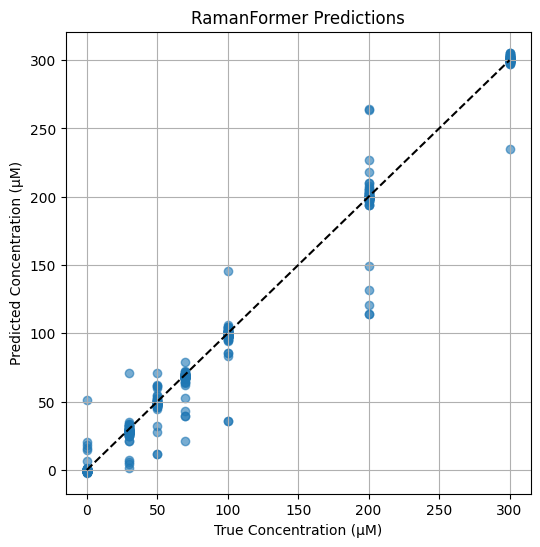

In [10]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_ramanformer.pth'))
preds, trues = validate(model, val_loader)

print('Final Metrics:')
print('MAE:', mean_absolute_error(trues, preds))
print('MSE:', mean_squared_error(trues, preds))
print('R2 :', r2_score(trues, preds))

from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_percentage_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**(0.5)
    mean_target = np.mean(np.abs(y_true))
    mae_pct = 100 * mae / mean_target
    rmse_pct = 100 * rmse / mean_target
    return mae, rmse, mae_pct, rmse_pct

mae, rmse, mae_pct, rmse_pct = compute_percentage_errors(trues, preds)

print(f"Final MAE = {mae:.4f} ({mae_pct:.2f}%)")
print(f"Final RMSE = {rmse:.4f} ({rmse_pct:.2f}%)")


# Scatter plot: predicted vs true
plt.figure(figsize=(6,6))
plt.scatter(trues, preds, alpha=0.6)
mn, mx = trues.min(), trues.max()
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Concentration (µM)')
plt.ylabel('Predicted Concentration (µM)')
plt.title('RamanFormer Predictions')
plt.grid(True)
plt.show()

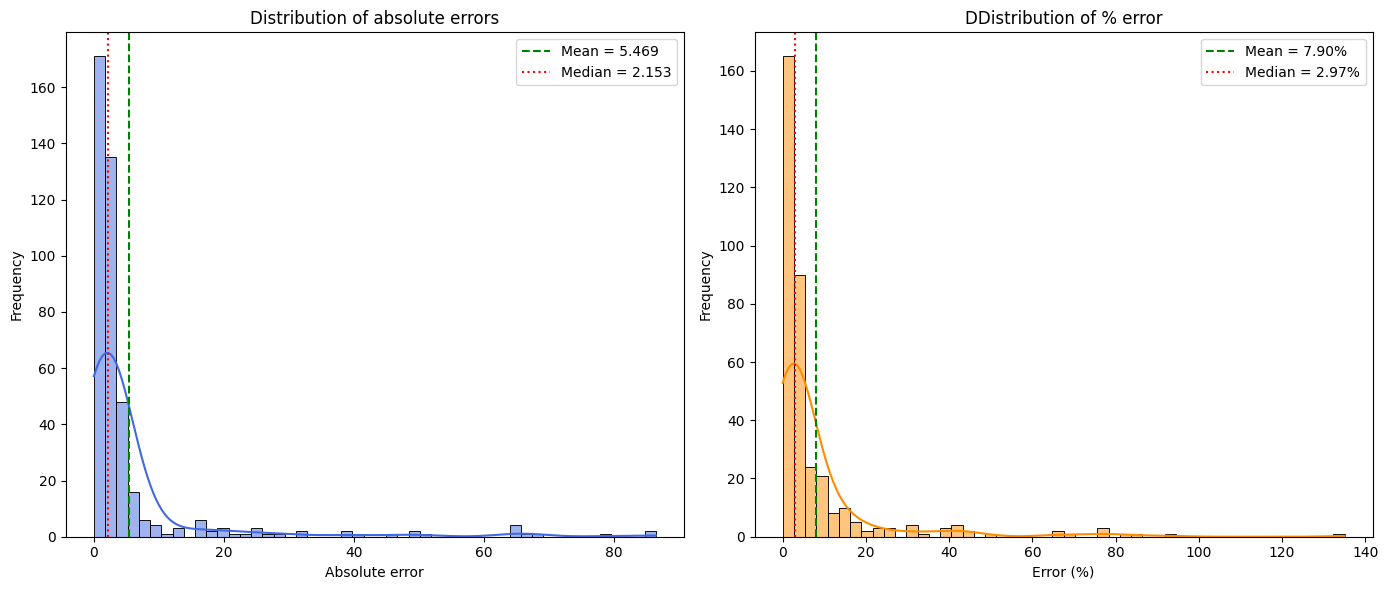

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcolo errori assoluti
abs_errors = np.abs(preds_val - trues_val)

# Maschera per filtrare target = 0
mask = trues_val != 0
filtered_abs_errors = abs_errors[mask]
filtered_trues = trues_val[mask]
percent_errors = 100 * filtered_abs_errors / np.abs(filtered_trues)

# Statistiche
mean_abs = np.mean(abs_errors)
median_abs = np.median(abs_errors)
mean_pct = np.mean(percent_errors)
median_pct = np.median(percent_errors)

# Plot
plt.figure(figsize=(14, 6))

# --- Plot errore assoluto ---
plt.subplot(1, 2, 1)
sns.histplot(abs_errors, bins=50, kde=True, color='royalblue')
plt.axvline(mean_abs, color='green', linestyle='--', label=f'Mean = {mean_abs:.3f}')
plt.axvline(median_abs, color='red', linestyle=':', label=f'Median = {median_abs:.3f}')
plt.xlabel("Absolute error")
plt.ylabel("Frequency")
plt.title("Distribution of absolute errors")
plt.legend()

# --- Plot errore percentuale ---
plt.subplot(1, 2, 2)
sns.histplot(percent_errors, bins=50, kde=True, color='darkorange')
plt.axvline(mean_pct, color='green', linestyle='--', label=f'Mean = {mean_pct:.2f}%')
plt.axvline(median_pct, color='red', linestyle=':', label=f'Median = {median_pct:.2f}%')
plt.xlabel("Error (%)")
plt.ylabel("Frequency")
plt.title("DDistribution of % error")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
class SpecNet1D(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16,  kernel_size=9, padding=4), nn.BatchNorm1d(16),  nn.ReLU(),
            nn.Conv1d(16,32,  kernel_size=7, padding=3), nn.BatchNorm1d(32),  nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32,64,  kernel_size=5, padding=2), nn.BatchNorm1d(64),  nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64,128, kernel_size=5, padding=2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.regressor = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)           # (B,1,L)
        x = self.features(x)         # (B,128,1)
        x = x.view(x.size(0), -1)    # (B,128)
        return self.regressor(x).squeeze(-1)

# Instantiate CNN
model_cnn = SpecNet1D(seq_len).to(device)
print(model_cnn)

SpecNet1D(
  (features): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_f

In [16]:
# Reuse previous criterion, optimizer, scheduler pattern
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler: CosineAnnealing decrescente fino a eta_min
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-6)

def train_specnet(model, loaders, epochs=100):
    model.to(device)
    best_mae = float('inf')
    history = {'train_loss':[], 'val_mae':[], 'val_mse':[], 'val_r2':[]}
    
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        running_loss = 0.0

        for x, t in loaders['train']:
            x, t = x.to(device), t.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(loaders['train'].dataset)

        model.eval()
        all_preds, all_trues = [], []
        with torch.no_grad():
            for x, t in loaders['val']:
                x, t = x.to(device), t.to(device)
                p = model(x)
                all_preds.append(p.cpu().numpy())
                all_trues.append(t.cpu().numpy())

        preds = np.concatenate(all_preds)
        trues = np.concatenate(all_trues)

        mae = mean_absolute_error(trues, preds)
        mse = mean_squared_error(trues, preds)
        r2  = r2_score(trues, preds)

        history['train_loss'].append(train_loss)
        history['val_mae'].append(mae)
        history['val_mse'].append(mse)
        history['val_r2'].append(r2)

        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), 'best_specnet.pth')

        scheduler.step()
        print(f"Epoch {epoch:03}: Train L1={train_loss:.4f} | Val MAE={mae:.4f} | MSE={mse:.4f} | R2={r2:.4f}")
    
    return history


In [17]:
data_loaders = {
    'train': DataLoader(train_ds, batch_size, shuffle=True),
    'val':   DataLoader(val_ds,   batch_size)
}

In [18]:
print('Training SpecNet1D...')
hist_cnn = train_specnet(model_cnn, data_loaders, epochs=1000)

Training SpecNet1D...


  0%|          | 2/1000 [00:00<03:33,  4.68it/s]

Epoch 001: Train L1=108.0092 | Val MAE=102.7473 | MSE=19875.1875 | R2=-1.1292
Epoch 002: Train L1=108.0096 | Val MAE=102.7522 | MSE=19876.9062 | R2=-1.1294


  0%|          | 4/1000 [00:00<03:05,  5.38it/s]

Epoch 003: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.6055 | R2=-1.1293
Epoch 004: Train L1=108.0096 | Val MAE=102.7484 | MSE=19875.7480 | R2=-1.1293


  1%|          | 6/1000 [00:01<03:02,  5.45it/s]

Epoch 005: Train L1=108.0094 | Val MAE=102.7468 | MSE=19875.2852 | R2=-1.1292
Epoch 006: Train L1=108.0093 | Val MAE=102.7464 | MSE=19875.1641 | R2=-1.1292


  1%|          | 8/1000 [00:01<02:56,  5.64it/s]

Epoch 007: Train L1=108.0096 | Val MAE=102.7500 | MSE=19876.1836 | R2=-1.1293
Epoch 008: Train L1=108.0093 | Val MAE=102.7469 | MSE=19875.3145 | R2=-1.1292


  1%|          | 10/1000 [00:01<02:55,  5.65it/s]

Epoch 009: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.5996 | R2=-1.1293
Epoch 010: Train L1=108.0095 | Val MAE=102.7474 | MSE=19875.4492 | R2=-1.1292


  1%|          | 12/1000 [00:02<02:54,  5.67it/s]

Epoch 011: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4824 | R2=-1.1292
Epoch 012: Train L1=108.0093 | Val MAE=102.7470 | MSE=19875.3262 | R2=-1.1292


  1%|▏         | 14/1000 [00:02<02:52,  5.71it/s]

Epoch 013: Train L1=108.0089 | Val MAE=102.7473 | MSE=19875.4102 | R2=-1.1292
Epoch 014: Train L1=108.0092 | Val MAE=102.7492 | MSE=19875.9648 | R2=-1.1293


  2%|▏         | 16/1000 [00:02<02:52,  5.70it/s]

Epoch 015: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.5977 | R2=-1.1293
Epoch 016: Train L1=108.0090 | Val MAE=102.7477 | MSE=19875.5527 | R2=-1.1293


  2%|▏         | 18/1000 [00:03<02:52,  5.71it/s]

Epoch 017: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4648 | R2=-1.1292
Epoch 018: Train L1=108.0094 | Val MAE=102.7508 | MSE=19876.4453 | R2=-1.1293


  2%|▏         | 20/1000 [00:03<02:50,  5.73it/s]

Epoch 019: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9570 | R2=-1.1293
Epoch 020: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2539 | R2=-1.1292


  2%|▏         | 22/1000 [00:03<02:50,  5.73it/s]

Epoch 021: Train L1=108.0095 | Val MAE=102.7495 | MSE=19876.0645 | R2=-1.1293
Epoch 022: Train L1=108.0095 | Val MAE=102.7464 | MSE=19875.1562 | R2=-1.1292


  2%|▏         | 24/1000 [00:04<02:53,  5.64it/s]

Epoch 023: Train L1=108.0093 | Val MAE=102.7458 | MSE=19874.9961 | R2=-1.1292
Epoch 024: Train L1=108.0092 | Val MAE=102.7470 | MSE=19875.3398 | R2=-1.1292


  3%|▎         | 26/1000 [00:04<02:51,  5.67it/s]

Epoch 025: Train L1=108.0095 | Val MAE=102.7495 | MSE=19876.0547 | R2=-1.1293
Epoch 026: Train L1=108.0092 | Val MAE=102.7465 | MSE=19875.1875 | R2=-1.1292


  3%|▎         | 28/1000 [00:05<02:51,  5.68it/s]

Epoch 027: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8555 | R2=-1.1293
Epoch 028: Train L1=108.0096 | Val MAE=102.7513 | MSE=19876.5801 | R2=-1.1294


  3%|▎         | 30/1000 [00:05<02:50,  5.70it/s]

Epoch 029: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8457 | R2=-1.1293
Epoch 030: Train L1=108.0093 | Val MAE=102.7497 | MSE=19876.1113 | R2=-1.1293


  3%|▎         | 32/1000 [00:05<02:50,  5.69it/s]

Epoch 031: Train L1=108.0094 | Val MAE=102.7490 | MSE=19875.9082 | R2=-1.1293
Epoch 032: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4922 | R2=-1.1292


  3%|▎         | 34/1000 [00:06<02:49,  5.71it/s]

Epoch 033: Train L1=108.0090 | Val MAE=102.7467 | MSE=19875.2578 | R2=-1.1292
Epoch 034: Train L1=108.0096 | Val MAE=102.7480 | MSE=19875.6328 | R2=-1.1293


  4%|▎         | 36/1000 [00:06<02:48,  5.71it/s]

Epoch 035: Train L1=108.0090 | Val MAE=102.7461 | MSE=19875.0859 | R2=-1.1292
Epoch 036: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4219 | R2=-1.1292


  4%|▍         | 38/1000 [00:06<02:48,  5.72it/s]

Epoch 037: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3496 | R2=-1.1292
Epoch 038: Train L1=108.0096 | Val MAE=102.7497 | MSE=19876.1016 | R2=-1.1293


  4%|▍         | 40/1000 [00:07<02:48,  5.71it/s]

Epoch 039: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6719 | R2=-1.1293
Epoch 040: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8242 | R2=-1.1293


  4%|▍         | 42/1000 [00:07<02:47,  5.72it/s]

Epoch 041: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8848 | R2=-1.1293
Epoch 042: Train L1=108.0092 | Val MAE=102.7510 | MSE=19876.5195 | R2=-1.1294


  4%|▍         | 44/1000 [00:07<02:46,  5.73it/s]

Epoch 043: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5742 | R2=-1.1293
Epoch 044: Train L1=108.0092 | Val MAE=102.7490 | MSE=19875.9043 | R2=-1.1293


  5%|▍         | 46/1000 [00:08<02:46,  5.73it/s]

Epoch 045: Train L1=108.0094 | Val MAE=102.7469 | MSE=19875.3047 | R2=-1.1292
Epoch 046: Train L1=108.0096 | Val MAE=102.7481 | MSE=19875.6602 | R2=-1.1293


  5%|▍         | 48/1000 [00:08<02:46,  5.73it/s]

Epoch 047: Train L1=108.0091 | Val MAE=102.7484 | MSE=19875.7578 | R2=-1.1293
Epoch 048: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.4062 | R2=-1.1292


  5%|▌         | 50/1000 [00:08<02:45,  5.72it/s]

Epoch 049: Train L1=108.0091 | Val MAE=102.7480 | MSE=19875.6016 | R2=-1.1293
Epoch 050: Train L1=108.0091 | Val MAE=102.7475 | MSE=19875.4863 | R2=-1.1292


  5%|▌         | 52/1000 [00:09<02:45,  5.72it/s]

Epoch 051: Train L1=108.0097 | Val MAE=102.7485 | MSE=19875.7734 | R2=-1.1293
Epoch 052: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9570 | R2=-1.1293


  5%|▌         | 54/1000 [00:09<02:45,  5.73it/s]

Epoch 053: Train L1=108.0093 | Val MAE=102.7468 | MSE=19875.2734 | R2=-1.1292
Epoch 054: Train L1=108.0096 | Val MAE=102.7496 | MSE=19876.0879 | R2=-1.1293


  6%|▌         | 56/1000 [00:09<02:45,  5.70it/s]

Epoch 055: Train L1=108.0096 | Val MAE=102.7500 | MSE=19876.2129 | R2=-1.1293
Epoch 056: Train L1=108.0092 | Val MAE=102.7467 | MSE=19875.2500 | R2=-1.1292


  6%|▌         | 58/1000 [00:10<02:45,  5.70it/s]

Epoch 057: Train L1=108.0088 | Val MAE=102.7490 | MSE=19875.9160 | R2=-1.1293
Epoch 058: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.3770 | R2=-1.1292


  6%|▌         | 60/1000 [00:10<02:45,  5.69it/s]

Epoch 059: Train L1=108.0092 | Val MAE=102.7520 | MSE=19876.7988 | R2=-1.1294
Epoch 060: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4648 | R2=-1.1292


  6%|▌         | 62/1000 [00:10<02:44,  5.69it/s]

Epoch 061: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6758 | R2=-1.1293
Epoch 062: Train L1=108.0094 | Val MAE=102.7500 | MSE=19876.2207 | R2=-1.1293


  6%|▋         | 64/1000 [00:11<02:44,  5.70it/s]

Epoch 063: Train L1=108.0093 | Val MAE=102.7512 | MSE=19876.5527 | R2=-1.1294
Epoch 064: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5703 | R2=-1.1293


  7%|▋         | 66/1000 [00:11<02:43,  5.71it/s]

Epoch 065: Train L1=108.0090 | Val MAE=102.7486 | MSE=19875.7832 | R2=-1.1293
Epoch 066: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.6230 | R2=-1.1293


  7%|▋         | 68/1000 [00:12<02:42,  5.73it/s]

Epoch 067: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8398 | R2=-1.1293
Epoch 068: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5664 | R2=-1.1293


  7%|▋         | 70/1000 [00:12<02:42,  5.72it/s]

Epoch 069: Train L1=108.0092 | Val MAE=102.7494 | MSE=19876.0098 | R2=-1.1293
Epoch 070: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4453 | R2=-1.1292


  7%|▋         | 72/1000 [00:12<02:42,  5.72it/s]

Epoch 071: Train L1=108.0094 | Val MAE=102.7466 | MSE=19875.2051 | R2=-1.1292
Epoch 072: Train L1=108.0089 | Val MAE=102.7513 | MSE=19876.5840 | R2=-1.1294


  7%|▋         | 74/1000 [00:13<02:41,  5.72it/s]

Epoch 073: Train L1=108.0096 | Val MAE=102.7480 | MSE=19875.6289 | R2=-1.1293
Epoch 074: Train L1=108.0095 | Val MAE=102.7472 | MSE=19875.4023 | R2=-1.1292


  8%|▊         | 76/1000 [00:13<02:41,  5.73it/s]

Epoch 075: Train L1=108.0091 | Val MAE=102.7501 | MSE=19876.2207 | R2=-1.1293
Epoch 076: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8496 | R2=-1.1293


  8%|▊         | 78/1000 [00:13<02:39,  5.77it/s]

Epoch 077: Train L1=108.0096 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292
Epoch 078: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


  8%|▊         | 80/1000 [00:14<02:38,  5.81it/s]

Epoch 079: Train L1=108.0094 | Val MAE=102.7498 | MSE=19876.1445 | R2=-1.1293
Epoch 080: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8184 | R2=-1.1293


  8%|▊         | 82/1000 [00:14<02:36,  5.85it/s]

Epoch 081: Train L1=108.0093 | Val MAE=102.7476 | MSE=19875.5020 | R2=-1.1292
Epoch 082: Train L1=108.0091 | Val MAE=102.7470 | MSE=19875.3398 | R2=-1.1292


  8%|▊         | 84/1000 [00:14<02:36,  5.85it/s]

Epoch 083: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6934 | R2=-1.1293
Epoch 084: Train L1=108.0094 | Val MAE=102.7477 | MSE=19875.5527 | R2=-1.1293


  9%|▊         | 86/1000 [00:15<02:35,  5.87it/s]

Epoch 085: Train L1=108.0090 | Val MAE=102.7473 | MSE=19875.4160 | R2=-1.1292
Epoch 086: Train L1=108.0094 | Val MAE=102.7490 | MSE=19875.9121 | R2=-1.1293


  9%|▉         | 88/1000 [00:15<02:35,  5.86it/s]

Epoch 087: Train L1=108.0095 | Val MAE=102.7480 | MSE=19875.6191 | R2=-1.1293
Epoch 088: Train L1=108.0092 | Val MAE=102.7501 | MSE=19876.2461 | R2=-1.1293


  9%|▉         | 90/1000 [00:15<02:35,  5.86it/s]

Epoch 089: Train L1=108.0092 | Val MAE=102.7497 | MSE=19876.1328 | R2=-1.1293
Epoch 090: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.8027 | R2=-1.1293


  9%|▉         | 92/1000 [00:16<02:34,  5.86it/s]

Epoch 091: Train L1=108.0092 | Val MAE=102.7463 | MSE=19875.1484 | R2=-1.1292
Epoch 092: Train L1=108.0094 | Val MAE=102.7502 | MSE=19876.2793 | R2=-1.1293


  9%|▉         | 94/1000 [00:16<02:34,  5.88it/s]

Epoch 093: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293
Epoch 094: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7148 | R2=-1.1293


 10%|▉         | 96/1000 [00:16<02:34,  5.86it/s]

Epoch 095: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.6055 | R2=-1.1293
Epoch 096: Train L1=108.0092 | Val MAE=102.7467 | MSE=19875.2520 | R2=-1.1292


 10%|▉         | 98/1000 [00:17<02:34,  5.84it/s]

Epoch 097: Train L1=108.0095 | Val MAE=102.7510 | MSE=19876.4902 | R2=-1.1294
Epoch 098: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6465 | R2=-1.1293


 10%|█         | 100/1000 [00:17<02:36,  5.76it/s]

Epoch 099: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.9004 | R2=-1.1293
Epoch 100: Train L1=108.0094 | Val MAE=102.7450 | MSE=19874.7363 | R2=-1.1292


 10%|█         | 102/1000 [00:17<02:35,  5.79it/s]

Epoch 101: Train L1=108.0094 | Val MAE=102.7459 | MSE=19875.0098 | R2=-1.1292
Epoch 102: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6660 | R2=-1.1293


 10%|█         | 104/1000 [00:18<02:33,  5.83it/s]

Epoch 103: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4258 | R2=-1.1292
Epoch 104: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6719 | R2=-1.1293


 11%|█         | 106/1000 [00:18<02:32,  5.85it/s]

Epoch 105: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4355 | R2=-1.1292
Epoch 106: Train L1=108.0093 | Val MAE=102.7480 | MSE=19875.5996 | R2=-1.1293


 11%|█         | 108/1000 [00:18<02:32,  5.87it/s]

Epoch 107: Train L1=108.0096 | Val MAE=102.7493 | MSE=19875.9961 | R2=-1.1293
Epoch 108: Train L1=108.0093 | Val MAE=102.7476 | MSE=19875.5137 | R2=-1.1292


 11%|█         | 110/1000 [00:19<02:31,  5.87it/s]

Epoch 109: Train L1=108.0096 | Val MAE=102.7477 | MSE=19875.5664 | R2=-1.1293
Epoch 110: Train L1=108.0093 | Val MAE=102.7465 | MSE=19875.2090 | R2=-1.1292


 11%|█         | 112/1000 [00:19<02:31,  5.88it/s]

Epoch 111: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4375 | R2=-1.1292
Epoch 112: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8379 | R2=-1.1293


 11%|█▏        | 114/1000 [00:19<02:31,  5.86it/s]

Epoch 113: Train L1=108.0094 | Val MAE=102.7459 | MSE=19875.0078 | R2=-1.1292
Epoch 114: Train L1=108.0095 | Val MAE=102.7491 | MSE=19875.9473 | R2=-1.1293


 12%|█▏        | 116/1000 [00:20<02:30,  5.87it/s]

Epoch 115: Train L1=108.0092 | Val MAE=102.7467 | MSE=19875.2344 | R2=-1.1292
Epoch 116: Train L1=108.0093 | Val MAE=102.7491 | MSE=19875.9453 | R2=-1.1293


 12%|█▏        | 118/1000 [00:20<02:29,  5.88it/s]

Epoch 117: Train L1=108.0095 | Val MAE=102.7495 | MSE=19876.0352 | R2=-1.1293
Epoch 118: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6562 | R2=-1.1293


 12%|█▏        | 120/1000 [00:20<02:29,  5.88it/s]

Epoch 119: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8398 | R2=-1.1293
Epoch 120: Train L1=108.0095 | Val MAE=102.7498 | MSE=19876.1602 | R2=-1.1293


 12%|█▏        | 122/1000 [00:21<02:29,  5.86it/s]

Epoch 121: Train L1=108.0093 | Val MAE=102.7481 | MSE=19875.6582 | R2=-1.1293
Epoch 122: Train L1=108.0095 | Val MAE=102.7469 | MSE=19875.2812 | R2=-1.1292


 12%|█▏        | 124/1000 [00:21<02:29,  5.86it/s]

Epoch 123: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3457 | R2=-1.1292
Epoch 124: Train L1=108.0095 | Val MAE=102.7494 | MSE=19876.0312 | R2=-1.1293


 13%|█▎        | 126/1000 [00:21<02:29,  5.86it/s]

Epoch 125: Train L1=108.0095 | Val MAE=102.7471 | MSE=19875.3535 | R2=-1.1292
Epoch 126: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.8184 | R2=-1.1293


 13%|█▎        | 128/1000 [00:22<02:28,  5.86it/s]

Epoch 127: Train L1=108.0096 | Val MAE=102.7479 | MSE=19875.5879 | R2=-1.1293
Epoch 128: Train L1=108.0091 | Val MAE=102.7517 | MSE=19876.7305 | R2=-1.1294


 13%|█▎        | 130/1000 [00:22<02:28,  5.84it/s]

Epoch 129: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.7344 | R2=-1.1293
Epoch 130: Train L1=108.0095 | Val MAE=102.7463 | MSE=19875.1328 | R2=-1.1292


 13%|█▎        | 132/1000 [00:22<02:28,  5.84it/s]

Epoch 131: Train L1=108.0094 | Val MAE=102.7488 | MSE=19875.8359 | R2=-1.1293
Epoch 132: Train L1=108.0097 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


 13%|█▎        | 134/1000 [00:23<02:28,  5.84it/s]

Epoch 133: Train L1=108.0096 | Val MAE=102.7477 | MSE=19875.5410 | R2=-1.1293
Epoch 134: Train L1=108.0092 | Val MAE=102.7479 | MSE=19875.6094 | R2=-1.1293


 14%|█▎        | 136/1000 [00:23<02:27,  5.84it/s]

Epoch 135: Train L1=108.0095 | Val MAE=102.7491 | MSE=19875.9316 | R2=-1.1293
Epoch 136: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8926 | R2=-1.1293


 14%|█▍        | 138/1000 [00:24<02:27,  5.86it/s]

Epoch 137: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6621 | R2=-1.1293
Epoch 138: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8125 | R2=-1.1293


 14%|█▍        | 140/1000 [00:24<02:26,  5.86it/s]

Epoch 139: Train L1=108.0095 | Val MAE=102.7503 | MSE=19876.2832 | R2=-1.1293
Epoch 140: Train L1=108.0091 | Val MAE=102.7492 | MSE=19875.9824 | R2=-1.1293


 14%|█▍        | 142/1000 [00:24<02:26,  5.87it/s]

Epoch 141: Train L1=108.0092 | Val MAE=102.7488 | MSE=19875.8555 | R2=-1.1293
Epoch 142: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8770 | R2=-1.1293


 14%|█▍        | 144/1000 [00:25<02:26,  5.85it/s]

Epoch 143: Train L1=108.0092 | Val MAE=102.7492 | MSE=19875.9863 | R2=-1.1293
Epoch 144: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9883 | R2=-1.1293


 15%|█▍        | 146/1000 [00:25<02:25,  5.86it/s]

Epoch 145: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4570 | R2=-1.1292
Epoch 146: Train L1=108.0092 | Val MAE=102.7490 | MSE=19875.8887 | R2=-1.1293


 15%|█▍        | 148/1000 [00:25<02:25,  5.86it/s]

Epoch 147: Train L1=108.0092 | Val MAE=102.7493 | MSE=19875.9883 | R2=-1.1293
Epoch 148: Train L1=108.0091 | Val MAE=102.7489 | MSE=19875.8613 | R2=-1.1293


 15%|█▌        | 150/1000 [00:26<02:24,  5.87it/s]

Epoch 149: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4805 | R2=-1.1292
Epoch 150: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7676 | R2=-1.1293


 15%|█▌        | 152/1000 [00:26<02:24,  5.88it/s]

Epoch 151: Train L1=108.0090 | Val MAE=102.7469 | MSE=19875.2793 | R2=-1.1292
Epoch 152: Train L1=108.0093 | Val MAE=102.7463 | MSE=19875.1504 | R2=-1.1292


 15%|█▌        | 154/1000 [00:26<02:23,  5.89it/s]

Epoch 153: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7891 | R2=-1.1293
Epoch 154: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4688 | R2=-1.1292


 16%|█▌        | 156/1000 [00:27<02:23,  5.90it/s]

Epoch 155: Train L1=108.0096 | Val MAE=102.7488 | MSE=19875.8613 | R2=-1.1293
Epoch 156: Train L1=108.0095 | Val MAE=102.7493 | MSE=19876.0234 | R2=-1.1293


 16%|█▌        | 158/1000 [00:27<02:22,  5.90it/s]

Epoch 157: Train L1=108.0091 | Val MAE=102.7513 | MSE=19876.5840 | R2=-1.1294
Epoch 158: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7363 | R2=-1.1293


 16%|█▌        | 160/1000 [00:27<02:23,  5.87it/s]

Epoch 159: Train L1=108.0095 | Val MAE=102.7500 | MSE=19876.2070 | R2=-1.1293
Epoch 160: Train L1=108.0096 | Val MAE=102.7496 | MSE=19876.0957 | R2=-1.1293


 16%|█▌        | 162/1000 [00:28<02:23,  5.86it/s]

Epoch 161: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5898 | R2=-1.1293
Epoch 162: Train L1=108.0092 | Val MAE=102.7458 | MSE=19875.0020 | R2=-1.1292


 16%|█▋        | 164/1000 [00:28<02:22,  5.88it/s]

Epoch 163: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.7969 | R2=-1.1293
Epoch 164: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6914 | R2=-1.1293


 17%|█▋        | 166/1000 [00:28<02:23,  5.80it/s]

Epoch 165: Train L1=108.0095 | Val MAE=102.7477 | MSE=19875.5195 | R2=-1.1292
Epoch 166: Train L1=108.0093 | Val MAE=102.7456 | MSE=19874.9219 | R2=-1.1292


 17%|█▋        | 168/1000 [00:29<02:24,  5.78it/s]

Epoch 167: Train L1=108.0089 | Val MAE=102.7458 | MSE=19874.9980 | R2=-1.1292
Epoch 168: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.6309 | R2=-1.1293


 17%|█▋        | 170/1000 [00:29<02:23,  5.80it/s]

Epoch 169: Train L1=108.0093 | Val MAE=102.7491 | MSE=19875.9297 | R2=-1.1293
Epoch 170: Train L1=108.0095 | Val MAE=102.7484 | MSE=19875.7246 | R2=-1.1293


 17%|█▋        | 172/1000 [00:29<02:21,  5.84it/s]

Epoch 171: Train L1=108.0094 | Val MAE=102.7489 | MSE=19875.8770 | R2=-1.1293
Epoch 172: Train L1=108.0091 | Val MAE=102.7478 | MSE=19875.5781 | R2=-1.1293


 17%|█▋        | 174/1000 [00:30<02:21,  5.85it/s]

Epoch 173: Train L1=108.0095 | Val MAE=102.7472 | MSE=19875.4023 | R2=-1.1292
Epoch 174: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3535 | R2=-1.1292


 18%|█▊        | 176/1000 [00:30<02:21,  5.84it/s]

Epoch 175: Train L1=108.0092 | Val MAE=102.7493 | MSE=19876.0059 | R2=-1.1293
Epoch 176: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.6367 | R2=-1.1293


 18%|█▊        | 178/1000 [00:30<02:20,  5.84it/s]

Epoch 177: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.7812 | R2=-1.1293
Epoch 178: Train L1=108.0089 | Val MAE=102.7493 | MSE=19875.9961 | R2=-1.1293


 18%|█▊        | 180/1000 [00:31<02:20,  5.85it/s]

Epoch 179: Train L1=108.0091 | Val MAE=102.7495 | MSE=19876.0781 | R2=-1.1293
Epoch 180: Train L1=108.0090 | Val MAE=102.7488 | MSE=19875.8555 | R2=-1.1293


 18%|█▊        | 182/1000 [00:31<02:19,  5.86it/s]

Epoch 181: Train L1=108.0091 | Val MAE=102.7492 | MSE=19875.9609 | R2=-1.1293
Epoch 182: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5859 | R2=-1.1293


 18%|█▊        | 184/1000 [00:31<02:19,  5.85it/s]

Epoch 183: Train L1=108.0092 | Val MAE=102.7486 | MSE=19875.8145 | R2=-1.1293
Epoch 184: Train L1=108.0097 | Val MAE=102.7486 | MSE=19875.8105 | R2=-1.1293


 19%|█▊        | 186/1000 [00:32<02:19,  5.85it/s]

Epoch 185: Train L1=108.0090 | Val MAE=102.7484 | MSE=19875.7285 | R2=-1.1293
Epoch 186: Train L1=108.0094 | Val MAE=102.7466 | MSE=19875.2090 | R2=-1.1292


 19%|█▉        | 188/1000 [00:32<02:18,  5.86it/s]

Epoch 187: Train L1=108.0096 | Val MAE=102.7483 | MSE=19875.7188 | R2=-1.1293
Epoch 188: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.4062 | R2=-1.1292


 19%|█▉        | 190/1000 [00:32<02:19,  5.82it/s]

Epoch 189: Train L1=108.0094 | Val MAE=102.7489 | MSE=19875.8965 | R2=-1.1293
Epoch 190: Train L1=108.0092 | Val MAE=102.7497 | MSE=19876.1152 | R2=-1.1293


 19%|█▉        | 192/1000 [00:33<02:20,  5.77it/s]

Epoch 191: Train L1=108.0095 | Val MAE=102.7498 | MSE=19876.1641 | R2=-1.1293
Epoch 192: Train L1=108.0095 | Val MAE=102.7458 | MSE=19874.9902 | R2=-1.1292


 19%|█▉        | 194/1000 [00:33<02:20,  5.75it/s]

Epoch 193: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4609 | R2=-1.1292
Epoch 194: Train L1=108.0095 | Val MAE=102.7516 | MSE=19876.6562 | R2=-1.1294


 20%|█▉        | 196/1000 [00:33<02:20,  5.73it/s]

Epoch 195: Train L1=108.0093 | Val MAE=102.7491 | MSE=19875.9395 | R2=-1.1293
Epoch 196: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.6035 | R2=-1.1293


 20%|█▉        | 198/1000 [00:34<02:20,  5.72it/s]

Epoch 197: Train L1=108.0095 | Val MAE=102.7476 | MSE=19875.5137 | R2=-1.1292
Epoch 198: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9863 | R2=-1.1293


 20%|██        | 200/1000 [00:34<02:19,  5.72it/s]

Epoch 199: Train L1=108.0095 | Val MAE=102.7476 | MSE=19875.5098 | R2=-1.1292
Epoch 200: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.8164 | R2=-1.1293


 20%|██        | 202/1000 [00:34<02:19,  5.72it/s]

Epoch 201: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.4043 | R2=-1.1292
Epoch 202: Train L1=108.0093 | Val MAE=102.7505 | MSE=19876.3555 | R2=-1.1293


 20%|██        | 204/1000 [00:35<02:18,  5.73it/s]

Epoch 203: Train L1=108.0096 | Val MAE=102.7468 | MSE=19875.2715 | R2=-1.1292
Epoch 204: Train L1=108.0091 | Val MAE=102.7472 | MSE=19875.4023 | R2=-1.1292


 21%|██        | 206/1000 [00:35<02:16,  5.80it/s]

Epoch 205: Train L1=108.0092 | Val MAE=102.7502 | MSE=19876.2812 | R2=-1.1293
Epoch 206: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.6855 | R2=-1.1293


 21%|██        | 208/1000 [00:36<02:15,  5.83it/s]

Epoch 207: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8086 | R2=-1.1293
Epoch 208: Train L1=108.0094 | Val MAE=102.7496 | MSE=19876.1172 | R2=-1.1293


 21%|██        | 210/1000 [00:36<02:14,  5.86it/s]

Epoch 209: Train L1=108.0096 | Val MAE=102.7513 | MSE=19876.5625 | R2=-1.1294
Epoch 210: Train L1=108.0094 | Val MAE=102.7477 | MSE=19875.5293 | R2=-1.1293


 21%|██        | 212/1000 [00:36<02:14,  5.87it/s]

Epoch 211: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4727 | R2=-1.1292
Epoch 212: Train L1=108.0093 | Val MAE=102.7465 | MSE=19875.1934 | R2=-1.1292


 21%|██▏       | 214/1000 [00:37<02:15,  5.82it/s]

Epoch 213: Train L1=108.0092 | Val MAE=102.7478 | MSE=19875.5508 | R2=-1.1293
Epoch 214: Train L1=108.0096 | Val MAE=102.7495 | MSE=19876.0547 | R2=-1.1293


 22%|██▏       | 216/1000 [00:37<02:15,  5.77it/s]

Epoch 215: Train L1=108.0092 | Val MAE=102.7476 | MSE=19875.5078 | R2=-1.1292
Epoch 216: Train L1=108.0094 | Val MAE=102.7524 | MSE=19876.9023 | R2=-1.1294


 22%|██▏       | 218/1000 [00:37<02:16,  5.74it/s]

Epoch 217: Train L1=108.0090 | Val MAE=102.7481 | MSE=19875.6602 | R2=-1.1293
Epoch 218: Train L1=108.0092 | Val MAE=102.7494 | MSE=19876.0254 | R2=-1.1293


 22%|██▏       | 220/1000 [00:38<02:15,  5.75it/s]

Epoch 219: Train L1=108.0091 | Val MAE=102.7498 | MSE=19876.1230 | R2=-1.1293
Epoch 220: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8555 | R2=-1.1293


 22%|██▏       | 222/1000 [00:38<02:15,  5.73it/s]

Epoch 221: Train L1=108.0093 | Val MAE=102.7501 | MSE=19876.2266 | R2=-1.1293
Epoch 222: Train L1=108.0095 | Val MAE=102.7477 | MSE=19875.5527 | R2=-1.1293


 22%|██▏       | 224/1000 [00:38<02:15,  5.74it/s]

Epoch 223: Train L1=108.0094 | Val MAE=102.7467 | MSE=19875.2617 | R2=-1.1292
Epoch 224: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3691 | R2=-1.1292


 23%|██▎       | 226/1000 [00:39<02:14,  5.74it/s]

Epoch 225: Train L1=108.0095 | Val MAE=102.7465 | MSE=19875.1914 | R2=-1.1292
Epoch 226: Train L1=108.0097 | Val MAE=102.7483 | MSE=19875.7148 | R2=-1.1293


 23%|██▎       | 228/1000 [00:39<02:14,  5.72it/s]

Epoch 227: Train L1=108.0095 | Val MAE=102.7471 | MSE=19875.3672 | R2=-1.1292
Epoch 228: Train L1=108.0090 | Val MAE=102.7459 | MSE=19875.0234 | R2=-1.1292


 23%|██▎       | 230/1000 [00:39<02:14,  5.72it/s]

Epoch 229: Train L1=108.0097 | Val MAE=102.7458 | MSE=19875.0020 | R2=-1.1292
Epoch 230: Train L1=108.0094 | Val MAE=102.7464 | MSE=19875.1582 | R2=-1.1292


 23%|██▎       | 232/1000 [00:40<02:14,  5.72it/s]

Epoch 231: Train L1=108.0094 | Val MAE=102.7469 | MSE=19875.3066 | R2=-1.1292
Epoch 232: Train L1=108.0090 | Val MAE=102.7488 | MSE=19875.8555 | R2=-1.1293


 23%|██▎       | 234/1000 [00:40<02:14,  5.70it/s]

Epoch 233: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7363 | R2=-1.1293
Epoch 234: Train L1=108.0095 | Val MAE=102.7494 | MSE=19876.0508 | R2=-1.1293


 24%|██▎       | 236/1000 [00:40<02:13,  5.72it/s]

Epoch 235: Train L1=108.0095 | Val MAE=102.7471 | MSE=19875.3770 | R2=-1.1292
Epoch 236: Train L1=108.0094 | Val MAE=102.7497 | MSE=19876.1289 | R2=-1.1293


 24%|██▍       | 238/1000 [00:41<02:13,  5.73it/s]

Epoch 237: Train L1=108.0094 | Val MAE=102.7504 | MSE=19876.3066 | R2=-1.1293
Epoch 238: Train L1=108.0093 | Val MAE=102.7462 | MSE=19875.1172 | R2=-1.1292


 24%|██▍       | 240/1000 [00:41<02:12,  5.72it/s]

Epoch 239: Train L1=108.0092 | Val MAE=102.7496 | MSE=19876.0898 | R2=-1.1293
Epoch 240: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.5781 | R2=-1.1293


 24%|██▍       | 242/1000 [00:41<02:12,  5.73it/s]

Epoch 241: Train L1=108.0096 | Val MAE=102.7485 | MSE=19875.7773 | R2=-1.1293
Epoch 242: Train L1=108.0096 | Val MAE=102.7478 | MSE=19875.5781 | R2=-1.1293


 24%|██▍       | 244/1000 [00:42<02:11,  5.74it/s]

Epoch 243: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5762 | R2=-1.1293
Epoch 244: Train L1=108.0092 | Val MAE=102.7472 | MSE=19875.4043 | R2=-1.1292


 25%|██▍       | 246/1000 [00:42<02:11,  5.73it/s]

Epoch 245: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.6641 | R2=-1.1293
Epoch 246: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4531 | R2=-1.1292


 25%|██▍       | 248/1000 [00:42<02:11,  5.73it/s]

Epoch 247: Train L1=108.0093 | Val MAE=102.7480 | MSE=19875.6191 | R2=-1.1293
Epoch 248: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4785 | R2=-1.1292


 25%|██▌       | 250/1000 [00:43<02:10,  5.74it/s]

Epoch 249: Train L1=108.0096 | Val MAE=102.7484 | MSE=19875.7207 | R2=-1.1293
Epoch 250: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.7070 | R2=-1.1293


 25%|██▌       | 252/1000 [00:43<02:10,  5.74it/s]

Epoch 251: Train L1=108.0094 | Val MAE=102.7497 | MSE=19876.1172 | R2=-1.1293
Epoch 252: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4707 | R2=-1.1292


 25%|██▌       | 254/1000 [00:44<02:10,  5.73it/s]

Epoch 253: Train L1=108.0095 | Val MAE=102.7487 | MSE=19875.8262 | R2=-1.1293
Epoch 254: Train L1=108.0093 | Val MAE=102.7481 | MSE=19875.6523 | R2=-1.1293


 26%|██▌       | 256/1000 [00:44<02:09,  5.73it/s]

Epoch 255: Train L1=108.0096 | Val MAE=102.7461 | MSE=19875.0664 | R2=-1.1292
Epoch 256: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.5938 | R2=-1.1293


 26%|██▌       | 258/1000 [00:44<02:09,  5.74it/s]

Epoch 257: Train L1=108.0091 | Val MAE=102.7507 | MSE=19876.3926 | R2=-1.1293
Epoch 258: Train L1=108.0093 | Val MAE=102.7494 | MSE=19876.0527 | R2=-1.1293


 26%|██▌       | 260/1000 [00:45<02:08,  5.74it/s]

Epoch 259: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7480 | R2=-1.1293
Epoch 260: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8477 | R2=-1.1293


 26%|██▌       | 262/1000 [00:45<02:08,  5.73it/s]

Epoch 261: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.7754 | R2=-1.1293
Epoch 262: Train L1=108.0088 | Val MAE=102.7475 | MSE=19875.4902 | R2=-1.1292


 26%|██▋       | 264/1000 [00:45<02:07,  5.78it/s]

Epoch 263: Train L1=108.0091 | Val MAE=102.7491 | MSE=19875.9434 | R2=-1.1293
Epoch 264: Train L1=108.0091 | Val MAE=102.7485 | MSE=19875.7539 | R2=-1.1293


 27%|██▋       | 266/1000 [00:46<02:06,  5.82it/s]

Epoch 265: Train L1=108.0094 | Val MAE=102.7493 | MSE=19875.9902 | R2=-1.1293
Epoch 266: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.5840 | R2=-1.1293


 27%|██▋       | 268/1000 [00:46<02:05,  5.84it/s]

Epoch 267: Train L1=108.0094 | Val MAE=102.7467 | MSE=19875.2520 | R2=-1.1292
Epoch 268: Train L1=108.0092 | Val MAE=102.7470 | MSE=19875.3379 | R2=-1.1292


 27%|██▋       | 270/1000 [00:46<02:04,  5.87it/s]

Epoch 269: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7051 | R2=-1.1293
Epoch 270: Train L1=108.0091 | Val MAE=102.7485 | MSE=19875.7520 | R2=-1.1293


 27%|██▋       | 272/1000 [00:47<02:03,  5.87it/s]

Epoch 271: Train L1=108.0092 | Val MAE=102.7494 | MSE=19876.0469 | R2=-1.1293
Epoch 272: Train L1=108.0092 | Val MAE=102.7473 | MSE=19875.4062 | R2=-1.1292


 27%|██▋       | 274/1000 [00:47<02:03,  5.88it/s]

Epoch 273: Train L1=108.0095 | Val MAE=102.7470 | MSE=19875.3652 | R2=-1.1292
Epoch 274: Train L1=108.0092 | Val MAE=102.7517 | MSE=19876.6992 | R2=-1.1294


 28%|██▊       | 276/1000 [00:47<02:03,  5.88it/s]

Epoch 275: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4648 | R2=-1.1292
Epoch 276: Train L1=108.0092 | Val MAE=102.7476 | MSE=19875.5195 | R2=-1.1292


 28%|██▊       | 278/1000 [00:48<02:02,  5.88it/s]

Epoch 277: Train L1=108.0094 | Val MAE=102.7477 | MSE=19875.4980 | R2=-1.1292
Epoch 278: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.8223 | R2=-1.1293


 28%|██▊       | 280/1000 [00:48<02:02,  5.88it/s]

Epoch 279: Train L1=108.0092 | Val MAE=102.7493 | MSE=19876.0039 | R2=-1.1293
Epoch 280: Train L1=108.0094 | Val MAE=102.7464 | MSE=19875.1738 | R2=-1.1292


 28%|██▊       | 282/1000 [00:48<02:02,  5.87it/s]

Epoch 281: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6445 | R2=-1.1293
Epoch 282: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6914 | R2=-1.1293


 28%|██▊       | 284/1000 [00:49<02:02,  5.85it/s]

Epoch 283: Train L1=108.0095 | Val MAE=102.7501 | MSE=19876.2363 | R2=-1.1293
Epoch 284: Train L1=108.0092 | Val MAE=102.7462 | MSE=19875.1113 | R2=-1.1292


 29%|██▊       | 286/1000 [00:49<02:01,  5.87it/s]

Epoch 285: Train L1=108.0096 | Val MAE=102.7466 | MSE=19875.2246 | R2=-1.1292
Epoch 286: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8691 | R2=-1.1293


 29%|██▉       | 288/1000 [00:49<02:01,  5.86it/s]

Epoch 287: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5762 | R2=-1.1293
Epoch 288: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4961 | R2=-1.1292


 29%|██▉       | 290/1000 [00:50<02:01,  5.86it/s]

Epoch 289: Train L1=108.0092 | Val MAE=102.7490 | MSE=19875.8789 | R2=-1.1293
Epoch 290: Train L1=108.0093 | Val MAE=102.7496 | MSE=19876.0684 | R2=-1.1293


 29%|██▉       | 292/1000 [00:50<02:00,  5.86it/s]

Epoch 291: Train L1=108.0096 | Val MAE=102.7463 | MSE=19875.1250 | R2=-1.1292
Epoch 292: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4043 | R2=-1.1292


 29%|██▉       | 294/1000 [00:50<02:00,  5.87it/s]

Epoch 293: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7461 | R2=-1.1293
Epoch 294: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6660 | R2=-1.1293


 30%|██▉       | 296/1000 [00:51<01:59,  5.87it/s]

Epoch 295: Train L1=108.0096 | Val MAE=102.7469 | MSE=19875.3066 | R2=-1.1292
Epoch 296: Train L1=108.0091 | Val MAE=102.7463 | MSE=19875.1230 | R2=-1.1292


 30%|██▉       | 298/1000 [00:51<01:59,  5.87it/s]

Epoch 297: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7480 | R2=-1.1293
Epoch 298: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6562 | R2=-1.1293


 30%|███       | 300/1000 [00:51<01:59,  5.85it/s]

Epoch 299: Train L1=108.0091 | Val MAE=102.7485 | MSE=19875.7637 | R2=-1.1293
Epoch 300: Train L1=108.0091 | Val MAE=102.7468 | MSE=19875.2949 | R2=-1.1292


 30%|███       | 302/1000 [00:52<01:59,  5.85it/s]

Epoch 301: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9375 | R2=-1.1293
Epoch 302: Train L1=108.0091 | Val MAE=102.7484 | MSE=19875.7617 | R2=-1.1293


 30%|███       | 304/1000 [00:52<01:59,  5.85it/s]

Epoch 303: Train L1=108.0094 | Val MAE=102.7470 | MSE=19875.3516 | R2=-1.1292
Epoch 304: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7305 | R2=-1.1293


 31%|███       | 306/1000 [00:52<01:58,  5.85it/s]

Epoch 305: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8477 | R2=-1.1293
Epoch 306: Train L1=108.0097 | Val MAE=102.7494 | MSE=19876.0469 | R2=-1.1293


 31%|███       | 308/1000 [00:53<01:58,  5.86it/s]

Epoch 307: Train L1=108.0092 | Val MAE=102.7470 | MSE=19875.3457 | R2=-1.1292
Epoch 308: Train L1=108.0092 | Val MAE=102.7454 | MSE=19874.8770 | R2=-1.1292


 31%|███       | 310/1000 [00:53<01:57,  5.87it/s]

Epoch 309: Train L1=108.0096 | Val MAE=102.7478 | MSE=19875.5625 | R2=-1.1293
Epoch 310: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4199 | R2=-1.1292


 31%|███       | 312/1000 [00:53<01:57,  5.87it/s]

Epoch 311: Train L1=108.0092 | Val MAE=102.7535 | MSE=19877.2383 | R2=-1.1294
Epoch 312: Train L1=108.0091 | Val MAE=102.7460 | MSE=19875.0391 | R2=-1.1292


 31%|███▏      | 314/1000 [00:54<01:56,  5.88it/s]

Epoch 313: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.6445 | R2=-1.1293
Epoch 314: Train L1=108.0097 | Val MAE=102.7473 | MSE=19875.4297 | R2=-1.1292


 32%|███▏      | 316/1000 [00:54<01:56,  5.86it/s]

Epoch 315: Train L1=108.0093 | Val MAE=102.7505 | MSE=19876.3535 | R2=-1.1293
Epoch 316: Train L1=108.0091 | Val MAE=102.7492 | MSE=19875.9727 | R2=-1.1293


 32%|███▏      | 318/1000 [00:54<01:56,  5.86it/s]

Epoch 317: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.5996 | R2=-1.1293
Epoch 318: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5508 | R2=-1.1293


 32%|███▏      | 320/1000 [00:55<01:55,  5.87it/s]

Epoch 319: Train L1=108.0095 | Val MAE=102.7494 | MSE=19876.0137 | R2=-1.1293
Epoch 320: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8184 | R2=-1.1293


 32%|███▏      | 322/1000 [00:55<01:55,  5.87it/s]

Epoch 321: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9395 | R2=-1.1293
Epoch 322: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8281 | R2=-1.1293


 32%|███▏      | 324/1000 [00:56<01:55,  5.86it/s]

Epoch 323: Train L1=108.0095 | Val MAE=102.7488 | MSE=19875.8516 | R2=-1.1293
Epoch 324: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


 33%|███▎      | 326/1000 [00:56<01:54,  5.86it/s]

Epoch 325: Train L1=108.0091 | Val MAE=102.7467 | MSE=19875.2324 | R2=-1.1292
Epoch 326: Train L1=108.0093 | Val MAE=102.7469 | MSE=19875.3008 | R2=-1.1292


 33%|███▎      | 328/1000 [00:56<01:54,  5.87it/s]

Epoch 327: Train L1=108.0092 | Val MAE=102.7469 | MSE=19875.2969 | R2=-1.1292
Epoch 328: Train L1=108.0094 | Val MAE=102.7509 | MSE=19876.4883 | R2=-1.1294


 33%|███▎      | 330/1000 [00:57<01:54,  5.83it/s]

Epoch 329: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.4004 | R2=-1.1292
Epoch 330: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5410 | R2=-1.1293


 33%|███▎      | 332/1000 [00:57<01:54,  5.85it/s]

Epoch 331: Train L1=108.0089 | Val MAE=102.7463 | MSE=19875.1309 | R2=-1.1292
Epoch 332: Train L1=108.0096 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 33%|███▎      | 334/1000 [00:57<01:54,  5.82it/s]

Epoch 333: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8281 | R2=-1.1293
Epoch 334: Train L1=108.0097 | Val MAE=102.7490 | MSE=19875.9160 | R2=-1.1293


 34%|███▎      | 336/1000 [00:58<01:54,  5.80it/s]

Epoch 335: Train L1=108.0097 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293
Epoch 336: Train L1=108.0093 | Val MAE=102.7500 | MSE=19876.1934 | R2=-1.1293


 34%|███▍      | 338/1000 [00:58<01:53,  5.83it/s]

Epoch 337: Train L1=108.0094 | Val MAE=102.7489 | MSE=19875.8828 | R2=-1.1293
Epoch 338: Train L1=108.0094 | Val MAE=102.7508 | MSE=19876.4492 | R2=-1.1293


 34%|███▍      | 340/1000 [00:58<01:52,  5.87it/s]

Epoch 339: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8320 | R2=-1.1293
Epoch 340: Train L1=108.0090 | Val MAE=102.7475 | MSE=19875.4746 | R2=-1.1292


 34%|███▍      | 342/1000 [00:59<01:52,  5.85it/s]

Epoch 341: Train L1=108.0095 | Val MAE=102.7479 | MSE=19875.5957 | R2=-1.1293
Epoch 342: Train L1=108.0093 | Val MAE=102.7493 | MSE=19876.0020 | R2=-1.1293


 34%|███▍      | 344/1000 [00:59<01:52,  5.84it/s]

Epoch 343: Train L1=108.0094 | Val MAE=102.7502 | MSE=19876.2539 | R2=-1.1293
Epoch 344: Train L1=108.0091 | Val MAE=102.7465 | MSE=19875.1836 | R2=-1.1292


 35%|███▍      | 346/1000 [00:59<01:51,  5.84it/s]

Epoch 345: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6504 | R2=-1.1293
Epoch 346: Train L1=108.0096 | Val MAE=102.7469 | MSE=19875.3086 | R2=-1.1292


 35%|███▍      | 348/1000 [01:00<01:51,  5.85it/s]

Epoch 347: Train L1=108.0092 | Val MAE=102.7460 | MSE=19875.0410 | R2=-1.1292
Epoch 348: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.7031 | R2=-1.1293


 35%|███▌      | 350/1000 [01:00<01:50,  5.87it/s]

Epoch 349: Train L1=108.0090 | Val MAE=102.7463 | MSE=19875.1230 | R2=-1.1292
Epoch 350: Train L1=108.0089 | Val MAE=102.7495 | MSE=19876.0723 | R2=-1.1293


 35%|███▌      | 352/1000 [01:00<01:50,  5.87it/s]

Epoch 351: Train L1=108.0093 | Val MAE=102.7485 | MSE=19875.7539 | R2=-1.1293
Epoch 352: Train L1=108.0095 | Val MAE=102.7461 | MSE=19875.0664 | R2=-1.1292


 35%|███▌      | 354/1000 [01:01<01:49,  5.88it/s]

Epoch 353: Train L1=108.0090 | Val MAE=102.7489 | MSE=19875.8770 | R2=-1.1293
Epoch 354: Train L1=108.0097 | Val MAE=102.7463 | MSE=19875.1328 | R2=-1.1292


 36%|███▌      | 356/1000 [01:01<01:49,  5.87it/s]

Epoch 355: Train L1=108.0094 | Val MAE=102.7465 | MSE=19875.1777 | R2=-1.1292
Epoch 356: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4102 | R2=-1.1292


 36%|███▌      | 358/1000 [01:01<01:49,  5.85it/s]

Epoch 357: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6406 | R2=-1.1293
Epoch 358: Train L1=108.0091 | Val MAE=102.7457 | MSE=19874.9570 | R2=-1.1292


 36%|███▌      | 360/1000 [01:02<01:48,  5.88it/s]

Epoch 359: Train L1=108.0090 | Val MAE=102.7481 | MSE=19875.6484 | R2=-1.1293
Epoch 360: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6309 | R2=-1.1293


 36%|███▌      | 362/1000 [01:02<01:48,  5.88it/s]

Epoch 361: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6445 | R2=-1.1293
Epoch 362: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5684 | R2=-1.1293


 36%|███▋      | 364/1000 [01:02<01:48,  5.87it/s]

Epoch 363: Train L1=108.0095 | Val MAE=102.7461 | MSE=19875.0840 | R2=-1.1292
Epoch 364: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3711 | R2=-1.1292


 37%|███▋      | 366/1000 [01:03<01:48,  5.87it/s]

Epoch 365: Train L1=108.0092 | Val MAE=102.7466 | MSE=19875.2266 | R2=-1.1292
Epoch 366: Train L1=108.0096 | Val MAE=102.7500 | MSE=19876.2109 | R2=-1.1293


 37%|███▋      | 368/1000 [01:03<01:47,  5.87it/s]

Epoch 367: Train L1=108.0096 | Val MAE=102.7457 | MSE=19874.9551 | R2=-1.1292
Epoch 368: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5625 | R2=-1.1293


 37%|███▋      | 370/1000 [01:03<01:47,  5.87it/s]

Epoch 369: Train L1=108.0090 | Val MAE=102.7496 | MSE=19876.0938 | R2=-1.1293
Epoch 370: Train L1=108.0090 | Val MAE=102.7498 | MSE=19876.1484 | R2=-1.1293


 37%|███▋      | 372/1000 [01:04<01:47,  5.86it/s]

Epoch 371: Train L1=108.0091 | Val MAE=102.7464 | MSE=19875.1660 | R2=-1.1292
Epoch 372: Train L1=108.0095 | Val MAE=102.7468 | MSE=19875.2695 | R2=-1.1292


 37%|███▋      | 374/1000 [01:04<01:46,  5.87it/s]

Epoch 373: Train L1=108.0094 | Val MAE=102.7505 | MSE=19876.3398 | R2=-1.1293
Epoch 374: Train L1=108.0094 | Val MAE=102.7500 | MSE=19876.2168 | R2=-1.1293


 38%|███▊      | 376/1000 [01:04<01:45,  5.89it/s]

Epoch 375: Train L1=108.0095 | Val MAE=102.7462 | MSE=19875.1094 | R2=-1.1292
Epoch 376: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.6152 | R2=-1.1293


 38%|███▊      | 378/1000 [01:05<01:45,  5.90it/s]

Epoch 377: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6699 | R2=-1.1293
Epoch 378: Train L1=108.0091 | Val MAE=102.7467 | MSE=19875.2676 | R2=-1.1292


 38%|███▊      | 380/1000 [01:05<01:45,  5.90it/s]

Epoch 379: Train L1=108.0092 | Val MAE=102.7457 | MSE=19874.9609 | R2=-1.1292
Epoch 380: Train L1=108.0096 | Val MAE=102.7478 | MSE=19875.5586 | R2=-1.1293


 38%|███▊      | 382/1000 [01:05<01:44,  5.89it/s]

Epoch 381: Train L1=108.0091 | Val MAE=102.7506 | MSE=19876.3926 | R2=-1.1293
Epoch 382: Train L1=108.0095 | Val MAE=102.7477 | MSE=19875.5449 | R2=-1.1293


 38%|███▊      | 384/1000 [01:06<01:44,  5.88it/s]

Epoch 383: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.5957 | R2=-1.1293
Epoch 384: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9336 | R2=-1.1293


 39%|███▊      | 386/1000 [01:06<01:44,  5.88it/s]

Epoch 385: Train L1=108.0093 | Val MAE=102.7476 | MSE=19875.5078 | R2=-1.1292
Epoch 386: Train L1=108.0092 | Val MAE=102.7493 | MSE=19876.0137 | R2=-1.1293


 39%|███▉      | 388/1000 [01:06<01:44,  5.88it/s]

Epoch 387: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.3828 | R2=-1.1292
Epoch 388: Train L1=108.0091 | Val MAE=102.7461 | MSE=19875.0645 | R2=-1.1292


 39%|███▉      | 390/1000 [01:07<01:43,  5.89it/s]

Epoch 389: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7285 | R2=-1.1293
Epoch 390: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8945 | R2=-1.1293


 39%|███▉      | 392/1000 [01:07<01:43,  5.86it/s]

Epoch 391: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8711 | R2=-1.1293
Epoch 392: Train L1=108.0092 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293


 39%|███▉      | 394/1000 [01:07<01:43,  5.87it/s]

Epoch 393: Train L1=108.0092 | Val MAE=102.7497 | MSE=19876.1387 | R2=-1.1293
Epoch 394: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4766 | R2=-1.1292


 40%|███▉      | 396/1000 [01:08<01:43,  5.85it/s]

Epoch 395: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4395 | R2=-1.1292
Epoch 396: Train L1=108.0093 | Val MAE=102.7461 | MSE=19875.0762 | R2=-1.1292


 40%|███▉      | 398/1000 [01:08<01:42,  5.87it/s]

Epoch 397: Train L1=108.0093 | Val MAE=102.7480 | MSE=19875.6074 | R2=-1.1293
Epoch 398: Train L1=108.0096 | Val MAE=102.7484 | MSE=19875.7383 | R2=-1.1293


 40%|████      | 400/1000 [01:08<01:42,  5.88it/s]

Epoch 399: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8223 | R2=-1.1293
Epoch 400: Train L1=108.0091 | Val MAE=102.7532 | MSE=19877.1484 | R2=-1.1294


 40%|████      | 402/1000 [01:09<01:41,  5.87it/s]

Epoch 401: Train L1=108.0093 | Val MAE=102.7470 | MSE=19875.3398 | R2=-1.1292
Epoch 402: Train L1=108.0092 | Val MAE=102.7495 | MSE=19876.0312 | R2=-1.1293


 40%|████      | 404/1000 [01:09<01:41,  5.85it/s]

Epoch 403: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292
Epoch 404: Train L1=108.0093 | Val MAE=102.7469 | MSE=19875.2949 | R2=-1.1292


 41%|████      | 406/1000 [01:09<01:41,  5.85it/s]

Epoch 405: Train L1=108.0091 | Val MAE=102.7472 | MSE=19875.4102 | R2=-1.1292
Epoch 406: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7363 | R2=-1.1293


 41%|████      | 408/1000 [01:10<01:40,  5.88it/s]

Epoch 407: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4805 | R2=-1.1292
Epoch 408: Train L1=108.0095 | Val MAE=102.7490 | MSE=19875.8945 | R2=-1.1293


 41%|████      | 410/1000 [01:10<01:40,  5.86it/s]

Epoch 409: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.5996 | R2=-1.1293
Epoch 410: Train L1=108.0091 | Val MAE=102.7483 | MSE=19875.7148 | R2=-1.1293


 41%|████      | 412/1000 [01:11<01:40,  5.86it/s]

Epoch 411: Train L1=108.0092 | Val MAE=102.7469 | MSE=19875.3086 | R2=-1.1292
Epoch 412: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.8066 | R2=-1.1293


 41%|████▏     | 414/1000 [01:11<01:40,  5.85it/s]

Epoch 413: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8496 | R2=-1.1293
Epoch 414: Train L1=108.0096 | Val MAE=102.7502 | MSE=19876.2734 | R2=-1.1293


 42%|████▏     | 416/1000 [01:11<01:39,  5.86it/s]

Epoch 415: Train L1=108.0090 | Val MAE=102.7506 | MSE=19876.3789 | R2=-1.1293
Epoch 416: Train L1=108.0096 | Val MAE=102.7492 | MSE=19875.9785 | R2=-1.1293


 42%|████▏     | 418/1000 [01:12<01:38,  5.88it/s]

Epoch 417: Train L1=108.0094 | Val MAE=102.7490 | MSE=19875.8926 | R2=-1.1293
Epoch 418: Train L1=108.0095 | Val MAE=102.7469 | MSE=19875.3027 | R2=-1.1292


 42%|████▏     | 420/1000 [01:12<01:38,  5.90it/s]

Epoch 419: Train L1=108.0091 | Val MAE=102.7488 | MSE=19875.8418 | R2=-1.1293
Epoch 420: Train L1=108.0091 | Val MAE=102.7471 | MSE=19875.3613 | R2=-1.1292


 42%|████▏     | 422/1000 [01:12<01:38,  5.88it/s]

Epoch 421: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292
Epoch 422: Train L1=108.0090 | Val MAE=102.7477 | MSE=19875.5605 | R2=-1.1293


 42%|████▏     | 424/1000 [01:13<01:37,  5.88it/s]

Epoch 423: Train L1=108.0093 | Val MAE=102.7513 | MSE=19876.5918 | R2=-1.1294
Epoch 424: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.6953 | R2=-1.1293


 43%|████▎     | 426/1000 [01:13<01:37,  5.87it/s]

Epoch 425: Train L1=108.0092 | Val MAE=102.7463 | MSE=19875.1289 | R2=-1.1292
Epoch 426: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5859 | R2=-1.1293


 43%|████▎     | 428/1000 [01:13<01:37,  5.87it/s]

Epoch 427: Train L1=108.0095 | Val MAE=102.7484 | MSE=19875.7461 | R2=-1.1293
Epoch 428: Train L1=108.0095 | Val MAE=102.7490 | MSE=19875.9258 | R2=-1.1293


 43%|████▎     | 430/1000 [01:14<01:37,  5.86it/s]

Epoch 429: Train L1=108.0095 | Val MAE=102.7491 | MSE=19875.9277 | R2=-1.1293
Epoch 430: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5293 | R2=-1.1293


 43%|████▎     | 432/1000 [01:14<01:36,  5.87it/s]

Epoch 431: Train L1=108.0091 | Val MAE=102.7466 | MSE=19875.2051 | R2=-1.1292
Epoch 432: Train L1=108.0091 | Val MAE=102.7480 | MSE=19875.6484 | R2=-1.1293


 43%|████▎     | 434/1000 [01:14<01:36,  5.88it/s]

Epoch 433: Train L1=108.0096 | Val MAE=102.7475 | MSE=19875.4668 | R2=-1.1292
Epoch 434: Train L1=108.0095 | Val MAE=102.7499 | MSE=19876.1914 | R2=-1.1293


 44%|████▎     | 436/1000 [01:15<01:36,  5.87it/s]

Epoch 435: Train L1=108.0094 | Val MAE=102.7477 | MSE=19875.5254 | R2=-1.1293
Epoch 436: Train L1=108.0096 | Val MAE=102.7476 | MSE=19875.4980 | R2=-1.1292


 44%|████▍     | 438/1000 [01:15<01:36,  5.84it/s]

Epoch 437: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3516 | R2=-1.1292
Epoch 438: Train L1=108.0096 | Val MAE=102.7469 | MSE=19875.3125 | R2=-1.1292


 44%|████▍     | 440/1000 [01:15<01:35,  5.87it/s]

Epoch 439: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.7910 | R2=-1.1293
Epoch 440: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6816 | R2=-1.1293


 44%|████▍     | 442/1000 [01:16<01:35,  5.87it/s]

Epoch 441: Train L1=108.0092 | Val MAE=102.7466 | MSE=19875.2109 | R2=-1.1292
Epoch 442: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5332 | R2=-1.1293


 44%|████▍     | 444/1000 [01:16<01:35,  5.85it/s]

Epoch 443: Train L1=108.0093 | Val MAE=102.7476 | MSE=19875.5000 | R2=-1.1292
Epoch 444: Train L1=108.0096 | Val MAE=102.7490 | MSE=19875.9219 | R2=-1.1293


 45%|████▍     | 446/1000 [01:16<01:34,  5.88it/s]

Epoch 445: Train L1=108.0091 | Val MAE=102.7482 | MSE=19875.6875 | R2=-1.1293
Epoch 446: Train L1=108.0094 | Val MAE=102.7462 | MSE=19875.1113 | R2=-1.1292


 45%|████▍     | 448/1000 [01:17<01:34,  5.86it/s]

Epoch 447: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9785 | R2=-1.1293
Epoch 448: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5859 | R2=-1.1293


 45%|████▌     | 450/1000 [01:17<01:34,  5.85it/s]

Epoch 449: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5859 | R2=-1.1293
Epoch 450: Train L1=108.0095 | Val MAE=102.7504 | MSE=19876.3125 | R2=-1.1293


 45%|████▌     | 452/1000 [01:17<01:33,  5.86it/s]

Epoch 451: Train L1=108.0096 | Val MAE=102.7486 | MSE=19875.8066 | R2=-1.1293
Epoch 452: Train L1=108.0094 | Val MAE=102.7510 | MSE=19876.4863 | R2=-1.1294


 45%|████▌     | 454/1000 [01:18<01:33,  5.86it/s]

Epoch 453: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4922 | R2=-1.1292
Epoch 454: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6895 | R2=-1.1293


 46%|████▌     | 456/1000 [01:18<01:32,  5.86it/s]

Epoch 455: Train L1=108.0089 | Val MAE=102.7468 | MSE=19875.3008 | R2=-1.1292
Epoch 456: Train L1=108.0093 | Val MAE=102.7494 | MSE=19876.0000 | R2=-1.1293


 46%|████▌     | 458/1000 [01:18<01:32,  5.87it/s]

Epoch 457: Train L1=108.0091 | Val MAE=102.7471 | MSE=19875.3867 | R2=-1.1292
Epoch 458: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4277 | R2=-1.1292


 46%|████▌     | 460/1000 [01:19<01:32,  5.85it/s]

Epoch 459: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5723 | R2=-1.1293
Epoch 460: Train L1=108.0092 | Val MAE=102.7468 | MSE=19875.2793 | R2=-1.1292


 46%|████▌     | 462/1000 [01:19<01:31,  5.87it/s]

Epoch 461: Train L1=108.0095 | Val MAE=102.7484 | MSE=19875.7266 | R2=-1.1293
Epoch 462: Train L1=108.0092 | Val MAE=102.7498 | MSE=19876.1621 | R2=-1.1293


 46%|████▋     | 464/1000 [01:19<01:31,  5.88it/s]

Epoch 463: Train L1=108.0096 | Val MAE=102.7470 | MSE=19875.3281 | R2=-1.1292
Epoch 464: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6621 | R2=-1.1293


 47%|████▋     | 466/1000 [01:20<01:30,  5.88it/s]

Epoch 465: Train L1=108.0091 | Val MAE=102.7534 | MSE=19877.2070 | R2=-1.1294
Epoch 466: Train L1=108.0091 | Val MAE=102.7470 | MSE=19875.3164 | R2=-1.1292


 47%|████▋     | 468/1000 [01:20<01:30,  5.87it/s]

Epoch 467: Train L1=108.0093 | Val MAE=102.7457 | MSE=19874.9609 | R2=-1.1292
Epoch 468: Train L1=108.0091 | Val MAE=102.7464 | MSE=19875.1523 | R2=-1.1292


 47%|████▋     | 470/1000 [01:20<01:30,  5.88it/s]

Epoch 469: Train L1=108.0094 | Val MAE=102.7508 | MSE=19876.4531 | R2=-1.1293
Epoch 470: Train L1=108.0092 | Val MAE=102.7483 | MSE=19875.7148 | R2=-1.1293


 47%|████▋     | 472/1000 [01:21<01:29,  5.88it/s]

Epoch 471: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4727 | R2=-1.1292
Epoch 472: Train L1=108.0088 | Val MAE=102.7512 | MSE=19876.5625 | R2=-1.1294


 47%|████▋     | 474/1000 [01:21<01:30,  5.80it/s]

Epoch 473: Train L1=108.0098 | Val MAE=102.7486 | MSE=19875.7812 | R2=-1.1293
Epoch 474: Train L1=108.0092 | Val MAE=102.7470 | MSE=19875.3379 | R2=-1.1292


 48%|████▊     | 476/1000 [01:21<01:30,  5.77it/s]

Epoch 475: Train L1=108.0093 | Val MAE=102.7515 | MSE=19876.6328 | R2=-1.1294
Epoch 476: Train L1=108.0096 | Val MAE=102.7496 | MSE=19876.0898 | R2=-1.1293


 48%|████▊     | 478/1000 [01:22<01:30,  5.76it/s]

Epoch 477: Train L1=108.0095 | Val MAE=102.7483 | MSE=19875.6895 | R2=-1.1293
Epoch 478: Train L1=108.0094 | Val MAE=102.7500 | MSE=19876.1914 | R2=-1.1293


 48%|████▊     | 480/1000 [01:22<01:30,  5.73it/s]

Epoch 479: Train L1=108.0093 | Val MAE=102.7458 | MSE=19874.9766 | R2=-1.1292
Epoch 480: Train L1=108.0092 | Val MAE=102.7485 | MSE=19875.7676 | R2=-1.1293


 48%|████▊     | 482/1000 [01:22<01:30,  5.71it/s]

Epoch 481: Train L1=108.0095 | Val MAE=102.7495 | MSE=19876.0566 | R2=-1.1293
Epoch 482: Train L1=108.0093 | Val MAE=102.7498 | MSE=19876.1406 | R2=-1.1293


 48%|████▊     | 484/1000 [01:23<01:30,  5.71it/s]

Epoch 483: Train L1=108.0092 | Val MAE=102.7480 | MSE=19875.6230 | R2=-1.1293
Epoch 484: Train L1=108.0097 | Val MAE=102.7462 | MSE=19875.1016 | R2=-1.1292


 49%|████▊     | 486/1000 [01:23<01:30,  5.71it/s]

Epoch 485: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6621 | R2=-1.1293
Epoch 486: Train L1=108.0091 | Val MAE=102.7471 | MSE=19875.3496 | R2=-1.1292


 49%|████▉     | 488/1000 [01:24<01:29,  5.71it/s]

Epoch 487: Train L1=108.0097 | Val MAE=102.7487 | MSE=19875.8301 | R2=-1.1293
Epoch 488: Train L1=108.0091 | Val MAE=102.7483 | MSE=19875.7129 | R2=-1.1293


 49%|████▉     | 490/1000 [01:24<01:29,  5.72it/s]

Epoch 489: Train L1=108.0094 | Val MAE=102.7466 | MSE=19875.2383 | R2=-1.1292
Epoch 490: Train L1=108.0093 | Val MAE=102.7490 | MSE=19875.9121 | R2=-1.1293


 49%|████▉     | 492/1000 [01:24<01:28,  5.71it/s]

Epoch 491: Train L1=108.0094 | Val MAE=102.7484 | MSE=19875.7539 | R2=-1.1293
Epoch 492: Train L1=108.0090 | Val MAE=102.7476 | MSE=19875.4980 | R2=-1.1292


 49%|████▉     | 494/1000 [01:25<01:28,  5.71it/s]

Epoch 493: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5840 | R2=-1.1293
Epoch 494: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.3828 | R2=-1.1292


 50%|████▉     | 496/1000 [01:25<01:27,  5.76it/s]

Epoch 495: Train L1=108.0093 | Val MAE=102.7460 | MSE=19875.0410 | R2=-1.1292
Epoch 496: Train L1=108.0088 | Val MAE=102.7502 | MSE=19876.2930 | R2=-1.1293


 50%|████▉     | 498/1000 [01:25<01:26,  5.79it/s]

Epoch 497: Train L1=108.0091 | Val MAE=102.7473 | MSE=19875.4062 | R2=-1.1292
Epoch 498: Train L1=108.0091 | Val MAE=102.7473 | MSE=19875.4258 | R2=-1.1292


 50%|█████     | 500/1000 [01:26<01:26,  5.81it/s]

Epoch 499: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5332 | R2=-1.1293
Epoch 500: Train L1=108.0094 | Val MAE=102.7490 | MSE=19875.9355 | R2=-1.1293


 50%|█████     | 502/1000 [01:26<01:25,  5.85it/s]

Epoch 501: Train L1=108.0093 | Val MAE=102.7503 | MSE=19876.2734 | R2=-1.1293
Epoch 502: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4961 | R2=-1.1292


 50%|█████     | 504/1000 [01:26<01:24,  5.86it/s]

Epoch 503: Train L1=108.0096 | Val MAE=102.7473 | MSE=19875.4023 | R2=-1.1292
Epoch 504: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6621 | R2=-1.1293


 51%|█████     | 506/1000 [01:27<01:23,  5.88it/s]

Epoch 505: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5469 | R2=-1.1293
Epoch 506: Train L1=108.0090 | Val MAE=102.7459 | MSE=19875.0098 | R2=-1.1292


 51%|█████     | 508/1000 [01:27<01:23,  5.87it/s]

Epoch 507: Train L1=108.0095 | Val MAE=102.7487 | MSE=19875.8398 | R2=-1.1293
Epoch 508: Train L1=108.0092 | Val MAE=102.7483 | MSE=19875.7148 | R2=-1.1293


 51%|█████     | 510/1000 [01:27<01:23,  5.86it/s]

Epoch 509: Train L1=108.0088 | Val MAE=102.7459 | MSE=19875.0137 | R2=-1.1292
Epoch 510: Train L1=108.0093 | Val MAE=102.7490 | MSE=19875.9141 | R2=-1.1293


 51%|█████     | 512/1000 [01:28<01:23,  5.86it/s]

Epoch 511: Train L1=108.0095 | Val MAE=102.7469 | MSE=19875.3125 | R2=-1.1292
Epoch 512: Train L1=108.0095 | Val MAE=102.7460 | MSE=19875.0547 | R2=-1.1292


 51%|█████▏    | 514/1000 [01:28<01:22,  5.87it/s]

Epoch 513: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3652 | R2=-1.1292
Epoch 514: Train L1=108.0095 | Val MAE=102.7484 | MSE=19875.7441 | R2=-1.1293


 52%|█████▏    | 516/1000 [01:28<01:22,  5.88it/s]

Epoch 515: Train L1=108.0092 | Val MAE=102.7485 | MSE=19875.7754 | R2=-1.1293
Epoch 516: Train L1=108.0092 | Val MAE=102.7468 | MSE=19875.3008 | R2=-1.1292


 52%|█████▏    | 518/1000 [01:29<01:22,  5.87it/s]

Epoch 517: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4688 | R2=-1.1292
Epoch 518: Train L1=108.0092 | Val MAE=102.7479 | MSE=19875.5840 | R2=-1.1293


 52%|█████▏    | 520/1000 [01:29<01:21,  5.89it/s]

Epoch 519: Train L1=108.0096 | Val MAE=102.7479 | MSE=19875.6113 | R2=-1.1293
Epoch 520: Train L1=108.0095 | Val MAE=102.7477 | MSE=19875.5527 | R2=-1.1293


 52%|█████▏    | 522/1000 [01:29<01:21,  5.87it/s]

Epoch 521: Train L1=108.0091 | Val MAE=102.7498 | MSE=19876.1621 | R2=-1.1293
Epoch 522: Train L1=108.0090 | Val MAE=102.7476 | MSE=19875.5078 | R2=-1.1292


 52%|█████▏    | 524/1000 [01:30<01:21,  5.85it/s]

Epoch 523: Train L1=108.0092 | Val MAE=102.7511 | MSE=19876.5352 | R2=-1.1294
Epoch 524: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6699 | R2=-1.1293


 53%|█████▎    | 526/1000 [01:30<01:21,  5.84it/s]

Epoch 525: Train L1=108.0092 | Val MAE=102.7495 | MSE=19876.0566 | R2=-1.1293
Epoch 526: Train L1=108.0093 | Val MAE=102.7500 | MSE=19876.2168 | R2=-1.1293


 53%|█████▎    | 528/1000 [01:30<01:20,  5.86it/s]

Epoch 527: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.6113 | R2=-1.1293
Epoch 528: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.3809 | R2=-1.1292


 53%|█████▎    | 530/1000 [01:31<01:20,  5.86it/s]

Epoch 529: Train L1=108.0092 | Val MAE=102.7465 | MSE=19875.1992 | R2=-1.1292
Epoch 530: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293


 53%|█████▎    | 532/1000 [01:31<01:19,  5.87it/s]

Epoch 531: Train L1=108.0093 | Val MAE=102.7500 | MSE=19876.2266 | R2=-1.1293
Epoch 532: Train L1=108.0094 | Val MAE=102.7484 | MSE=19875.7480 | R2=-1.1293


 53%|█████▎    | 534/1000 [01:31<01:19,  5.87it/s]

Epoch 533: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6758 | R2=-1.1293
Epoch 534: Train L1=108.0092 | Val MAE=102.7486 | MSE=19875.7891 | R2=-1.1293


 54%|█████▎    | 536/1000 [01:32<01:19,  5.87it/s]

Epoch 535: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6934 | R2=-1.1293
Epoch 536: Train L1=108.0091 | Val MAE=102.7511 | MSE=19876.5391 | R2=-1.1294


 54%|█████▍    | 538/1000 [01:32<01:18,  5.86it/s]

Epoch 537: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.3848 | R2=-1.1292
Epoch 538: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4434 | R2=-1.1292


 54%|█████▍    | 540/1000 [01:32<01:18,  5.88it/s]

Epoch 539: Train L1=108.0094 | Val MAE=102.7494 | MSE=19876.0195 | R2=-1.1293
Epoch 540: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.6055 | R2=-1.1293


 54%|█████▍    | 542/1000 [01:33<01:17,  5.88it/s]

Epoch 541: Train L1=108.0092 | Val MAE=102.7486 | MSE=19875.7871 | R2=-1.1293
Epoch 542: Train L1=108.0092 | Val MAE=102.7527 | MSE=19877.0078 | R2=-1.1294


 54%|█████▍    | 544/1000 [01:33<01:17,  5.88it/s]

Epoch 543: Train L1=108.0088 | Val MAE=102.7463 | MSE=19875.1348 | R2=-1.1292
Epoch 544: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8457 | R2=-1.1293


 55%|█████▍    | 546/1000 [01:33<01:17,  5.86it/s]

Epoch 545: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8926 | R2=-1.1293
Epoch 546: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4473 | R2=-1.1292


 55%|█████▍    | 548/1000 [01:34<01:16,  5.87it/s]

Epoch 547: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8223 | R2=-1.1293
Epoch 548: Train L1=108.0091 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 55%|█████▌    | 550/1000 [01:34<01:16,  5.87it/s]

Epoch 549: Train L1=108.0096 | Val MAE=102.7481 | MSE=19875.6855 | R2=-1.1293
Epoch 550: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6816 | R2=-1.1293


 55%|█████▌    | 552/1000 [01:34<01:16,  5.88it/s]

Epoch 551: Train L1=108.0092 | Val MAE=102.7501 | MSE=19876.2246 | R2=-1.1293
Epoch 552: Train L1=108.0097 | Val MAE=102.7495 | MSE=19876.0762 | R2=-1.1293


 55%|█████▌    | 554/1000 [01:35<01:16,  5.82it/s]

Epoch 553: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7852 | R2=-1.1293
Epoch 554: Train L1=108.0095 | Val MAE=102.7465 | MSE=19875.1875 | R2=-1.1292


 56%|█████▌    | 556/1000 [01:35<01:17,  5.76it/s]

Epoch 555: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5293 | R2=-1.1293
Epoch 556: Train L1=108.0094 | Val MAE=102.7505 | MSE=19876.3555 | R2=-1.1293


 56%|█████▌    | 558/1000 [01:36<01:17,  5.72it/s]

Epoch 557: Train L1=108.0095 | Val MAE=102.7468 | MSE=19875.2734 | R2=-1.1292
Epoch 558: Train L1=108.0091 | Val MAE=102.7464 | MSE=19875.1660 | R2=-1.1292


 56%|█████▌    | 560/1000 [01:36<01:17,  5.71it/s]

Epoch 559: Train L1=108.0093 | Val MAE=102.7471 | MSE=19875.3789 | R2=-1.1292
Epoch 560: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9590 | R2=-1.1293


 56%|█████▌    | 561/1000 [01:36<01:16,  5.70it/s]

Epoch 561: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8477 | R2=-1.1293


 56%|█████▌    | 562/1000 [01:36<01:17,  5.62it/s]

Epoch 562: Train L1=108.0091 | Val MAE=102.7474 | MSE=19875.4551 | R2=-1.1292


 56%|█████▋    | 563/1000 [01:36<01:16,  5.68it/s]

Epoch 563: Train L1=108.0097 | Val MAE=102.7482 | MSE=19875.6641 | R2=-1.1293


 56%|█████▋    | 564/1000 [01:37<01:16,  5.73it/s]

Epoch 564: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7129 | R2=-1.1293


 56%|█████▋    | 565/1000 [01:37<01:15,  5.76it/s]

Epoch 565: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5781 | R2=-1.1293


 57%|█████▋    | 566/1000 [01:37<01:14,  5.79it/s]

Epoch 566: Train L1=108.0093 | Val MAE=102.7483 | MSE=19875.7188 | R2=-1.1293


 57%|█████▋    | 567/1000 [01:37<01:14,  5.81it/s]

Epoch 567: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6543 | R2=-1.1293


 57%|█████▋    | 568/1000 [01:37<01:14,  5.83it/s]

Epoch 568: Train L1=108.0091 | Val MAE=102.7489 | MSE=19875.8926 | R2=-1.1293


 57%|█████▋    | 569/1000 [01:37<01:13,  5.83it/s]

Epoch 569: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6582 | R2=-1.1293


 57%|█████▋    | 570/1000 [01:38<01:13,  5.84it/s]

Epoch 570: Train L1=108.0093 | Val MAE=102.7468 | MSE=19875.2773 | R2=-1.1292


 57%|█████▋    | 571/1000 [01:38<01:13,  5.85it/s]

Epoch 571: Train L1=108.0096 | Val MAE=102.7488 | MSE=19875.8691 | R2=-1.1293


 57%|█████▋    | 572/1000 [01:38<01:13,  5.86it/s]

Epoch 572: Train L1=108.0091 | Val MAE=102.7482 | MSE=19875.6992 | R2=-1.1293


 57%|█████▋    | 573/1000 [01:38<01:12,  5.86it/s]

Epoch 573: Train L1=108.0089 | Val MAE=102.7468 | MSE=19875.2520 | R2=-1.1292


 57%|█████▋    | 574/1000 [01:38<01:12,  5.87it/s]

Epoch 574: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8633 | R2=-1.1293


 57%|█████▊    | 575/1000 [01:38<01:12,  5.85it/s]

Epoch 575: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.7090 | R2=-1.1293


 58%|█████▊    | 576/1000 [01:39<01:12,  5.86it/s]

Epoch 576: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293


 58%|█████▊    | 577/1000 [01:39<01:12,  5.85it/s]

Epoch 577: Train L1=108.0097 | Val MAE=102.7468 | MSE=19875.2793 | R2=-1.1292


 58%|█████▊    | 578/1000 [01:39<01:12,  5.85it/s]

Epoch 578: Train L1=108.0089 | Val MAE=102.7501 | MSE=19876.2305 | R2=-1.1293


 58%|█████▊    | 579/1000 [01:39<01:11,  5.86it/s]

Epoch 579: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5684 | R2=-1.1293


 58%|█████▊    | 580/1000 [01:39<01:11,  5.87it/s]

Epoch 580: Train L1=108.0093 | Val MAE=102.7462 | MSE=19875.1113 | R2=-1.1292


 58%|█████▊    | 581/1000 [01:39<01:11,  5.86it/s]

Epoch 581: Train L1=108.0096 | Val MAE=102.7477 | MSE=19875.5547 | R2=-1.1293


 58%|█████▊    | 582/1000 [01:40<01:11,  5.86it/s]

Epoch 582: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6992 | R2=-1.1293


 58%|█████▊    | 583/1000 [01:40<01:11,  5.87it/s]

Epoch 583: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.9023 | R2=-1.1293


 58%|█████▊    | 584/1000 [01:40<01:10,  5.87it/s]

Epoch 584: Train L1=108.0092 | Val MAE=102.7482 | MSE=19875.6836 | R2=-1.1293


 58%|█████▊    | 585/1000 [01:40<01:10,  5.88it/s]

Epoch 585: Train L1=108.0095 | Val MAE=102.7464 | MSE=19875.1777 | R2=-1.1292


 59%|█████▊    | 586/1000 [01:40<01:10,  5.88it/s]

Epoch 586: Train L1=108.0092 | Val MAE=102.7462 | MSE=19875.0879 | R2=-1.1292


 59%|█████▊    | 587/1000 [01:41<01:10,  5.87it/s]

Epoch 587: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4434 | R2=-1.1292


 59%|█████▉    | 588/1000 [01:41<01:10,  5.87it/s]

Epoch 588: Train L1=108.0093 | Val MAE=102.7485 | MSE=19875.7754 | R2=-1.1293


 59%|█████▉    | 589/1000 [01:41<01:10,  5.87it/s]

Epoch 589: Train L1=108.0093 | Val MAE=102.7470 | MSE=19875.3242 | R2=-1.1292


 59%|█████▉    | 590/1000 [01:41<01:09,  5.87it/s]

Epoch 590: Train L1=108.0093 | Val MAE=102.7483 | MSE=19875.7227 | R2=-1.1293


 59%|█████▉    | 591/1000 [01:41<01:09,  5.86it/s]

Epoch 591: Train L1=108.0097 | Val MAE=102.7497 | MSE=19876.1074 | R2=-1.1293


 59%|█████▉    | 592/1000 [01:41<01:09,  5.87it/s]

Epoch 592: Train L1=108.0097 | Val MAE=102.7502 | MSE=19876.2695 | R2=-1.1293


 59%|█████▉    | 593/1000 [01:42<01:09,  5.86it/s]

Epoch 593: Train L1=108.0090 | Val MAE=102.7460 | MSE=19875.0352 | R2=-1.1292


 59%|█████▉    | 594/1000 [01:42<01:09,  5.87it/s]

Epoch 594: Train L1=108.0092 | Val MAE=102.7514 | MSE=19876.6211 | R2=-1.1294


 60%|█████▉    | 595/1000 [01:42<01:09,  5.86it/s]

Epoch 595: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9453 | R2=-1.1293


 60%|█████▉    | 596/1000 [01:42<01:08,  5.86it/s]

Epoch 596: Train L1=108.0095 | Val MAE=102.7480 | MSE=19875.6426 | R2=-1.1293


 60%|█████▉    | 597/1000 [01:42<01:08,  5.88it/s]

Epoch 597: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6855 | R2=-1.1293


 60%|█████▉    | 598/1000 [01:42<01:08,  5.88it/s]

Epoch 598: Train L1=108.0095 | Val MAE=102.7458 | MSE=19874.9766 | R2=-1.1292


 60%|█████▉    | 599/1000 [01:43<01:08,  5.86it/s]

Epoch 599: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.7988 | R2=-1.1293


 60%|██████    | 600/1000 [01:43<01:08,  5.85it/s]

Epoch 600: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3613 | R2=-1.1292


 60%|██████    | 601/1000 [01:43<01:08,  5.86it/s]

Epoch 601: Train L1=108.0094 | Val MAE=102.7465 | MSE=19875.1855 | R2=-1.1292


 60%|██████    | 602/1000 [01:43<01:07,  5.86it/s]

Epoch 602: Train L1=108.0095 | Val MAE=102.7525 | MSE=19876.9336 | R2=-1.1294


 60%|██████    | 603/1000 [01:43<01:07,  5.87it/s]

Epoch 603: Train L1=108.0094 | Val MAE=102.7488 | MSE=19875.8652 | R2=-1.1293


 60%|██████    | 604/1000 [01:43<01:07,  5.87it/s]

Epoch 604: Train L1=108.0095 | Val MAE=102.7500 | MSE=19876.2285 | R2=-1.1293


 60%|██████    | 605/1000 [01:44<01:07,  5.87it/s]

Epoch 605: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6602 | R2=-1.1293


 61%|██████    | 606/1000 [01:44<01:07,  5.87it/s]

Epoch 606: Train L1=108.0091 | Val MAE=102.7499 | MSE=19876.1699 | R2=-1.1293


 61%|██████    | 607/1000 [01:44<01:07,  5.86it/s]

Epoch 607: Train L1=108.0093 | Val MAE=102.7465 | MSE=19875.2246 | R2=-1.1292


 61%|██████    | 608/1000 [01:44<01:06,  5.87it/s]

Epoch 608: Train L1=108.0090 | Val MAE=102.7459 | MSE=19875.0078 | R2=-1.1292


 61%|██████    | 609/1000 [01:44<01:06,  5.87it/s]

Epoch 609: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7031 | R2=-1.1293


 61%|██████    | 610/1000 [01:44<01:06,  5.88it/s]

Epoch 610: Train L1=108.0091 | Val MAE=102.7506 | MSE=19876.3848 | R2=-1.1293


 61%|██████    | 611/1000 [01:45<01:06,  5.88it/s]

Epoch 611: Train L1=108.0093 | Val MAE=102.7495 | MSE=19876.0664 | R2=-1.1293


 61%|██████    | 612/1000 [01:45<01:06,  5.87it/s]

Epoch 612: Train L1=108.0095 | Val MAE=102.7503 | MSE=19876.2812 | R2=-1.1293


 61%|██████▏   | 613/1000 [01:45<01:05,  5.87it/s]

Epoch 613: Train L1=108.0096 | Val MAE=102.7481 | MSE=19875.6445 | R2=-1.1293


 61%|██████▏   | 614/1000 [01:45<01:05,  5.86it/s]

Epoch 614: Train L1=108.0095 | Val MAE=102.7476 | MSE=19875.5020 | R2=-1.1292


 62%|██████▏   | 615/1000 [01:45<01:05,  5.84it/s]

Epoch 615: Train L1=108.0093 | Val MAE=102.7471 | MSE=19875.3770 | R2=-1.1292


 62%|██████▏   | 616/1000 [01:45<01:05,  5.85it/s]

Epoch 616: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2344 | R2=-1.1292


 62%|██████▏   | 617/1000 [01:46<01:05,  5.85it/s]

Epoch 617: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7305 | R2=-1.1293


 62%|██████▏   | 618/1000 [01:46<01:05,  5.86it/s]

Epoch 618: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8457 | R2=-1.1293


 62%|██████▏   | 619/1000 [01:46<01:05,  5.85it/s]

Epoch 619: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8613 | R2=-1.1293


 62%|██████▏   | 620/1000 [01:46<01:04,  5.85it/s]

Epoch 620: Train L1=108.0094 | Val MAE=102.7460 | MSE=19875.0449 | R2=-1.1292


 62%|██████▏   | 621/1000 [01:46<01:04,  5.86it/s]

Epoch 621: Train L1=108.0091 | Val MAE=102.7512 | MSE=19876.5625 | R2=-1.1294


 62%|██████▏   | 622/1000 [01:46<01:04,  5.86it/s]

Epoch 622: Train L1=108.0094 | Val MAE=102.7485 | MSE=19875.7715 | R2=-1.1293


 62%|██████▏   | 623/1000 [01:47<01:04,  5.87it/s]

Epoch 623: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292


 62%|██████▏   | 624/1000 [01:47<01:04,  5.87it/s]

Epoch 624: Train L1=108.0091 | Val MAE=102.7476 | MSE=19875.5098 | R2=-1.1292


 62%|██████▎   | 625/1000 [01:47<01:03,  5.87it/s]

Epoch 625: Train L1=108.0092 | Val MAE=102.7497 | MSE=19876.1094 | R2=-1.1293


 63%|██████▎   | 626/1000 [01:47<01:03,  5.87it/s]

Epoch 626: Train L1=108.0090 | Val MAE=102.7499 | MSE=19876.1836 | R2=-1.1293


 63%|██████▎   | 627/1000 [01:47<01:03,  5.88it/s]

Epoch 627: Train L1=108.0094 | Val MAE=102.7489 | MSE=19875.8984 | R2=-1.1293


 63%|██████▎   | 628/1000 [01:47<01:03,  5.88it/s]

Epoch 628: Train L1=108.0098 | Val MAE=102.7485 | MSE=19875.7793 | R2=-1.1293


 63%|██████▎   | 629/1000 [01:48<01:03,  5.87it/s]

Epoch 629: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7207 | R2=-1.1293


 63%|██████▎   | 630/1000 [01:48<01:03,  5.86it/s]

Epoch 630: Train L1=108.0091 | Val MAE=102.7494 | MSE=19876.0352 | R2=-1.1293


 63%|██████▎   | 631/1000 [01:48<01:02,  5.86it/s]

Epoch 631: Train L1=108.0096 | Val MAE=102.7479 | MSE=19875.5957 | R2=-1.1293


 63%|██████▎   | 632/1000 [01:48<01:02,  5.87it/s]

Epoch 632: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8477 | R2=-1.1293


 63%|██████▎   | 633/1000 [01:48<01:02,  5.86it/s]

Epoch 633: Train L1=108.0095 | Val MAE=102.7501 | MSE=19876.2168 | R2=-1.1293


 63%|██████▎   | 634/1000 [01:49<01:02,  5.86it/s]

Epoch 634: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.5020 | R2=-1.1292


 64%|██████▎   | 635/1000 [01:49<01:02,  5.85it/s]

Epoch 635: Train L1=108.0094 | Val MAE=102.7470 | MSE=19875.3184 | R2=-1.1292


 64%|██████▎   | 636/1000 [01:49<01:02,  5.86it/s]

Epoch 636: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8184 | R2=-1.1293


 64%|██████▎   | 637/1000 [01:49<01:01,  5.86it/s]

Epoch 637: Train L1=108.0092 | Val MAE=102.7489 | MSE=19875.8926 | R2=-1.1293


 64%|██████▍   | 638/1000 [01:49<01:01,  5.86it/s]

Epoch 638: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2363 | R2=-1.1292


 64%|██████▍   | 639/1000 [01:49<01:01,  5.85it/s]

Epoch 639: Train L1=108.0092 | Val MAE=102.7491 | MSE=19875.9355 | R2=-1.1293


 64%|██████▍   | 640/1000 [01:50<01:01,  5.86it/s]

Epoch 640: Train L1=108.0091 | Val MAE=102.7471 | MSE=19875.3770 | R2=-1.1292


 64%|██████▍   | 641/1000 [01:50<01:01,  5.86it/s]

Epoch 641: Train L1=108.0094 | Val MAE=102.7470 | MSE=19875.3438 | R2=-1.1292


 64%|██████▍   | 642/1000 [01:50<01:01,  5.85it/s]

Epoch 642: Train L1=108.0095 | Val MAE=102.7471 | MSE=19875.3613 | R2=-1.1292


 64%|██████▍   | 643/1000 [01:50<01:00,  5.86it/s]

Epoch 643: Train L1=108.0093 | Val MAE=102.7458 | MSE=19874.9863 | R2=-1.1292


 64%|██████▍   | 644/1000 [01:50<01:00,  5.86it/s]

Epoch 644: Train L1=108.0094 | Val MAE=102.7488 | MSE=19875.8496 | R2=-1.1293


 64%|██████▍   | 645/1000 [01:50<01:00,  5.87it/s]

Epoch 645: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9648 | R2=-1.1293


 65%|██████▍   | 646/1000 [01:51<01:00,  5.87it/s]

Epoch 646: Train L1=108.0093 | Val MAE=102.7488 | MSE=19875.8457 | R2=-1.1293


 65%|██████▍   | 647/1000 [01:51<01:00,  5.86it/s]

Epoch 647: Train L1=108.0095 | Val MAE=102.7493 | MSE=19876.0195 | R2=-1.1293


 65%|██████▍   | 648/1000 [01:51<01:00,  5.86it/s]

Epoch 648: Train L1=108.0096 | Val MAE=102.7522 | MSE=19876.8340 | R2=-1.1294


 65%|██████▍   | 649/1000 [01:51<00:59,  5.86it/s]

Epoch 649: Train L1=108.0093 | Val MAE=102.7497 | MSE=19876.1367 | R2=-1.1293


 65%|██████▌   | 650/1000 [01:51<00:59,  5.84it/s]

Epoch 650: Train L1=108.0091 | Val MAE=102.7468 | MSE=19875.2676 | R2=-1.1292


 65%|██████▌   | 651/1000 [01:51<00:59,  5.85it/s]

Epoch 651: Train L1=108.0091 | Val MAE=102.7469 | MSE=19875.2891 | R2=-1.1292


 65%|██████▌   | 652/1000 [01:52<00:59,  5.85it/s]

Epoch 652: Train L1=108.0094 | Val MAE=102.7472 | MSE=19875.4023 | R2=-1.1292


 65%|██████▌   | 653/1000 [01:52<00:59,  5.86it/s]

Epoch 653: Train L1=108.0093 | Val MAE=102.7515 | MSE=19876.6484 | R2=-1.1294


 65%|██████▌   | 654/1000 [01:52<00:59,  5.85it/s]

Epoch 654: Train L1=108.0094 | Val MAE=102.7490 | MSE=19875.8984 | R2=-1.1293


 66%|██████▌   | 655/1000 [01:52<00:58,  5.86it/s]

Epoch 655: Train L1=108.0097 | Val MAE=102.7470 | MSE=19875.3379 | R2=-1.1292


 66%|██████▌   | 656/1000 [01:52<00:58,  5.88it/s]

Epoch 656: Train L1=108.0093 | Val MAE=102.7485 | MSE=19875.7871 | R2=-1.1293


 66%|██████▌   | 657/1000 [01:52<00:58,  5.88it/s]

Epoch 657: Train L1=108.0095 | Val MAE=102.7472 | MSE=19875.3848 | R2=-1.1292


 66%|██████▌   | 658/1000 [01:53<00:58,  5.88it/s]

Epoch 658: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8945 | R2=-1.1293


 66%|██████▌   | 659/1000 [01:53<00:58,  5.88it/s]

Epoch 659: Train L1=108.0094 | Val MAE=102.7506 | MSE=19876.3926 | R2=-1.1293


 66%|██████▌   | 660/1000 [01:53<00:57,  5.88it/s]

Epoch 660: Train L1=108.0093 | Val MAE=102.7497 | MSE=19876.1094 | R2=-1.1293


 66%|██████▌   | 661/1000 [01:53<00:57,  5.87it/s]

Epoch 661: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2383 | R2=-1.1292


 66%|██████▌   | 662/1000 [01:53<00:57,  5.85it/s]

Epoch 662: Train L1=108.0096 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 66%|██████▋   | 663/1000 [01:53<00:57,  5.86it/s]

Epoch 663: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5078 | R2=-1.1292


 66%|██████▋   | 664/1000 [01:54<00:57,  5.86it/s]

Epoch 664: Train L1=108.0091 | Val MAE=102.7474 | MSE=19875.4551 | R2=-1.1292


 66%|██████▋   | 665/1000 [01:54<00:57,  5.86it/s]

Epoch 665: Train L1=108.0094 | Val MAE=102.7465 | MSE=19875.2031 | R2=-1.1292


 67%|██████▋   | 666/1000 [01:54<00:56,  5.87it/s]

Epoch 666: Train L1=108.0095 | Val MAE=102.7472 | MSE=19875.4043 | R2=-1.1292


 67%|██████▋   | 667/1000 [01:54<00:56,  5.87it/s]

Epoch 667: Train L1=108.0094 | Val MAE=102.7467 | MSE=19875.2617 | R2=-1.1292


 67%|██████▋   | 668/1000 [01:54<00:56,  5.88it/s]

Epoch 668: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4980 | R2=-1.1292


 67%|██████▋   | 669/1000 [01:54<00:56,  5.87it/s]

Epoch 669: Train L1=108.0092 | Val MAE=102.7483 | MSE=19875.7109 | R2=-1.1293


 67%|██████▋   | 670/1000 [01:55<00:56,  5.87it/s]

Epoch 670: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9863 | R2=-1.1293


 67%|██████▋   | 671/1000 [01:55<00:55,  5.88it/s]

Epoch 671: Train L1=108.0094 | Val MAE=102.7506 | MSE=19876.3789 | R2=-1.1293


 67%|██████▋   | 672/1000 [01:55<00:55,  5.88it/s]

Epoch 672: Train L1=108.0092 | Val MAE=102.7485 | MSE=19875.7539 | R2=-1.1293


 67%|██████▋   | 673/1000 [01:55<00:55,  5.88it/s]

Epoch 673: Train L1=108.0092 | Val MAE=102.7514 | MSE=19876.6328 | R2=-1.1294


 67%|██████▋   | 674/1000 [01:55<00:55,  5.88it/s]

Epoch 674: Train L1=108.0094 | Val MAE=102.7466 | MSE=19875.2148 | R2=-1.1292


 68%|██████▊   | 675/1000 [01:56<00:55,  5.87it/s]

Epoch 675: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.6836 | R2=-1.1293


 68%|██████▊   | 676/1000 [01:56<00:55,  5.87it/s]

Epoch 676: Train L1=108.0097 | Val MAE=102.7462 | MSE=19875.1074 | R2=-1.1292


 68%|██████▊   | 677/1000 [01:56<00:55,  5.87it/s]

Epoch 677: Train L1=108.0095 | Val MAE=102.7464 | MSE=19875.1543 | R2=-1.1292


 68%|██████▊   | 678/1000 [01:56<00:54,  5.88it/s]

Epoch 678: Train L1=108.0092 | Val MAE=102.7480 | MSE=19875.6289 | R2=-1.1293


 68%|██████▊   | 679/1000 [01:56<00:54,  5.87it/s]

Epoch 679: Train L1=108.0087 | Val MAE=102.7478 | MSE=19875.5684 | R2=-1.1293


 68%|██████▊   | 680/1000 [01:56<00:54,  5.88it/s]

Epoch 680: Train L1=108.0093 | Val MAE=102.7478 | MSE=19875.5938 | R2=-1.1293


 68%|██████▊   | 681/1000 [01:57<00:54,  5.86it/s]

Epoch 681: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4121 | R2=-1.1292


 68%|██████▊   | 682/1000 [01:57<00:54,  5.86it/s]

Epoch 682: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3652 | R2=-1.1292


 68%|██████▊   | 683/1000 [01:57<00:54,  5.86it/s]

Epoch 683: Train L1=108.0094 | Val MAE=102.7468 | MSE=19875.2637 | R2=-1.1292


 68%|██████▊   | 684/1000 [01:57<00:53,  5.85it/s]

Epoch 684: Train L1=108.0092 | Val MAE=102.7453 | MSE=19874.8340 | R2=-1.1292


 68%|██████▊   | 685/1000 [01:57<00:53,  5.86it/s]

Epoch 685: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293


 69%|██████▊   | 686/1000 [01:57<00:53,  5.86it/s]

Epoch 686: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6426 | R2=-1.1293


 69%|██████▊   | 687/1000 [01:58<00:53,  5.87it/s]

Epoch 687: Train L1=108.0096 | Val MAE=102.7497 | MSE=19876.1348 | R2=-1.1293


 69%|██████▉   | 688/1000 [01:58<00:53,  5.87it/s]

Epoch 688: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.8008 | R2=-1.1293


 69%|██████▉   | 689/1000 [01:58<00:52,  5.87it/s]

Epoch 689: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8184 | R2=-1.1293


 69%|██████▉   | 690/1000 [01:58<00:52,  5.87it/s]

Epoch 690: Train L1=108.0091 | Val MAE=102.7504 | MSE=19876.3184 | R2=-1.1293


 69%|██████▉   | 691/1000 [01:58<00:52,  5.86it/s]

Epoch 691: Train L1=108.0091 | Val MAE=102.7487 | MSE=19875.8281 | R2=-1.1293


 69%|██████▉   | 692/1000 [01:58<00:52,  5.85it/s]

Epoch 692: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3672 | R2=-1.1292


 69%|██████▉   | 693/1000 [01:59<00:52,  5.87it/s]

Epoch 693: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4434 | R2=-1.1292


 69%|██████▉   | 694/1000 [01:59<00:52,  5.86it/s]

Epoch 694: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4707 | R2=-1.1292


 70%|██████▉   | 695/1000 [01:59<00:52,  5.86it/s]

Epoch 695: Train L1=108.0096 | Val MAE=102.7487 | MSE=19875.8262 | R2=-1.1293


 70%|██████▉   | 696/1000 [01:59<00:51,  5.87it/s]

Epoch 696: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4805 | R2=-1.1292


 70%|██████▉   | 697/1000 [01:59<00:51,  5.87it/s]

Epoch 697: Train L1=108.0089 | Val MAE=102.7476 | MSE=19875.5098 | R2=-1.1292


 70%|██████▉   | 698/1000 [01:59<00:51,  5.85it/s]

Epoch 698: Train L1=108.0092 | Val MAE=102.7467 | MSE=19875.2266 | R2=-1.1292


 70%|██████▉   | 699/1000 [02:00<00:51,  5.87it/s]

Epoch 699: Train L1=108.0095 | Val MAE=102.7472 | MSE=19875.3809 | R2=-1.1292


 70%|███████   | 700/1000 [02:00<00:51,  5.88it/s]

Epoch 700: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9492 | R2=-1.1293


 70%|███████   | 701/1000 [02:00<00:50,  5.86it/s]

Epoch 701: Train L1=108.0097 | Val MAE=102.7473 | MSE=19875.4023 | R2=-1.1292


 70%|███████   | 702/1000 [02:00<00:50,  5.86it/s]

Epoch 702: Train L1=108.0094 | Val MAE=102.7468 | MSE=19875.2891 | R2=-1.1292


 70%|███████   | 703/1000 [02:00<00:50,  5.87it/s]

Epoch 703: Train L1=108.0092 | Val MAE=102.7481 | MSE=19875.6641 | R2=-1.1293


 70%|███████   | 704/1000 [02:00<00:50,  5.87it/s]

Epoch 704: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5801 | R2=-1.1293


 70%|███████   | 705/1000 [02:01<00:50,  5.87it/s]

Epoch 705: Train L1=108.0094 | Val MAE=102.7519 | MSE=19876.7852 | R2=-1.1294


 71%|███████   | 706/1000 [02:01<00:50,  5.85it/s]

Epoch 706: Train L1=108.0089 | Val MAE=102.7491 | MSE=19875.9414 | R2=-1.1293


 71%|███████   | 707/1000 [02:01<00:50,  5.85it/s]

Epoch 707: Train L1=108.0093 | Val MAE=102.7465 | MSE=19875.2031 | R2=-1.1292


 71%|███████   | 708/1000 [02:01<00:49,  5.86it/s]

Epoch 708: Train L1=108.0091 | Val MAE=102.7513 | MSE=19876.5977 | R2=-1.1294


 71%|███████   | 709/1000 [02:01<00:49,  5.86it/s]

Epoch 709: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4629 | R2=-1.1292


 71%|███████   | 710/1000 [02:01<00:49,  5.85it/s]

Epoch 710: Train L1=108.0095 | Val MAE=102.7467 | MSE=19875.2383 | R2=-1.1292


 71%|███████   | 711/1000 [02:02<00:49,  5.85it/s]

Epoch 711: Train L1=108.0095 | Val MAE=102.7475 | MSE=19875.4941 | R2=-1.1292


 71%|███████   | 712/1000 [02:02<00:49,  5.85it/s]

Epoch 712: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5762 | R2=-1.1293


 71%|███████▏  | 713/1000 [02:02<00:49,  5.84it/s]

Epoch 713: Train L1=108.0092 | Val MAE=102.7495 | MSE=19876.0449 | R2=-1.1293


 71%|███████▏  | 714/1000 [02:02<00:48,  5.84it/s]

Epoch 714: Train L1=108.0094 | Val MAE=102.7476 | MSE=19875.5000 | R2=-1.1292


 72%|███████▏  | 715/1000 [02:02<00:48,  5.86it/s]

Epoch 715: Train L1=108.0095 | Val MAE=102.7460 | MSE=19875.0547 | R2=-1.1292


 72%|███████▏  | 716/1000 [02:03<00:48,  5.87it/s]

Epoch 716: Train L1=108.0095 | Val MAE=102.7468 | MSE=19875.2734 | R2=-1.1292


 72%|███████▏  | 717/1000 [02:03<00:48,  5.86it/s]

Epoch 717: Train L1=108.0092 | Val MAE=102.7492 | MSE=19875.9863 | R2=-1.1293


 72%|███████▏  | 718/1000 [02:03<00:48,  5.85it/s]

Epoch 718: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.6699 | R2=-1.1293


 72%|███████▏  | 719/1000 [02:03<00:48,  5.84it/s]

Epoch 719: Train L1=108.0092 | Val MAE=102.7459 | MSE=19875.0234 | R2=-1.1292


 72%|███████▏  | 720/1000 [02:03<00:47,  5.86it/s]

Epoch 720: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5312 | R2=-1.1293


 72%|███████▏  | 721/1000 [02:03<00:47,  5.87it/s]

Epoch 721: Train L1=108.0097 | Val MAE=102.7481 | MSE=19875.6602 | R2=-1.1293


 72%|███████▏  | 722/1000 [02:04<00:47,  5.87it/s]

Epoch 722: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5645 | R2=-1.1293


 72%|███████▏  | 723/1000 [02:04<00:47,  5.88it/s]

Epoch 723: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4668 | R2=-1.1292


 72%|███████▏  | 724/1000 [02:04<00:46,  5.88it/s]

Epoch 724: Train L1=108.0093 | Val MAE=102.7465 | MSE=19875.2031 | R2=-1.1292


 72%|███████▎  | 725/1000 [02:04<00:46,  5.87it/s]

Epoch 725: Train L1=108.0091 | Val MAE=102.7480 | MSE=19875.6406 | R2=-1.1293


 73%|███████▎  | 726/1000 [02:04<00:46,  5.87it/s]

Epoch 726: Train L1=108.0091 | Val MAE=102.7476 | MSE=19875.5312 | R2=-1.1293


 73%|███████▎  | 727/1000 [02:04<00:46,  5.87it/s]

Epoch 727: Train L1=108.0093 | Val MAE=102.7475 | MSE=19875.4980 | R2=-1.1292


 73%|███████▎  | 728/1000 [02:05<00:46,  5.85it/s]

Epoch 728: Train L1=108.0094 | Val MAE=102.7488 | MSE=19875.8340 | R2=-1.1293


 73%|███████▎  | 729/1000 [02:05<00:46,  5.86it/s]

Epoch 729: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5605 | R2=-1.1293


 73%|███████▎  | 730/1000 [02:05<00:46,  5.86it/s]

Epoch 730: Train L1=108.0091 | Val MAE=102.7457 | MSE=19874.9590 | R2=-1.1292


 73%|███████▎  | 731/1000 [02:05<00:45,  5.86it/s]

Epoch 731: Train L1=108.0093 | Val MAE=102.7491 | MSE=19875.9336 | R2=-1.1293


 73%|███████▎  | 732/1000 [02:05<00:45,  5.87it/s]

Epoch 732: Train L1=108.0093 | Val MAE=102.7496 | MSE=19876.0859 | R2=-1.1293


 73%|███████▎  | 733/1000 [02:05<00:45,  5.88it/s]

Epoch 733: Train L1=108.0096 | Val MAE=102.7493 | MSE=19876.0039 | R2=-1.1293


 73%|███████▎  | 734/1000 [02:06<00:45,  5.88it/s]

Epoch 734: Train L1=108.0094 | Val MAE=102.7513 | MSE=19876.5781 | R2=-1.1294


 74%|███████▎  | 735/1000 [02:06<00:45,  5.88it/s]

Epoch 735: Train L1=108.0092 | Val MAE=102.7489 | MSE=19875.8789 | R2=-1.1293


 74%|███████▎  | 736/1000 [02:06<00:44,  5.87it/s]

Epoch 736: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3711 | R2=-1.1292


 74%|███████▎  | 737/1000 [02:06<00:44,  5.84it/s]

Epoch 737: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6895 | R2=-1.1293


 74%|███████▍  | 738/1000 [02:06<00:44,  5.84it/s]

Epoch 738: Train L1=108.0093 | Val MAE=102.7468 | MSE=19875.2949 | R2=-1.1292


 74%|███████▍  | 739/1000 [02:06<00:44,  5.85it/s]

Epoch 739: Train L1=108.0096 | Val MAE=102.7490 | MSE=19875.9355 | R2=-1.1293


 74%|███████▍  | 740/1000 [02:07<00:44,  5.86it/s]

Epoch 740: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4336 | R2=-1.1292


 74%|███████▍  | 741/1000 [02:07<00:44,  5.84it/s]

Epoch 741: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8887 | R2=-1.1293


 74%|███████▍  | 742/1000 [02:07<00:44,  5.84it/s]

Epoch 742: Train L1=108.0097 | Val MAE=102.7485 | MSE=19875.7637 | R2=-1.1293


 74%|███████▍  | 743/1000 [02:07<00:43,  5.85it/s]

Epoch 743: Train L1=108.0094 | Val MAE=102.7477 | MSE=19875.5215 | R2=-1.1292


 74%|███████▍  | 744/1000 [02:07<00:43,  5.85it/s]

Epoch 744: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7891 | R2=-1.1293


 74%|███████▍  | 745/1000 [02:07<00:43,  5.86it/s]

Epoch 745: Train L1=108.0096 | Val MAE=102.7470 | MSE=19875.3340 | R2=-1.1292


 75%|███████▍  | 746/1000 [02:08<00:43,  5.87it/s]

Epoch 746: Train L1=108.0097 | Val MAE=102.7472 | MSE=19875.3906 | R2=-1.1292


 75%|███████▍  | 747/1000 [02:08<00:43,  5.86it/s]

Epoch 747: Train L1=108.0093 | Val MAE=102.7466 | MSE=19875.2305 | R2=-1.1292


 75%|███████▍  | 748/1000 [02:08<00:43,  5.85it/s]

Epoch 748: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3848 | R2=-1.1292


 75%|███████▍  | 749/1000 [02:08<00:42,  5.86it/s]

Epoch 749: Train L1=108.0095 | Val MAE=102.7504 | MSE=19876.3086 | R2=-1.1293


 75%|███████▌  | 750/1000 [02:08<00:42,  5.87it/s]

Epoch 750: Train L1=108.0095 | Val MAE=102.7461 | MSE=19875.0801 | R2=-1.1292


 75%|███████▌  | 751/1000 [02:08<00:42,  5.87it/s]

Epoch 751: Train L1=108.0091 | Val MAE=102.7460 | MSE=19875.0488 | R2=-1.1292


 75%|███████▌  | 752/1000 [02:09<00:42,  5.85it/s]

Epoch 752: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.6953 | R2=-1.1293


 75%|███████▌  | 753/1000 [02:09<00:42,  5.84it/s]

Epoch 753: Train L1=108.0093 | Val MAE=102.7496 | MSE=19876.0742 | R2=-1.1293


 75%|███████▌  | 754/1000 [02:09<00:42,  5.86it/s]

Epoch 754: Train L1=108.0090 | Val MAE=102.7468 | MSE=19875.2754 | R2=-1.1292


 76%|███████▌  | 755/1000 [02:09<00:41,  5.85it/s]

Epoch 755: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4297 | R2=-1.1292


 76%|███████▌  | 756/1000 [02:09<00:41,  5.86it/s]

Epoch 756: Train L1=108.0093 | Val MAE=102.7486 | MSE=19875.8145 | R2=-1.1293


 76%|███████▌  | 757/1000 [02:09<00:41,  5.87it/s]

Epoch 757: Train L1=108.0094 | Val MAE=102.7482 | MSE=19875.6836 | R2=-1.1293


 76%|███████▌  | 758/1000 [02:10<00:41,  5.87it/s]

Epoch 758: Train L1=108.0092 | Val MAE=102.7483 | MSE=19875.6895 | R2=-1.1293


 76%|███████▌  | 759/1000 [02:10<00:41,  5.87it/s]

Epoch 759: Train L1=108.0091 | Val MAE=102.7464 | MSE=19875.1777 | R2=-1.1292


 76%|███████▌  | 760/1000 [02:10<00:40,  5.88it/s]

Epoch 760: Train L1=108.0095 | Val MAE=102.7486 | MSE=19875.7891 | R2=-1.1293


 76%|███████▌  | 761/1000 [02:10<00:40,  5.88it/s]

Epoch 761: Train L1=108.0094 | Val MAE=102.7457 | MSE=19874.9668 | R2=-1.1292


 76%|███████▌  | 762/1000 [02:10<00:40,  5.88it/s]

Epoch 762: Train L1=108.0095 | Val MAE=102.7478 | MSE=19875.5527 | R2=-1.1293


 76%|███████▋  | 763/1000 [02:11<00:40,  5.87it/s]

Epoch 763: Train L1=108.0094 | Val MAE=102.7469 | MSE=19875.2930 | R2=-1.1292


 76%|███████▋  | 764/1000 [02:11<00:40,  5.87it/s]

Epoch 764: Train L1=108.0095 | Val MAE=102.7469 | MSE=19875.3125 | R2=-1.1292


 76%|███████▋  | 765/1000 [02:11<00:40,  5.87it/s]

Epoch 765: Train L1=108.0091 | Val MAE=102.7475 | MSE=19875.4609 | R2=-1.1292


 77%|███████▋  | 766/1000 [02:11<00:39,  5.87it/s]

Epoch 766: Train L1=108.0092 | Val MAE=102.7470 | MSE=19875.3516 | R2=-1.1292


 77%|███████▋  | 767/1000 [02:11<00:39,  5.85it/s]

Epoch 767: Train L1=108.0093 | Val MAE=102.7485 | MSE=19875.7715 | R2=-1.1293


 77%|███████▋  | 768/1000 [02:11<00:39,  5.84it/s]

Epoch 768: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5762 | R2=-1.1293


 77%|███████▋  | 769/1000 [02:12<00:39,  5.84it/s]

Epoch 769: Train L1=108.0093 | Val MAE=102.7471 | MSE=19875.3516 | R2=-1.1292


 77%|███████▋  | 770/1000 [02:12<00:39,  5.84it/s]

Epoch 770: Train L1=108.0096 | Val MAE=102.7469 | MSE=19875.2949 | R2=-1.1292


 77%|███████▋  | 771/1000 [02:12<00:39,  5.84it/s]

Epoch 771: Train L1=108.0092 | Val MAE=102.7486 | MSE=19875.8086 | R2=-1.1293


 77%|███████▋  | 772/1000 [02:12<00:38,  5.85it/s]

Epoch 772: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4746 | R2=-1.1292


 77%|███████▋  | 773/1000 [02:12<00:38,  5.86it/s]

Epoch 773: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.7012 | R2=-1.1293


 77%|███████▋  | 774/1000 [02:12<00:38,  5.87it/s]

Epoch 774: Train L1=108.0092 | Val MAE=102.7479 | MSE=19875.5957 | R2=-1.1293


 78%|███████▊  | 775/1000 [02:13<00:38,  5.87it/s]

Epoch 775: Train L1=108.0092 | Val MAE=102.7471 | MSE=19875.3848 | R2=-1.1292


 78%|███████▊  | 776/1000 [02:13<00:38,  5.87it/s]

Epoch 776: Train L1=108.0093 | Val MAE=102.7498 | MSE=19876.1699 | R2=-1.1293


 78%|███████▊  | 777/1000 [02:13<00:37,  5.87it/s]

Epoch 777: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5312 | R2=-1.1293


 78%|███████▊  | 778/1000 [02:13<00:37,  5.88it/s]

Epoch 778: Train L1=108.0093 | Val MAE=102.7482 | MSE=19875.6875 | R2=-1.1293


 78%|███████▊  | 779/1000 [02:13<00:37,  5.87it/s]

Epoch 779: Train L1=108.0093 | Val MAE=102.7491 | MSE=19875.9355 | R2=-1.1293


 78%|███████▊  | 780/1000 [02:13<00:37,  5.86it/s]

Epoch 780: Train L1=108.0089 | Val MAE=102.7484 | MSE=19875.7402 | R2=-1.1293


 78%|███████▊  | 781/1000 [02:14<00:37,  5.87it/s]

Epoch 781: Train L1=108.0093 | Val MAE=102.7463 | MSE=19875.1250 | R2=-1.1292


 78%|███████▊  | 782/1000 [02:14<00:37,  5.88it/s]

Epoch 782: Train L1=108.0092 | Val MAE=102.7483 | MSE=19875.7207 | R2=-1.1293


 78%|███████▊  | 783/1000 [02:14<00:37,  5.86it/s]

Epoch 783: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6699 | R2=-1.1293


 78%|███████▊  | 784/1000 [02:14<00:36,  5.86it/s]

Epoch 784: Train L1=108.0095 | Val MAE=102.7482 | MSE=19875.6699 | R2=-1.1293


 78%|███████▊  | 785/1000 [02:14<00:36,  5.87it/s]

Epoch 785: Train L1=108.0092 | Val MAE=102.7458 | MSE=19874.9941 | R2=-1.1292


 79%|███████▊  | 786/1000 [02:14<00:36,  5.87it/s]

Epoch 786: Train L1=108.0091 | Val MAE=102.7461 | MSE=19875.0703 | R2=-1.1292


 79%|███████▊  | 787/1000 [02:15<00:36,  5.86it/s]

Epoch 787: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.5957 | R2=-1.1293


 79%|███████▉  | 788/1000 [02:15<00:36,  5.86it/s]

Epoch 788: Train L1=108.0091 | Val MAE=102.7474 | MSE=19875.4395 | R2=-1.1292


 79%|███████▉  | 789/1000 [02:15<00:36,  5.84it/s]

Epoch 789: Train L1=108.0092 | Val MAE=102.7503 | MSE=19876.3125 | R2=-1.1293


 79%|███████▉  | 790/1000 [02:15<00:35,  5.85it/s]

Epoch 790: Train L1=108.0093 | Val MAE=102.7507 | MSE=19876.4277 | R2=-1.1293


 79%|███████▉  | 791/1000 [02:15<00:35,  5.85it/s]

Epoch 791: Train L1=108.0091 | Val MAE=102.7474 | MSE=19875.4453 | R2=-1.1292


 79%|███████▉  | 792/1000 [02:15<00:35,  5.84it/s]

Epoch 792: Train L1=108.0093 | Val MAE=102.7502 | MSE=19876.2676 | R2=-1.1293


 79%|███████▉  | 793/1000 [02:16<00:35,  5.85it/s]

Epoch 793: Train L1=108.0096 | Val MAE=102.7466 | MSE=19875.2266 | R2=-1.1292


 79%|███████▉  | 794/1000 [02:16<00:35,  5.86it/s]

Epoch 794: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9551 | R2=-1.1293


 80%|███████▉  | 795/1000 [02:16<00:34,  5.87it/s]

Epoch 795: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8242 | R2=-1.1293


 80%|███████▉  | 796/1000 [02:16<00:34,  5.86it/s]

Epoch 796: Train L1=108.0092 | Val MAE=102.7468 | MSE=19875.2695 | R2=-1.1292


 80%|███████▉  | 797/1000 [02:16<00:34,  5.87it/s]

Epoch 797: Train L1=108.0092 | Val MAE=102.7473 | MSE=19875.4180 | R2=-1.1292


 80%|███████▉  | 798/1000 [02:16<00:34,  5.86it/s]

Epoch 798: Train L1=108.0093 | Val MAE=102.7500 | MSE=19876.2305 | R2=-1.1293


 80%|███████▉  | 799/1000 [02:17<00:34,  5.87it/s]

Epoch 799: Train L1=108.0096 | Val MAE=102.7499 | MSE=19876.1680 | R2=-1.1293


 80%|████████  | 800/1000 [02:17<00:34,  5.88it/s]

Epoch 800: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4141 | R2=-1.1292


 80%|████████  | 801/1000 [02:17<00:33,  5.87it/s]

Epoch 801: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 80%|████████  | 802/1000 [02:17<00:33,  5.87it/s]

Epoch 802: Train L1=108.0093 | Val MAE=102.7493 | MSE=19876.0098 | R2=-1.1293


 80%|████████  | 803/1000 [02:17<00:33,  5.86it/s]

Epoch 803: Train L1=108.0093 | Val MAE=102.7469 | MSE=19875.2852 | R2=-1.1292


 80%|████████  | 804/1000 [02:18<00:33,  5.87it/s]

Epoch 804: Train L1=108.0095 | Val MAE=102.7480 | MSE=19875.6230 | R2=-1.1293


 80%|████████  | 805/1000 [02:18<00:33,  5.87it/s]

Epoch 805: Train L1=108.0095 | Val MAE=102.7489 | MSE=19875.8887 | R2=-1.1293


 81%|████████  | 806/1000 [02:18<00:33,  5.86it/s]

Epoch 806: Train L1=108.0092 | Val MAE=102.7489 | MSE=19875.9043 | R2=-1.1293


 81%|████████  | 807/1000 [02:18<00:32,  5.86it/s]

Epoch 807: Train L1=108.0091 | Val MAE=102.7508 | MSE=19876.4316 | R2=-1.1293


 81%|████████  | 808/1000 [02:18<00:32,  5.86it/s]

Epoch 808: Train L1=108.0095 | Val MAE=102.7499 | MSE=19876.1738 | R2=-1.1293


 81%|████████  | 809/1000 [02:18<00:32,  5.86it/s]

Epoch 809: Train L1=108.0091 | Val MAE=102.7498 | MSE=19876.1426 | R2=-1.1293


 81%|████████  | 810/1000 [02:19<00:32,  5.87it/s]

Epoch 810: Train L1=108.0093 | Val MAE=102.7487 | MSE=19875.8457 | R2=-1.1293


 81%|████████  | 811/1000 [02:19<00:32,  5.87it/s]

Epoch 811: Train L1=108.0092 | Val MAE=102.7488 | MSE=19875.8652 | R2=-1.1293


 81%|████████  | 812/1000 [02:19<00:32,  5.87it/s]

Epoch 812: Train L1=108.0096 | Val MAE=102.7500 | MSE=19876.2227 | R2=-1.1293


 81%|████████▏ | 813/1000 [02:19<00:31,  5.87it/s]

Epoch 813: Train L1=108.0091 | Val MAE=102.7473 | MSE=19875.4453 | R2=-1.1292


 81%|████████▏ | 814/1000 [02:19<00:31,  5.86it/s]

Epoch 814: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4824 | R2=-1.1292


 82%|████████▏ | 815/1000 [02:19<00:31,  5.86it/s]

Epoch 815: Train L1=108.0096 | Val MAE=102.7490 | MSE=19875.9199 | R2=-1.1293


 82%|████████▏ | 816/1000 [02:20<00:31,  5.86it/s]

Epoch 816: Train L1=108.0092 | Val MAE=102.7473 | MSE=19875.4473 | R2=-1.1292


 82%|████████▏ | 817/1000 [02:20<00:31,  5.86it/s]

Epoch 817: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8223 | R2=-1.1293


 82%|████████▏ | 818/1000 [02:20<00:31,  5.85it/s]

Epoch 818: Train L1=108.0093 | Val MAE=102.7495 | MSE=19876.0566 | R2=-1.1293


 82%|████████▏ | 819/1000 [02:20<00:30,  5.85it/s]

Epoch 819: Train L1=108.0094 | Val MAE=102.7495 | MSE=19876.0859 | R2=-1.1293


 82%|████████▏ | 820/1000 [02:20<00:30,  5.86it/s]

Epoch 820: Train L1=108.0089 | Val MAE=102.7465 | MSE=19875.1973 | R2=-1.1292


 82%|████████▏ | 821/1000 [02:20<00:30,  5.84it/s]

Epoch 821: Train L1=108.0092 | Val MAE=102.7500 | MSE=19876.2031 | R2=-1.1293


 82%|████████▏ | 822/1000 [02:21<00:30,  5.84it/s]

Epoch 822: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5430 | R2=-1.1293


 82%|████████▏ | 823/1000 [02:21<00:30,  5.84it/s]

Epoch 823: Train L1=108.0095 | Val MAE=102.7517 | MSE=19876.6914 | R2=-1.1294


 82%|████████▏ | 824/1000 [02:21<00:30,  5.85it/s]

Epoch 824: Train L1=108.0093 | Val MAE=102.7494 | MSE=19876.0195 | R2=-1.1293


 82%|████████▎ | 825/1000 [02:21<00:29,  5.86it/s]

Epoch 825: Train L1=108.0096 | Val MAE=102.7470 | MSE=19875.3242 | R2=-1.1292


 83%|████████▎ | 826/1000 [02:21<00:29,  5.87it/s]

Epoch 826: Train L1=108.0095 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 83%|████████▎ | 827/1000 [02:21<00:29,  5.86it/s]

Epoch 827: Train L1=108.0091 | Val MAE=102.7486 | MSE=19875.7930 | R2=-1.1293


 83%|████████▎ | 828/1000 [02:22<00:29,  5.86it/s]

Epoch 828: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


 83%|████████▎ | 829/1000 [02:22<00:29,  5.87it/s]

Epoch 829: Train L1=108.0093 | Val MAE=102.7502 | MSE=19876.2793 | R2=-1.1293


 83%|████████▎ | 830/1000 [02:22<00:28,  5.87it/s]

Epoch 830: Train L1=108.0094 | Val MAE=102.7479 | MSE=19875.6074 | R2=-1.1293


 83%|████████▎ | 831/1000 [02:22<00:28,  5.87it/s]

Epoch 831: Train L1=108.0093 | Val MAE=102.7454 | MSE=19874.8828 | R2=-1.1292


 83%|████████▎ | 832/1000 [02:22<00:28,  5.86it/s]

Epoch 832: Train L1=108.0096 | Val MAE=102.7487 | MSE=19875.8398 | R2=-1.1293


 83%|████████▎ | 833/1000 [02:22<00:28,  5.87it/s]

Epoch 833: Train L1=108.0091 | Val MAE=102.7472 | MSE=19875.4141 | R2=-1.1292


 83%|████████▎ | 834/1000 [02:23<00:28,  5.87it/s]

Epoch 834: Train L1=108.0096 | Val MAE=102.7507 | MSE=19876.4160 | R2=-1.1293


 84%|████████▎ | 835/1000 [02:23<00:28,  5.87it/s]

Epoch 835: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5293 | R2=-1.1293


 84%|████████▎ | 836/1000 [02:23<00:27,  5.86it/s]

Epoch 836: Train L1=108.0096 | Val MAE=102.7466 | MSE=19875.2090 | R2=-1.1292


 84%|████████▎ | 837/1000 [02:23<00:27,  5.87it/s]

Epoch 837: Train L1=108.0092 | Val MAE=102.7466 | MSE=19875.2207 | R2=-1.1292


 84%|████████▍ | 838/1000 [02:23<00:27,  5.87it/s]

Epoch 838: Train L1=108.0094 | Val MAE=102.7478 | MSE=19875.5840 | R2=-1.1293


 84%|████████▍ | 839/1000 [02:23<00:27,  5.87it/s]

Epoch 839: Train L1=108.0087 | Val MAE=102.7453 | MSE=19874.8496 | R2=-1.1292


 84%|████████▍ | 840/1000 [02:24<00:27,  5.87it/s]

Epoch 840: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7695 | R2=-1.1293


 84%|████████▍ | 841/1000 [02:24<00:27,  5.86it/s]

Epoch 841: Train L1=108.0092 | Val MAE=102.7489 | MSE=19875.8984 | R2=-1.1293


 84%|████████▍ | 842/1000 [02:24<00:26,  5.87it/s]

Epoch 842: Train L1=108.0093 | Val MAE=102.7498 | MSE=19876.1426 | R2=-1.1293


 84%|████████▍ | 843/1000 [02:24<00:26,  5.87it/s]

Epoch 843: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7324 | R2=-1.1293


 84%|████████▍ | 844/1000 [02:24<00:26,  5.87it/s]

Epoch 844: Train L1=108.0092 | Val MAE=102.7505 | MSE=19876.3281 | R2=-1.1293


 84%|████████▍ | 845/1000 [02:25<00:26,  5.87it/s]

Epoch 845: Train L1=108.0092 | Val MAE=102.7469 | MSE=19875.3125 | R2=-1.1292


 85%|████████▍ | 846/1000 [02:25<00:26,  5.87it/s]

Epoch 846: Train L1=108.0092 | Val MAE=102.7482 | MSE=19875.6660 | R2=-1.1293


 85%|████████▍ | 847/1000 [02:25<00:26,  5.88it/s]

Epoch 847: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7520 | R2=-1.1293


 85%|████████▍ | 848/1000 [02:25<00:25,  5.86it/s]

Epoch 848: Train L1=108.0094 | Val MAE=102.7476 | MSE=19875.4922 | R2=-1.1292


 85%|████████▍ | 849/1000 [02:25<00:25,  5.86it/s]

Epoch 849: Train L1=108.0089 | Val MAE=102.7475 | MSE=19875.4609 | R2=-1.1292


 85%|████████▌ | 850/1000 [02:25<00:25,  5.85it/s]

Epoch 850: Train L1=108.0091 | Val MAE=102.7513 | MSE=19876.5898 | R2=-1.1294


 85%|████████▌ | 851/1000 [02:26<00:25,  5.85it/s]

Epoch 851: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.7812 | R2=-1.1293


 85%|████████▌ | 852/1000 [02:26<00:25,  5.83it/s]

Epoch 852: Train L1=108.0096 | Val MAE=102.7472 | MSE=19875.3672 | R2=-1.1292


 85%|████████▌ | 853/1000 [02:26<00:25,  5.84it/s]

Epoch 853: Train L1=108.0092 | Val MAE=102.7477 | MSE=19875.5410 | R2=-1.1293


 85%|████████▌ | 854/1000 [02:26<00:24,  5.85it/s]

Epoch 854: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.7305 | R2=-1.1293


 86%|████████▌ | 855/1000 [02:26<00:24,  5.85it/s]

Epoch 855: Train L1=108.0091 | Val MAE=102.7508 | MSE=19876.4316 | R2=-1.1293


 86%|████████▌ | 856/1000 [02:26<00:24,  5.84it/s]

Epoch 856: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5840 | R2=-1.1293


 86%|████████▌ | 857/1000 [02:27<00:24,  5.84it/s]

Epoch 857: Train L1=108.0095 | Val MAE=102.7494 | MSE=19876.0391 | R2=-1.1293


 86%|████████▌ | 858/1000 [02:27<00:24,  5.84it/s]

Epoch 858: Train L1=108.0092 | Val MAE=102.7469 | MSE=19875.2949 | R2=-1.1292


 86%|████████▌ | 859/1000 [02:27<00:24,  5.85it/s]

Epoch 859: Train L1=108.0096 | Val MAE=102.7484 | MSE=19875.7422 | R2=-1.1293


 86%|████████▌ | 860/1000 [02:27<00:23,  5.86it/s]

Epoch 860: Train L1=108.0095 | Val MAE=102.7492 | MSE=19875.9902 | R2=-1.1293


 86%|████████▌ | 861/1000 [02:27<00:23,  5.87it/s]

Epoch 861: Train L1=108.0092 | Val MAE=102.7469 | MSE=19875.2832 | R2=-1.1292


 86%|████████▌ | 862/1000 [02:27<00:23,  5.87it/s]

Epoch 862: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


 86%|████████▋ | 863/1000 [02:28<00:23,  5.87it/s]

Epoch 863: Train L1=108.0093 | Val MAE=102.7494 | MSE=19876.0352 | R2=-1.1293


 86%|████████▋ | 864/1000 [02:28<00:23,  5.87it/s]

Epoch 864: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292


 86%|████████▋ | 865/1000 [02:28<00:22,  5.87it/s]

Epoch 865: Train L1=108.0097 | Val MAE=102.7466 | MSE=19875.2246 | R2=-1.1292


 87%|████████▋ | 866/1000 [02:28<00:22,  5.86it/s]

Epoch 866: Train L1=108.0090 | Val MAE=102.7472 | MSE=19875.4160 | R2=-1.1292


 87%|████████▋ | 867/1000 [02:28<00:22,  5.86it/s]

Epoch 867: Train L1=108.0094 | Val MAE=102.7471 | MSE=19875.3652 | R2=-1.1292


 87%|████████▋ | 868/1000 [02:28<00:22,  5.85it/s]

Epoch 868: Train L1=108.0094 | Val MAE=102.7487 | MSE=19875.8223 | R2=-1.1293


 87%|████████▋ | 869/1000 [02:29<00:22,  5.84it/s]

Epoch 869: Train L1=108.0092 | Val MAE=102.7489 | MSE=19875.8574 | R2=-1.1293


 87%|████████▋ | 870/1000 [02:29<00:22,  5.85it/s]

Epoch 870: Train L1=108.0092 | Val MAE=102.7509 | MSE=19876.4668 | R2=-1.1294


 87%|████████▋ | 871/1000 [02:29<00:22,  5.85it/s]

Epoch 871: Train L1=108.0095 | Val MAE=102.7480 | MSE=19875.6348 | R2=-1.1293


 87%|████████▋ | 872/1000 [02:29<00:21,  5.85it/s]

Epoch 872: Train L1=108.0096 | Val MAE=102.7476 | MSE=19875.5137 | R2=-1.1292


 87%|████████▋ | 873/1000 [02:29<00:21,  5.84it/s]

Epoch 873: Train L1=108.0090 | Val MAE=102.7482 | MSE=19875.6836 | R2=-1.1293


 87%|████████▋ | 874/1000 [02:29<00:21,  5.86it/s]

Epoch 874: Train L1=108.0091 | Val MAE=102.7508 | MSE=19876.4434 | R2=-1.1293


 88%|████████▊ | 875/1000 [02:30<00:21,  5.75it/s]

Epoch 875: Train L1=108.0091 | Val MAE=102.7449 | MSE=19874.7500 | R2=-1.1292


 88%|████████▊ | 876/1000 [02:30<00:21,  5.78it/s]

Epoch 876: Train L1=108.0096 | Val MAE=102.7498 | MSE=19876.1641 | R2=-1.1293


 88%|████████▊ | 877/1000 [02:30<00:21,  5.81it/s]

Epoch 877: Train L1=108.0094 | Val MAE=102.7497 | MSE=19876.1211 | R2=-1.1293


 88%|████████▊ | 878/1000 [02:30<00:20,  5.83it/s]

Epoch 878: Train L1=108.0093 | Val MAE=102.7513 | MSE=19876.5781 | R2=-1.1294


 88%|████████▊ | 879/1000 [02:30<00:20,  5.84it/s]

Epoch 879: Train L1=108.0094 | Val MAE=102.7469 | MSE=19875.2891 | R2=-1.1292


 88%|████████▊ | 880/1000 [02:30<00:20,  5.85it/s]

Epoch 880: Train L1=108.0090 | Val MAE=102.7483 | MSE=19875.7285 | R2=-1.1293


 88%|████████▊ | 881/1000 [02:31<00:20,  5.86it/s]

Epoch 881: Train L1=108.0095 | Val MAE=102.7481 | MSE=19875.6504 | R2=-1.1293


 88%|████████▊ | 882/1000 [02:31<00:20,  5.86it/s]

Epoch 882: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7363 | R2=-1.1293


 88%|████████▊ | 883/1000 [02:31<00:19,  5.87it/s]

Epoch 883: Train L1=108.0094 | Val MAE=102.7480 | MSE=19875.6289 | R2=-1.1293


 88%|████████▊ | 884/1000 [02:31<00:19,  5.87it/s]

Epoch 884: Train L1=108.0098 | Val MAE=102.7490 | MSE=19875.9102 | R2=-1.1293


 88%|████████▊ | 885/1000 [02:31<00:19,  5.88it/s]

Epoch 885: Train L1=108.0092 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292


 89%|████████▊ | 886/1000 [02:32<00:19,  5.88it/s]

Epoch 886: Train L1=108.0093 | Val MAE=102.7498 | MSE=19876.1562 | R2=-1.1293


 89%|████████▊ | 887/1000 [02:32<00:19,  5.88it/s]

Epoch 887: Train L1=108.0095 | Val MAE=102.7470 | MSE=19875.3223 | R2=-1.1292


 89%|████████▉ | 888/1000 [02:32<00:19,  5.86it/s]

Epoch 888: Train L1=108.0095 | Val MAE=102.7494 | MSE=19876.0195 | R2=-1.1293


 89%|████████▉ | 889/1000 [02:32<00:18,  5.86it/s]

Epoch 889: Train L1=108.0094 | Val MAE=102.7492 | MSE=19875.9648 | R2=-1.1293


 89%|████████▉ | 890/1000 [02:32<00:18,  5.87it/s]

Epoch 890: Train L1=108.0096 | Val MAE=102.7478 | MSE=19875.5664 | R2=-1.1293


 89%|████████▉ | 891/1000 [02:32<00:18,  5.87it/s]

Epoch 891: Train L1=108.0090 | Val MAE=102.7495 | MSE=19876.0508 | R2=-1.1293


 89%|████████▉ | 892/1000 [02:33<00:18,  5.87it/s]

Epoch 892: Train L1=108.0091 | Val MAE=102.7487 | MSE=19875.8125 | R2=-1.1293


 89%|████████▉ | 893/1000 [02:33<00:18,  5.88it/s]

Epoch 893: Train L1=108.0097 | Val MAE=102.7477 | MSE=19875.5371 | R2=-1.1293


 89%|████████▉ | 894/1000 [02:33<00:18,  5.89it/s]

Epoch 894: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4336 | R2=-1.1292


 90%|████████▉ | 895/1000 [02:33<00:17,  5.88it/s]

Epoch 895: Train L1=108.0095 | Val MAE=102.7461 | MSE=19875.0762 | R2=-1.1292


 90%|████████▉ | 896/1000 [02:33<00:17,  5.88it/s]

Epoch 896: Train L1=108.0092 | Val MAE=102.7480 | MSE=19875.6094 | R2=-1.1293


 90%|████████▉ | 897/1000 [02:33<00:17,  5.87it/s]

Epoch 897: Train L1=108.0092 | Val MAE=102.7467 | MSE=19875.2480 | R2=-1.1292


 90%|████████▉ | 898/1000 [02:34<00:17,  5.88it/s]

Epoch 898: Train L1=108.0096 | Val MAE=102.7469 | MSE=19875.2969 | R2=-1.1292


 90%|████████▉ | 899/1000 [02:34<00:17,  5.88it/s]

Epoch 899: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.5977 | R2=-1.1293


 90%|█████████ | 900/1000 [02:34<00:17,  5.88it/s]

Epoch 900: Train L1=108.0092 | Val MAE=102.7465 | MSE=19875.1934 | R2=-1.1292


 90%|█████████ | 901/1000 [02:34<00:16,  5.87it/s]

Epoch 901: Train L1=108.0091 | Val MAE=102.7500 | MSE=19876.2051 | R2=-1.1293


 90%|█████████ | 902/1000 [02:34<00:16,  5.87it/s]

Epoch 902: Train L1=108.0089 | Val MAE=102.7480 | MSE=19875.6426 | R2=-1.1293


 90%|█████████ | 903/1000 [02:34<00:16,  5.86it/s]

Epoch 903: Train L1=108.0094 | Val MAE=102.7493 | MSE=19875.9922 | R2=-1.1293


 90%|█████████ | 904/1000 [02:35<00:16,  5.86it/s]

Epoch 904: Train L1=108.0097 | Val MAE=102.7483 | MSE=19875.6992 | R2=-1.1293


 90%|█████████ | 905/1000 [02:35<00:16,  5.87it/s]

Epoch 905: Train L1=108.0094 | Val MAE=102.7507 | MSE=19876.4141 | R2=-1.1293


 91%|█████████ | 906/1000 [02:35<00:15,  5.88it/s]

Epoch 906: Train L1=108.0096 | Val MAE=102.7490 | MSE=19875.9004 | R2=-1.1293


 91%|█████████ | 907/1000 [02:35<00:15,  5.88it/s]

Epoch 907: Train L1=108.0093 | Val MAE=102.7484 | MSE=19875.7285 | R2=-1.1293


 91%|█████████ | 908/1000 [02:35<00:15,  5.88it/s]

Epoch 908: Train L1=108.0096 | Val MAE=102.7481 | MSE=19875.6641 | R2=-1.1293


 91%|█████████ | 909/1000 [02:35<00:15,  5.87it/s]

Epoch 909: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2539 | R2=-1.1292


 91%|█████████ | 910/1000 [02:36<00:15,  5.86it/s]

Epoch 910: Train L1=108.0093 | Val MAE=102.7489 | MSE=19875.8711 | R2=-1.1293


 91%|█████████ | 911/1000 [02:36<00:15,  5.86it/s]

Epoch 911: Train L1=108.0094 | Val MAE=102.7494 | MSE=19876.0293 | R2=-1.1293


 91%|█████████ | 912/1000 [02:36<00:15,  5.85it/s]

Epoch 912: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5957 | R2=-1.1293


 91%|█████████▏| 913/1000 [02:36<00:14,  5.86it/s]

Epoch 913: Train L1=108.0094 | Val MAE=102.7497 | MSE=19876.1055 | R2=-1.1293


 91%|█████████▏| 914/1000 [02:36<00:14,  5.85it/s]

Epoch 914: Train L1=108.0091 | Val MAE=102.7481 | MSE=19875.6660 | R2=-1.1293


 92%|█████████▏| 915/1000 [02:36<00:14,  5.85it/s]

Epoch 915: Train L1=108.0094 | Val MAE=102.7468 | MSE=19875.2793 | R2=-1.1292


 92%|█████████▏| 916/1000 [02:37<00:14,  5.84it/s]

Epoch 916: Train L1=108.0093 | Val MAE=102.7481 | MSE=19875.6621 | R2=-1.1293


 92%|█████████▏| 917/1000 [02:37<00:14,  5.84it/s]

Epoch 917: Train L1=108.0092 | Val MAE=102.7479 | MSE=19875.6094 | R2=-1.1293


 92%|█████████▏| 918/1000 [02:37<00:14,  5.85it/s]

Epoch 918: Train L1=108.0095 | Val MAE=102.7496 | MSE=19876.0859 | R2=-1.1293


 92%|█████████▏| 919/1000 [02:37<00:13,  5.85it/s]

Epoch 919: Train L1=108.0093 | Val MAE=102.7501 | MSE=19876.2148 | R2=-1.1293


 92%|█████████▏| 920/1000 [02:37<00:13,  5.84it/s]

Epoch 920: Train L1=108.0091 | Val MAE=102.7466 | MSE=19875.2422 | R2=-1.1292


 92%|█████████▏| 921/1000 [02:37<00:13,  5.84it/s]

Epoch 921: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2598 | R2=-1.1292


 92%|█████████▏| 922/1000 [02:38<00:13,  5.86it/s]

Epoch 922: Train L1=108.0092 | Val MAE=102.7490 | MSE=19875.9219 | R2=-1.1293


 92%|█████████▏| 923/1000 [02:38<00:13,  5.87it/s]

Epoch 923: Train L1=108.0095 | Val MAE=102.7501 | MSE=19876.2363 | R2=-1.1293


 92%|█████████▏| 924/1000 [02:38<00:12,  5.87it/s]

Epoch 924: Train L1=108.0094 | Val MAE=102.7491 | MSE=19875.9434 | R2=-1.1293


 92%|█████████▎| 925/1000 [02:38<00:12,  5.87it/s]

Epoch 925: Train L1=108.0094 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 93%|█████████▎| 926/1000 [02:38<00:12,  5.88it/s]

Epoch 926: Train L1=108.0092 | Val MAE=102.7474 | MSE=19875.4609 | R2=-1.1292


 93%|█████████▎| 927/1000 [02:39<00:12,  5.87it/s]

Epoch 927: Train L1=108.0093 | Val MAE=102.7464 | MSE=19875.1602 | R2=-1.1292


 93%|█████████▎| 928/1000 [02:39<00:12,  5.86it/s]

Epoch 928: Train L1=108.0097 | Val MAE=102.7466 | MSE=19875.2031 | R2=-1.1292


 93%|█████████▎| 929/1000 [02:39<00:12,  5.85it/s]

Epoch 929: Train L1=108.0093 | Val MAE=102.7460 | MSE=19875.0508 | R2=-1.1292


 93%|█████████▎| 930/1000 [02:39<00:11,  5.87it/s]

Epoch 930: Train L1=108.0093 | Val MAE=102.7505 | MSE=19876.3457 | R2=-1.1293


 93%|█████████▎| 931/1000 [02:39<00:11,  5.86it/s]

Epoch 931: Train L1=108.0092 | Val MAE=102.7465 | MSE=19875.2031 | R2=-1.1292


 93%|█████████▎| 932/1000 [02:39<00:11,  5.85it/s]

Epoch 932: Train L1=108.0095 | Val MAE=102.7461 | MSE=19875.0879 | R2=-1.1292


 93%|█████████▎| 933/1000 [02:40<00:11,  5.86it/s]

Epoch 933: Train L1=108.0094 | Val MAE=102.7486 | MSE=19875.8086 | R2=-1.1293


 93%|█████████▎| 934/1000 [02:40<00:11,  5.86it/s]

Epoch 934: Train L1=108.0096 | Val MAE=102.7465 | MSE=19875.1875 | R2=-1.1292


 94%|█████████▎| 935/1000 [02:40<00:11,  5.87it/s]

Epoch 935: Train L1=108.0091 | Val MAE=102.7515 | MSE=19876.6602 | R2=-1.1294


 94%|█████████▎| 936/1000 [02:40<00:10,  5.87it/s]

Epoch 936: Train L1=108.0093 | Val MAE=102.7471 | MSE=19875.3418 | R2=-1.1292


 94%|█████████▎| 937/1000 [02:40<00:10,  5.86it/s]

Epoch 937: Train L1=108.0096 | Val MAE=102.7488 | MSE=19875.8613 | R2=-1.1293


 94%|█████████▍| 938/1000 [02:40<00:10,  5.87it/s]

Epoch 938: Train L1=108.0095 | Val MAE=102.7484 | MSE=19875.7402 | R2=-1.1293


 94%|█████████▍| 939/1000 [02:41<00:10,  5.86it/s]

Epoch 939: Train L1=108.0093 | Val MAE=102.7470 | MSE=19875.3262 | R2=-1.1292


 94%|█████████▍| 940/1000 [02:41<00:10,  5.85it/s]

Epoch 940: Train L1=108.0093 | Val MAE=102.7472 | MSE=19875.3906 | R2=-1.1292


 94%|█████████▍| 941/1000 [02:41<00:10,  5.82it/s]

Epoch 941: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5215 | R2=-1.1292


 94%|█████████▍| 942/1000 [02:41<00:10,  5.79it/s]

Epoch 942: Train L1=108.0092 | Val MAE=102.7487 | MSE=19875.8340 | R2=-1.1293


 94%|█████████▍| 943/1000 [02:41<00:09,  5.77it/s]

Epoch 943: Train L1=108.0097 | Val MAE=102.7465 | MSE=19875.1875 | R2=-1.1292


 94%|█████████▍| 944/1000 [02:41<00:09,  5.76it/s]

Epoch 944: Train L1=108.0094 | Val MAE=102.7494 | MSE=19876.0117 | R2=-1.1293


 94%|█████████▍| 945/1000 [02:42<00:09,  5.75it/s]

Epoch 945: Train L1=108.0090 | Val MAE=102.7474 | MSE=19875.4570 | R2=-1.1292


 95%|█████████▍| 946/1000 [02:42<00:09,  5.74it/s]

Epoch 946: Train L1=108.0097 | Val MAE=102.7494 | MSE=19876.0254 | R2=-1.1293


 95%|█████████▍| 947/1000 [02:42<00:09,  5.74it/s]

Epoch 947: Train L1=108.0094 | Val MAE=102.7475 | MSE=19875.4805 | R2=-1.1292


 95%|█████████▍| 948/1000 [02:42<00:09,  5.73it/s]

Epoch 948: Train L1=108.0091 | Val MAE=102.7472 | MSE=19875.3789 | R2=-1.1292


 95%|█████████▍| 949/1000 [02:42<00:08,  5.74it/s]

Epoch 949: Train L1=108.0092 | Val MAE=102.7480 | MSE=19875.6113 | R2=-1.1293


 95%|█████████▌| 950/1000 [02:42<00:08,  5.74it/s]

Epoch 950: Train L1=108.0091 | Val MAE=102.7482 | MSE=19875.6816 | R2=-1.1293


 95%|█████████▌| 951/1000 [02:43<00:08,  5.74it/s]

Epoch 951: Train L1=108.0094 | Val MAE=102.7506 | MSE=19876.3828 | R2=-1.1293


 95%|█████████▌| 952/1000 [02:43<00:08,  5.74it/s]

Epoch 952: Train L1=108.0091 | Val MAE=102.7486 | MSE=19875.8008 | R2=-1.1293


 95%|█████████▌| 953/1000 [02:43<00:08,  5.72it/s]

Epoch 953: Train L1=108.0096 | Val MAE=102.7481 | MSE=19875.6562 | R2=-1.1293


 95%|█████████▌| 954/1000 [02:43<00:08,  5.72it/s]

Epoch 954: Train L1=108.0094 | Val MAE=102.7514 | MSE=19876.6094 | R2=-1.1294


 96%|█████████▌| 955/1000 [02:43<00:07,  5.73it/s]

Epoch 955: Train L1=108.0090 | Val MAE=102.7507 | MSE=19876.4160 | R2=-1.1293


 96%|█████████▌| 956/1000 [02:44<00:07,  5.72it/s]

Epoch 956: Train L1=108.0092 | Val MAE=102.7481 | MSE=19875.6719 | R2=-1.1293


 96%|█████████▌| 957/1000 [02:44<00:07,  5.73it/s]

Epoch 957: Train L1=108.0091 | Val MAE=102.7494 | MSE=19876.0391 | R2=-1.1293


 96%|█████████▌| 958/1000 [02:44<00:07,  5.74it/s]

Epoch 958: Train L1=108.0091 | Val MAE=102.7469 | MSE=19875.2949 | R2=-1.1292


 96%|█████████▌| 959/1000 [02:44<00:07,  5.72it/s]

Epoch 959: Train L1=108.0094 | Val MAE=102.7473 | MSE=19875.4160 | R2=-1.1292


 96%|█████████▌| 960/1000 [02:44<00:07,  5.71it/s]

Epoch 960: Train L1=108.0094 | Val MAE=102.7470 | MSE=19875.3496 | R2=-1.1292


 96%|█████████▌| 961/1000 [02:44<00:06,  5.71it/s]

Epoch 961: Train L1=108.0094 | Val MAE=102.7495 | MSE=19876.0723 | R2=-1.1293


 96%|█████████▌| 962/1000 [02:45<00:06,  5.72it/s]

Epoch 962: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4863 | R2=-1.1292


 96%|█████████▋| 963/1000 [02:45<00:06,  5.71it/s]

Epoch 963: Train L1=108.0091 | Val MAE=102.7484 | MSE=19875.7324 | R2=-1.1293


 96%|█████████▋| 964/1000 [02:45<00:06,  5.71it/s]

Epoch 964: Train L1=108.0092 | Val MAE=102.7482 | MSE=19875.6758 | R2=-1.1293


 96%|█████████▋| 965/1000 [02:45<00:06,  5.72it/s]

Epoch 965: Train L1=108.0096 | Val MAE=102.7483 | MSE=19875.7012 | R2=-1.1293


 97%|█████████▋| 966/1000 [02:45<00:05,  5.71it/s]

Epoch 966: Train L1=108.0093 | Val MAE=102.7501 | MSE=19876.2207 | R2=-1.1293


 97%|█████████▋| 967/1000 [02:45<00:05,  5.71it/s]

Epoch 967: Train L1=108.0093 | Val MAE=102.7479 | MSE=19875.5996 | R2=-1.1293


 97%|█████████▋| 968/1000 [02:46<00:05,  5.72it/s]

Epoch 968: Train L1=108.0094 | Val MAE=102.7495 | MSE=19876.0801 | R2=-1.1293


 97%|█████████▋| 969/1000 [02:46<00:05,  5.71it/s]

Epoch 969: Train L1=108.0089 | Val MAE=102.7505 | MSE=19876.3398 | R2=-1.1293


 97%|█████████▋| 970/1000 [02:46<00:05,  5.72it/s]

Epoch 970: Train L1=108.0095 | Val MAE=102.7471 | MSE=19875.3652 | R2=-1.1292


 97%|█████████▋| 971/1000 [02:46<00:05,  5.72it/s]

Epoch 971: Train L1=108.0095 | Val MAE=102.7500 | MSE=19876.1914 | R2=-1.1293


 97%|█████████▋| 972/1000 [02:46<00:04,  5.73it/s]

Epoch 972: Train L1=108.0093 | Val MAE=102.7474 | MSE=19875.4414 | R2=-1.1292


 97%|█████████▋| 973/1000 [02:46<00:04,  5.72it/s]

Epoch 973: Train L1=108.0093 | Val MAE=102.7527 | MSE=19877.0156 | R2=-1.1294


 97%|█████████▋| 974/1000 [02:47<00:04,  5.72it/s]

Epoch 974: Train L1=108.0095 | Val MAE=102.7476 | MSE=19875.5137 | R2=-1.1292


 98%|█████████▊| 975/1000 [02:47<00:04,  5.72it/s]

Epoch 975: Train L1=108.0096 | Val MAE=102.7466 | MSE=19875.2168 | R2=-1.1292


 98%|█████████▊| 976/1000 [02:47<00:04,  5.73it/s]

Epoch 976: Train L1=108.0092 | Val MAE=102.7468 | MSE=19875.2676 | R2=-1.1292


 98%|█████████▊| 977/1000 [02:47<00:04,  5.73it/s]

Epoch 977: Train L1=108.0094 | Val MAE=102.7481 | MSE=19875.6484 | R2=-1.1293


 98%|█████████▊| 978/1000 [02:47<00:03,  5.73it/s]

Epoch 978: Train L1=108.0095 | Val MAE=102.7497 | MSE=19876.0996 | R2=-1.1293


 98%|█████████▊| 979/1000 [02:48<00:03,  5.73it/s]

Epoch 979: Train L1=108.0096 | Val MAE=102.7467 | MSE=19875.2266 | R2=-1.1292


 98%|█████████▊| 980/1000 [02:48<00:03,  5.73it/s]

Epoch 980: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.6992 | R2=-1.1293


 98%|█████████▊| 981/1000 [02:48<00:03,  5.74it/s]

Epoch 981: Train L1=108.0091 | Val MAE=102.7479 | MSE=19875.6016 | R2=-1.1293


 98%|█████████▊| 982/1000 [02:48<00:03,  5.74it/s]

Epoch 982: Train L1=108.0092 | Val MAE=102.7459 | MSE=19875.0137 | R2=-1.1292


 98%|█████████▊| 983/1000 [02:48<00:02,  5.74it/s]

Epoch 983: Train L1=108.0093 | Val MAE=102.7483 | MSE=19875.6973 | R2=-1.1293


 98%|█████████▊| 984/1000 [02:48<00:02,  5.75it/s]

Epoch 984: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.3887 | R2=-1.1292


 98%|█████████▊| 985/1000 [02:49<00:02,  5.75it/s]

Epoch 985: Train L1=108.0096 | Val MAE=102.7484 | MSE=19875.7402 | R2=-1.1293


 99%|█████████▊| 986/1000 [02:49<00:02,  5.73it/s]

Epoch 986: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4688 | R2=-1.1292


 99%|█████████▊| 987/1000 [02:49<00:02,  5.73it/s]

Epoch 987: Train L1=108.0091 | Val MAE=102.7472 | MSE=19875.3887 | R2=-1.1292


 99%|█████████▉| 988/1000 [02:49<00:02,  5.73it/s]

Epoch 988: Train L1=108.0091 | Val MAE=102.7477 | MSE=19875.5684 | R2=-1.1293


 99%|█████████▉| 989/1000 [02:49<00:01,  5.71it/s]

Epoch 989: Train L1=108.0092 | Val MAE=102.7516 | MSE=19876.6934 | R2=-1.1294


 99%|█████████▉| 990/1000 [02:49<00:01,  5.72it/s]

Epoch 990: Train L1=108.0093 | Val MAE=102.7485 | MSE=19875.7715 | R2=-1.1293


 99%|█████████▉| 991/1000 [02:50<00:01,  5.72it/s]

Epoch 991: Train L1=108.0094 | Val MAE=102.7483 | MSE=19875.6973 | R2=-1.1293


 99%|█████████▉| 992/1000 [02:50<00:01,  5.72it/s]

Epoch 992: Train L1=108.0093 | Val MAE=102.7502 | MSE=19876.2578 | R2=-1.1293


 99%|█████████▉| 993/1000 [02:50<00:01,  5.72it/s]

Epoch 993: Train L1=108.0092 | Val MAE=102.7484 | MSE=19875.7246 | R2=-1.1293


 99%|█████████▉| 994/1000 [02:50<00:01,  5.72it/s]

Epoch 994: Train L1=108.0093 | Val MAE=102.7477 | MSE=19875.5391 | R2=-1.1293


100%|█████████▉| 995/1000 [02:50<00:00,  5.73it/s]

Epoch 995: Train L1=108.0092 | Val MAE=102.7498 | MSE=19876.1504 | R2=-1.1293


100%|█████████▉| 996/1000 [02:51<00:00,  5.73it/s]

Epoch 996: Train L1=108.0095 | Val MAE=102.7489 | MSE=19875.8770 | R2=-1.1293


100%|█████████▉| 997/1000 [02:51<00:00,  5.72it/s]

Epoch 997: Train L1=108.0093 | Val MAE=102.7467 | MSE=19875.2578 | R2=-1.1292


100%|█████████▉| 998/1000 [02:51<00:00,  5.73it/s]

Epoch 998: Train L1=108.0093 | Val MAE=102.7473 | MSE=19875.4160 | R2=-1.1292


100%|█████████▉| 999/1000 [02:51<00:00,  5.73it/s]

Epoch 999: Train L1=108.0090 | Val MAE=102.7468 | MSE=19875.2676 | R2=-1.1292


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]

Epoch 1000: Train L1=108.0092 | Val MAE=102.7475 | MSE=19875.4844 | R2=-1.1292


In [18]:
def print_metrics(name, y_true, y_pred):
    print(f"{name} Results:")
    print(f"  MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"  MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"  R2 : {r2_score(y_true, y_pred):.4f}")

In [19]:
model_cnn.load_state_dict(torch.load('best_specnet.pth'))
preds_cnn, trues_cnn = [], []
model_cnn.eval()
with torch.no_grad():
    for x,t in data_loaders['val']:
        x,t = x.to(device), t.to(device)
        p = model_cnn(x)
        preds_cnn.append(p.cpu().numpy())
        trues_cnn.append(t.cpu().numpy())

preds_cnn = np.concatenate(preds_cnn)
trues_cnn = np.concatenate(trues_cnn)

print_metrics('SpecNet1D', trues_cnn, preds_cnn)

SpecNet1D Results:
  MAE: 35.4575
  MSE: 2520.0154
  R2 : 0.7300


/tmp/ipykernel_160/1011175136.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('best_specnet.pth'))


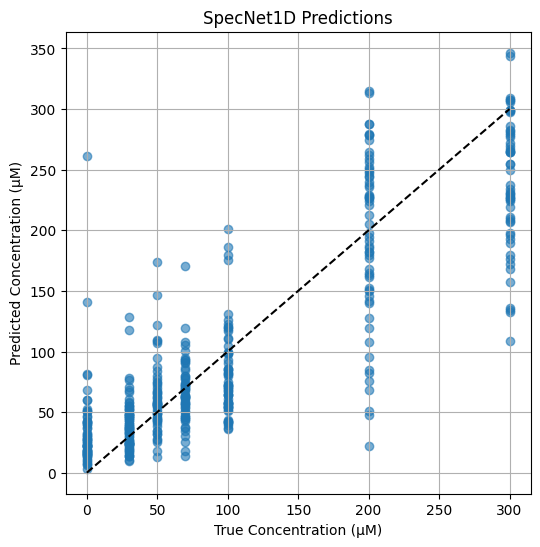

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(trues_cnn, preds_cnn, alpha=0.6)
mn, mx = trues_cnn.min(), trues_cnn.max()
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Concentration (µM)')
plt.ylabel('Predicted Concentration (µM)')
plt.title('SpecNet1D Predictions')
plt.grid(True)
plt.show()